In [123]:
import pandas as pd
import numpy as np
import json
import re
import csv
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from operator import attrgetter
from datetime import datetime
from fancyimpute import IterativeImputer
import statsmodels.api as sm
import pylab
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,f1_score,mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from collections import Counter
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 100)
sns.set(rc={'figure.figsize':(25,15)},font_scale=2)
from wordcloud import WordCloud
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pickle
import datetime
import seaborn as sns
from scipy.stats import kurtosis, skew
#plt.rcParams['figure.dpi'] = 150

In [4]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=2)

In [ ]:
JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
train_df=pd.read_csv('train.csv', 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}) # Important!!

In [ ]:
train_df.head()

In [7]:
for columns in JSON_COLUMNS:
    jsondf=json_normalize(train_df[columns])
    jsondf.columns=[f'{columns}.{subcolumns}' for subcolumns in jsondf.columns]
    train_df=train_df.drop(columns,axis=1).merge(jsondf,left_index=True,right_index=True)

In [54]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

In [8]:
%%time
train_df.head()

CPU times: user 797 µs, sys: 217 µs, total: 1.01 ms
Wall time: 868 µs


channelGrouping      date        fullVisitorId  \
0  Organic Search  20160902  1131660440785968503   
1  Organic Search  20160902   377306020877927890   
2  Organic Search  20160902  3895546263509774583   
3  Organic Search  20160902  4763447161404445595   
4  Organic Search  20160902    27294437909732085   

                        sessionId  socialEngagementType     visitId  \
0  1131660440785968503_1472830385  Not Socially Engaged  1472830385   
1   377306020877927890_1472880147  Not Socially Engaged  1472880147   
2  3895546263509774583_1472865386  Not Socially Engaged  1472865386   
3  4763447161404445595_1472881213  Not Socially Engaged  1472881213   
4    27294437909732085_1472822600  Not Socially Engaged  1472822600   

   visitNumber  visitStartTime device.browser          device.browserVersion  \
0            1      1472830385         Chrome  not available in demo dataset   
1            1      1472880147        Firefox  not available in demo dataset   
2            1      1472865386         Chrome  not available in demo dataset   
3            1      1472881213     UC Browser  not available in demo dataset   
4            2      1472822600         Chrome  not available in demo dataset   

   ... trafficSource.adwordsClickInfo.criteriaParameters  \
0  ...                     not available in demo dataset   
1  ...                     not available in demo dataset   
2  ...                     not available in demo dataset   
3  ...                     not available in demo dataset   
4  ...                     not available in demo dataset   

  trafficSource.isTrueDirect trafficSource.referralPath  \
0                        NaN                        NaN   
1                        NaN                        NaN   
2                        NaN                        NaN   
3                        NaN                        NaN   
4                       True                        NaN   

   trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  NaN                                 NaN   
4                                  NaN                                 NaN   

  trafficSource.adwordsClickInfo.gclId  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  trafficSource.adwordsClickInfo.adNetworkType  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

  trafficSource.adwordsClickInfo.isVideoAd trafficSource.adContent  \
0                                      NaN                     NaN   
1                                      NaN                     NaN   
2                                      NaN                     NaN   
3                                      NaN                     NaN   
4                                      NaN                     NaN   

  trafficSource.campaignCode  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 55 columns]

In [9]:
mask=train_df.eq('not available in demo dataset')
train_df.loc[:, mask.all()]

/Users/amiao/anaconda3/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


device.browserVersion             device.browserSize  \
0       not available in demo dataset  not available in demo dataset   
1       not available in demo dataset  not available in demo dataset   
2       not available in demo dataset  not available in demo dataset   
3       not available in demo dataset  not available in demo dataset   
4       not available in demo dataset  not available in demo dataset   
...                               ...                            ...   
903648  not available in demo dataset  not available in demo dataset   
903649  not available in demo dataset  not available in demo dataset   
903650  not available in demo dataset  not available in demo dataset   
903651  not available in demo dataset  not available in demo dataset   
903652  not available in demo dataset  not available in demo dataset   

        device.operatingSystemVersion    device.mobileDeviceBranding  \
0       not available in demo dataset  not available in demo dataset   
1       not available in demo dataset  not available in demo dataset   
2       not available in demo dataset  not available in demo dataset   
3       not available in demo dataset  not available in demo dataset   
4       not available in demo dataset  not available in demo dataset   
...                               ...                            ...   
903648  not available in demo dataset  not available in demo dataset   
903649  not available in demo dataset  not available in demo dataset   
903650  not available in demo dataset  not available in demo dataset   
903651  not available in demo dataset  not available in demo dataset   
903652  not available in demo dataset  not available in demo dataset   

             device.mobileDeviceModel     device.mobileInputSelector  \
0       not available in demo dataset  not available in demo dataset   
1       not available in demo dataset  not available in demo dataset   
2       not available in demo dataset  not available in demo dataset   
3       not available in demo dataset  not available in demo dataset   
4       not available in demo dataset  not available in demo dataset   
...                               ...                            ...   
903648  not available in demo dataset  not available in demo dataset   
903649  not available in demo dataset  not available in demo dataset   
903650  not available in demo dataset  not available in demo dataset   
903651  not available in demo dataset  not available in demo dataset   
903652  not available in demo dataset  not available in demo dataset   

              device.mobileDeviceInfo device.mobileDeviceMarketingName  \
0       not available in demo dataset    not available in demo dataset   
1       not available in demo dataset    not available in demo dataset   
2       not available in demo dataset    not available in demo dataset   
3       not available in demo dataset    not available in demo dataset   
4       not available in demo dataset    not available in demo dataset   
...                               ...                              ...   
903648  not available in demo dataset    not available in demo dataset   
903649  not available in demo dataset    not available in demo dataset   
903650  not available in demo dataset    not available in demo dataset   
903651  not available in demo dataset    not available in demo dataset   
903652  not available in demo dataset    not available in demo dataset   

                  device.flashVersion                device.language  \
0       not available in demo dataset  not available in demo dataset   
1       not available in demo dataset  not available in demo dataset   
2       not available in demo dataset  not available in demo dataset   
3       not available in demo dataset  not available in demo dataset   
4       not available in demo dataset  not available in demo dataset   
...                               ...                            ...   
903648  not available in dem

In [10]:
columns_unavaliable=train_df.loc[:, mask.all()].columns

In [11]:
#double check
np.unique(train_df.loc[:, mask.all()].values)

array(['not available in demo dataset'], dtype=object)

In [ ]:
train_df.drop(columns=columns_unavaliable,inplace=True)

In [13]:
train_df.dropna(how='all')

channelGrouping      date        fullVisitorId  \
0       Organic Search  20160902  1131660440785968503   
1       Organic Search  20160902   377306020877927890   
2       Organic Search  20160902  3895546263509774583   
3       Organic Search  20160902  4763447161404445595   
4       Organic Search  20160902    27294437909732085   
...                ...       ...                  ...   
903648          Social  20170104  5123779100307500332   
903649          Social  20170104  7231728964973959842   
903650          Social  20170104  5744576632396406899   
903651          Social  20170104  2709355455991750775   
903652          Social  20170104  0814900163617805053   

                             sessionId  socialEngagementType     visitId  \
0       1131660440785968503_1472830385  Not Socially Engaged  1472830385   
1        377306020877927890_1472880147  Not Socially Engaged  1472880147   
2       3895546263509774583_1472865386  Not Socially Engaged  1472865386   
3       4763447161404445595_1472881213  Not Socially Engaged  1472881213   
4         27294437909732085_1472822600  Not Socially Engaged  1472822600   
...                                ...                   ...         ...   
903648  5123779100307500332_1483554750  Not Socially Engaged  1483554750   
903649  7231728964973959842_1483543798  Not Socially Engaged  1483543798   
903650  5744576632396406899_1483526434  Not Socially Engaged  1483526434   
903651  2709355455991750775_1483592857  Not Socially Engaged  1483592857   
903652  0814900163617805053_1483574474  Not Socially Engaged  1483574474   

        visitNumber  visitStartTime   device.browser device.operatingSystem  \
0                 1      1472830385           Chrome                Windows   
1                 1      1472880147          Firefox              Macintosh   
2                 1      1472865386           Chrome                Windows   
3                 1      1472881213       UC Browser                  Linux   
4                 2      1472822600           Chrome                Android   
...             ...             ...              ...                    ...   
903648            1      1483554750           Chrome                Windows   
903649            1      1483543798           Chrome                Android   
903650            1      1483526434  Android Webview                Android   
903651            1      1483592864           Chrome                Windows   
903652            1      1483574474           Chrome                Android   

        ...  trafficSource.keyword trafficSource.isTrueDirect  \
0       ...         (not provided)                        NaN   
1       ...         (not provided)                        NaN   
2       ...         (not provided)                        NaN   
3       ...        google + online                        NaN   
4       ...         (not provided)                       True   
...     ...                    ...                        ...   
903648  ...                    NaN                        NaN   
903649  ...                    NaN                        NaN   
903650  ...                    NaN                        NaN   
903651  ...                    NaN                        NaN   
903652  ...                    NaN                        NaN   

       trafficSource.referralPath trafficSource.adwordsClickInfo.page  \
0                             NaN                                 NaN   
1                             NaN                                 NaN   
2                             NaN                                 NaN   
3                             NaN                                 NaN   
4                             NaN                                 NaN   
...                           ...                                 ...   
903648                 /yt/about/                                 NaN   
903649                 /yt/about/                                 NaN   
903650              /y

In [16]:
with open('train_df.pkl', 'wb') as f: # Use "with" to open a file in binary write "wb"" mode
    pickle.dump(train_df, f) 

In [6]:
with open('train_df.pkl', 'rb') as f: # Open the file in binary read-only "rb" mode
   train_df = pickle.load(f)   

In [94]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])

Number of unique visitors in train set :  714167  out of rows :  903653


In [95]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.operatingSystem', 'device.isMobile',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.visits', 'totals.hits', 'totals.pageviews', 'totals.bounces',
       'totals.newVisits', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent',

In [96]:
train_df['trafficSource.adwordsClickInfo.slot'].notnull()   # if want to improve model accuracy may need to add in

0         False
1         False
2         False
3         False
4         False
          ...  
903648    False
903649    False
903650    False
903651    False
903652    False
Name: trafficSource.adwordsClickInfo.slot, Length: 903653, dtype: bool

In [7]:
#missing values

number=train_df.isnull().sum().sort_values(ascending=False)
percentage=(train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending=False)
missing_value=pd.DataFrame({'n':number,'p':percentage})
missing_value[missing_value['n']!=0]

n         p
trafficSource.campaignCode                    903652  0.999999
trafficSource.adContent                       892707  0.987887
totals.transactionRevenue                     892138  0.987257
trafficSource.adwordsClickInfo.isVideoAd      882193  0.976252
trafficSource.adwordsClickInfo.adNetworkType  882193  0.976252
trafficSource.adwordsClickInfo.slot           882193  0.976252
trafficSource.adwordsClickInfo.page           882193  0.976252
trafficSource.adwordsClickInfo.gclId          882092  0.976140
trafficSource.isTrueDirect                    629648  0.696781
trafficSource.referralPath                    572712  0.633774
trafficSource.keyword                         502929  0.556551
totals.bounces                                453023  0.501324
totals.newVisits                              200593  0.221980
totals.pageviews                                 100  0.000111

In [8]:
c=missing_value[(missing_value['p']>=0.6)].index.tolist()
del c[2]

In [9]:
del c[-2]

In [10]:
for col in c:
    print(col,len(train_df[col].unique()),train_df[col].unique())

trafficSource.campaignCode 2 [nan '11251kjhkvahf']
trafficSource.adContent 45 [nan 'Full auto ad IMAGE ONLY' 'First Full Auto Template Test Ad'
 '{KeyWord:Google Brand Items}' 'Display Ad created 3/11/14'
 'Ad from 11/7/16' 'Display Ad created 3/11/15' 'Ad from 12/13/16'
 'Ad from 11/3/16' 'Google Online Store' 'Google Merchandise Collection'
 '{KeyWord:Want Google Stickers?}' '{KeyWord:Google Merchandise}'
 'Display Ad created 11/17/14' '{KeyWord:Google Drinkware}'
 "{KeyWord:Google Men's T-Shirts}" '{KeyWord:Google Branded Gear}'
 '{KeyWord:Google Branded Apparel}' 'Google Paraphernalia'
 'Swag with Google Logos' '{KeyWord:Google Branded Kit}'
 'Want Google Sunglasses' '{KeyWord:Looking for Google Bags?}'
 'Full auto ad TEXT ONLY' 'Google Merchandise' 'google store' 'LeEco_1a'
 'Full auto ad TEXT/NATIVE' '{KeyWord:Want Google Pet Toys?}'
 'Google Store' "Men's-Outerwear Google Apparel" '20% discount'
 'Full auto ad with Primary Color' 'JD_5a_v1'
 '{KeyWord:Google Branded Outerwear}' 

In [11]:
train_df.drop(columns=c,inplace=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 30 columns):
channelGrouping               903653 non-null object
date                          903653 non-null int64
fullVisitorId                 903653 non-null object
sessionId                     903653 non-null object
socialEngagementType          903653 non-null object
visitId                       903653 non-null int64
visitNumber                   903653 non-null int64
visitStartTime                903653 non-null int64
device.browser                903653 non-null object
device.operatingSystem        903653 non-null object
device.isMobile               903653 non-null bool
device.deviceCategory         903653 non-null object
geoNetwork.continent          903653 non-null object
geoNetwork.subContinent       903653 non-null object
geoNetwork.country            903653 non-null object
geoNetwork.region             903653 non-null object
geoNetwork.metro              903653 non-null o

In [146]:
train_df['trafficSource.campaign'].unique()  # not set  #delete

array(['(not set)', 'AW - Dynamic Search Ads Whole Site',
       'Data Share Promo', 'AW - Electronics', 'test-liyuhz',
       'AW - Accessories',
       'Retail (DO NOT EDIT owners nophakun and tianyu)', 'AW - Apparel',
       'All Products', 'Data Share'], dtype=object)

In [24]:
train_df['trafficSource.keyword'].unique() # too many missing values  #delete

array(['(not provided)', 'google + online', nan, ...,
       'www.google.com bag', 'Google store usar',
       'google shirt buy online'], dtype=object)

In [14]:
train_df['trafficSource.medium'].unique()  # the same as channelGrouping

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

In [22]:
train_df['trafficSource.source'].unique()  #delete? should transfer this into other ?

array(['google', 'baidu', 'googleweblight.com', 'sites.google.com',
       'bing', 'siliconvalley.about.com', 'analytics.google.com',
       'Partners', '(direct)', 'mall.googleplex.com', 'google.com',
       'google.co.in', 'qiita.com', 'google.pl', 'mail.google.com',
       'hangouts.google.com', 'dealspotr.com', 'optimize.google.com',
       'arstechnica.com', 'dfa', 'docs.google.com', 'sashihara.jp',
       'google.gatewaycdi.com', 'phandroid.com', 'images.google',
       'youtube.com', 'l.facebook.com', 'facebook.com', 'quora.com',
       'm.facebook.com', 'reddit.com', 'google.co.jp', 'aol',
       'moma.corp.google.com', 'blog.golang.org', 'yahoo', 't.co',
       'nordic.businessinsider.com', 'duckduckgo.com', 'm.baidu.com',
       'tpc.googlesyndication.com', 'googleads.g.doubleclick.net',
       '0.shared.bow.cat2.ads-bow.vu.borg.google.com:9856',
       'online-metrics.com', 'cv.il3.ub.edu', 'gophergala.com',
       'plus.google.com', 's0.2mdn.net', 'keep.google.com',
       

In [19]:
train_df['geoNetwork.subContinent'].unique() 

array(['Western Asia', 'Australasia', 'Southern Europe', 'Southeast Asia',
       'Northern Europe', 'Southern Asia', 'Western Europe',
       'South America', 'Eastern Asia', 'Eastern Europe',
       'Northern America', 'Western Africa', 'Central America',
       'Eastern Africa', '(not set)', 'Caribbean', 'Southern Africa',
       'Northern Africa', 'Central Asia', 'Middle Africa', 'Melanesia',
       'Micronesian Region', 'Polynesia'], dtype=object)

In [20]:
train_df['geoNetwork.continent'].unique()   #keep subcontinent

array(['Asia', 'Oceania', 'Europe', 'Americas', 'Africa', '(not set)'],
      dtype=object)

### feature selection

In [13]:
train_df.drop(['sessionId','socialEngagementType', 'visitId',
 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
 'totals.visits','trafficSource.medium', 'trafficSource.keyword',
 'trafficSource.campaign','totals.hits','device.deviceCategory'],axis=1,inplace=True)  #hits corr with pageview
#device category almost the same as device ismobile

In [14]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'geoNetwork.continent', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue',
       'trafficSource.source', 'trafficSource.isTrueDirect'],
      dtype='object')

In [16]:
train_df['totals.transactionRevenue']=train_df['totals.transactionRevenue'].astype(float)
#train_df['totals.hits']=train_df['totals.hits'].astype(float)
train_df['totals.pageviews']=train_df['totals.pageviews'].astype(float)
train_df['totals.bounces']=train_df['totals.bounces'].astype(float)
train_df['totals.newVisits']=train_df['totals.newVisits'].astype(float)

In [ ]:
reduce operatingSystem  ##need to understand the realtionship before drop

In [17]:
total_revenue=train_df['totals.transactionRevenue'].sum()

In [18]:
train_df[['device.operatingSystem','totals.transactionRevenue']].groupby('device.operatingSystem').sum().sort_values(by='totals.transactionRevenue',ascending=False)/total_revenue
lst=train_df[['device.operatingSystem','totals.transactionRevenue']]\
.groupby('device.operatingSystem').sum().sort_values(by='totals.transactionRevenue',ascending=False)[3:].index
lst


Index(['Linux', 'Android', 'iOS', 'Windows Phone', 'Nokia', 'Xbox', 'SunOS',
       'Samsung', 'OpenBSD', '(not set)', 'Nintendo WiiU', 'Nintendo 3DS',
       'NTT DoCoMo', 'FreeBSD', 'Firefox OS', 'BlackBerry', 'Nintendo Wii'],
      dtype='object', name='device.operatingSystem')

In [19]:
for l in lst:
    train_df['device.operatingSystem'].replace(l,np.nan,inplace=True)

In [20]:
train_df['device.operatingSystem'].unique()

array(['Windows', 'Macintosh', nan, 'Chrome OS'], dtype=object)

reduce browser

In [21]:
(train_df[['device.browser','totals.transactionRevenue' ]] \
.groupby('device.browser').sum().sort_values(by='totals.transactionRevenue',ascending=False)/total_revenue)[0:10]  # only need first 9 browsers

totals.transactionRevenue
device.browser                              
Chrome                              0.898079
Firefox                             0.057995
Safari                              0.034023
Internet Explorer                   0.005360
Edge                                0.004210
Opera                               0.000140
Safari (in-app)                     0.000100
Android Webview                     0.000075
Amazon Silk                         0.000019
Nokia Browser                       0.000000

In [22]:
lst=train_df[['device.browser','totals.transactionRevenue' ]] \
.groupby('device.browser').sum().sort_values(by='totals.transactionRevenue',ascending=False)[2:].index.to_list()
lst

['Safari',
 'Internet Explorer',
 'Edge',
 'Opera',
 'Safari (in-app)',
 'Android Webview',
 'Amazon Silk',
 'Nokia Browser',
 'NokiaE52-1',
 'SeaMonkey',
 'Opera Mini',
 'Puffin',
 'Nintendo Browser',
 'Reddit',
 'Nichrome',
 '(not set)',
 'Mozilla',
 'Seznam',
 'TCL P500M',
 'ThumbSniper',
 'UC Browser',
 'User Agent',
 'YE',
 'YaBrowser',
 '[Use default User-agent string] LIVRENPOCHE',
 'no-ua',
 'osee2unifiedRelease',
 'Mozilla Compatible Agent',
 'MQQBrowser',
 'Maxthon',
 'DoCoMo',
 'ADM',
 'Android Browser',
 'Android Runtime',
 'Apple-iPhone7C2',
 'BlackBerry',
 'CSM Click',
 'Changa 99695759',
 'Coc Coc',
 'DASH_JR_3G',
 'HTC802t_TD',
 'MRCHROME',
 'Hisense M20-M_LTE',
 'IE with Chrome Frame',
 'Iron',
 'Konqueror',
 'LYF_LS_4002_11',
 'LYF_LS_4002_12',
 'Lunascape',
 'M5',
 '0',
 'subjectAgent: NoticiasBoom']

In [23]:
for l in lst:
    train_df['device.browser'].replace(l,np.nan,inplace=True)

In [24]:
train_df['device.browser'].unique()

array(['Chrome', 'Firefox', nan], dtype=object)

In [25]:
train_df['date']=pd.to_datetime(train_df['date'],format="%Y%m%d")
train_df['date']

0        2016-09-02
1        2016-09-02
2        2016-09-02
3        2016-09-02
4        2016-09-02
            ...    
903648   2017-01-04
903649   2017-01-04
903650   2017-01-04
903651   2017-01-04
903652   2017-01-04
Name: date, Length: 903653, dtype: datetime64[ns]

create new features

In [26]:
train_df['weekdays']=train_df['date'].dt.weekday
train_df['months']=train_df['date'].dt.month

In [27]:
train_df['visitStartTime']=pd.to_datetime(train_df['visitStartTime'],unit='s')
train_df['visitStartTime']

0        2016-09-02 15:33:05
1        2016-09-03 05:22:27
2        2016-09-03 01:16:26
3        2016-09-03 05:40:13
4        2016-09-02 13:23:20
                 ...        
903648   2017-01-04 18:32:30
903649   2017-01-04 15:29:58
903650   2017-01-04 10:40:34
903651   2017-01-05 05:07:44
903652   2017-01-05 00:01:14
Name: visitStartTime, Length: 903653, dtype: datetime64[ns]

In [28]:
train_df['visithour']=train_df['visitStartTime'].dt.hour

Purchased or not

In [49]:
#train_df.loc[train_df['totals.transactionRevenue']>0,'purchased']=1

In [51]:
#train_df['purchased'].fillna(0,inplace=True)

create new feature from source

In [23]:
#source=train_df['trafficSource.source'].str.split('.')
source=" ".join(train_df['trafficSource.source'][train_df['trafficSource.source'].notnull()]).lower().split()

In [24]:
source=' '.join(source).split('.')
source=' '.join(source).split()

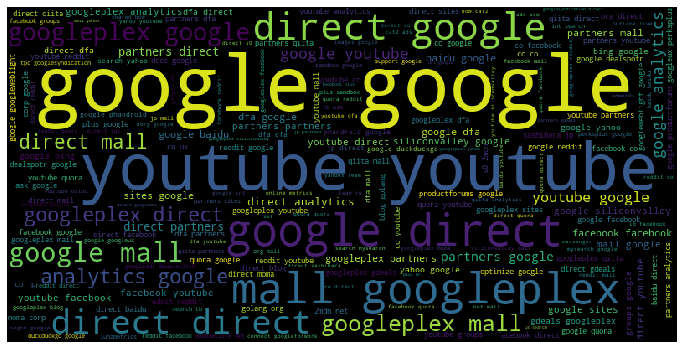

In [29]:
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure(figsize=(12,9))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [29]:
train_df.loc[train_df['trafficSource.source'].str.contains('google'),'source']='google'
train_df.loc[train_df['trafficSource.source'].str.contains('youtube'),'source']='youtube'
train_df['source'][train_df['source'].isnull()]='other'

In [30]:
train_df[['source','trafficSource.source']]

source trafficSource.source
0        google               google
1        google               google
2        google               google
3        google               google
4        google               google
...         ...                  ...
903648  youtube          youtube.com
903649  youtube          youtube.com
903650  youtube          youtube.com
903651    other         facebook.com
903652  youtube          youtube.com

[903653 rows x 2 columns]

In [31]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'geoNetwork.continent', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue',
       'trafficSource.source', 'trafficSource.isTrueDirect', 'weekdays',
       'months', 'visithour', 'source'],
      dtype='object')

In [32]:
train_df.isnull().sum()

channelGrouping                    0
date                               0
fullVisitorId                      0
visitNumber                        0
visitStartTime                     0
device.browser                246220
device.operatingSystem        273306
device.isMobile                    0
geoNetwork.continent               0
totals.pageviews                 100
totals.bounces                453023
totals.newVisits              200593
totals.transactionRevenue     892138
trafficSource.source               0
trafficSource.isTrueDirect    629648
weekdays                           0
months                             0
visithour                          0
source                             0
dtype: int64

In [33]:
train_df['trafficSource.isTrueDirect'].fillna('False',inplace=True)

In [34]:
train_df['totals.pageviews'].fillna(0,inplace=True)
train_df['totals.bounces'].fillna(0,inplace=True)
train_df['totals.newVisits'].fillna(0,inplace=True)
train_df['totals.transactionRevenue'].fillna(0,inplace=True)

In [35]:
train_df.isnull().sum()

channelGrouping                    0
date                               0
fullVisitorId                      0
visitNumber                        0
visitStartTime                     0
device.browser                246220
device.operatingSystem        273306
device.isMobile                    0
geoNetwork.continent               0
totals.pageviews                   0
totals.bounces                     0
totals.newVisits                   0
totals.transactionRevenue          0
trafficSource.source               0
trafficSource.isTrueDirect         0
weekdays                           0
months                             0
visithour                          0
source                             0
dtype: int64

In [36]:
train_df['log_revenue']=np.log1p(train_df['totals.transactionRevenue'].fillna(0))

In [37]:
visitor_df=train_df.fullVisitorId
visitor_df

0         1131660440785968503
1          377306020877927890
2         3895546263509774583
3         4763447161404445595
4           27294437909732085
                 ...         
903648    5123779100307500332
903649    7231728964973959842
903650    5744576632396406899
903651    2709355455991750775
903652    0814900163617805053
Name: fullVisitorId, Length: 903653, dtype: object

In [38]:
df_train=copy.deepcopy(train_df.drop(['fullVisitorId','trafficSource.source','visitStartTime','totals.transactionRevenue'],axis=1))

In [39]:
df_train.dtypes

channelGrouping                       object
date                          datetime64[ns]
visitNumber                            int64
device.browser                        object
device.operatingSystem                object
device.isMobile                         bool
geoNetwork.continent                  object
totals.pageviews                     float64
totals.bounces                       float64
totals.newVisits                     float64
trafficSource.isTrueDirect            object
weekdays                               int64
months                                 int64
visithour                              int64
source                                object
log_revenue                          float64
dtype: object

In [40]:
df_train['date']=df_train['date'].map(datetime.datetime.toordinal)

In [41]:
df_train.dtypes

channelGrouping                object
date                            int64
visitNumber                     int64
device.browser                 object
device.operatingSystem         object
device.isMobile                  bool
geoNetwork.continent           object
totals.pageviews              float64
totals.bounces                float64
totals.newVisits              float64
trafficSource.isTrueDirect     object
weekdays                        int64
months                          int64
visithour                       int64
source                         object
log_revenue                   float64
dtype: object

In [42]:
df_train=pd.get_dummies(df_train,drop_first=True)
df_train

date  visitNumber  device.isMobile  totals.pageviews  \
0       736209            1            False               1.0   
1       736209            1            False               1.0   
2       736209            1            False               1.0   
3       736209            1            False               1.0   
4       736209            2             True               1.0   
...        ...          ...              ...               ...   
903648  736333            1            False              15.0   
903649  736333            1             True              13.0   
903650  736333            1             True              21.0   
903651  736333            1            False              22.0   
903652  736333            1             True              31.0   

        totals.bounces  totals.newVisits  weekdays  months  visithour  \
0                  1.0               1.0         4       9         15   
1                  1.0               1.0         4       9          5   
2                  1.0               1.0         4       9          1   
3                  1.0               1.0         4       9          5   
4                  1.0               0.0         4       9         13   
...                ...               ...       ...     ...        ...   
903648             0.0               1.0         2       1         18   
903649             0.0               1.0         2       1         15   
903650             0.0               1.0         2       1         10   
903651             0.0               1.0         2       1          5   
903652             0.0               1.0         2       1          0   

        log_revenue  channelGrouping_Affiliates  channelGrouping_Direct  \
0               0.0                           0                       0   
1               0.0                           0                       0   
2               0.0                           0                       0   
3               0.0                           0                       0   
4               0.0                           0                       0   
...             ...                         ...                     ...   
903648          0.0                           0                       0   
903649          0.0                           0                       0   
903650          0.0                           0                       0   
903651          0.0                           0                       0   
903652          0.0                           0                       0   

        channelGrouping_Display  channelGrouping_Organic Search  \
0                             0                               1   
1                             0                               1   
2                             0                               1   
3                             0                               1   
4                             0                               1   
...                         ...                             ...   
903648                        0                               0   
903649                        0                               0   
903650                        0                               0   
903651                        0                               0   
903652                        0                               0   

        channelGrouping_Paid Search  channelGrouping_Referral  \
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
...                             ...                       ...   
903648                            0                         0   
903649                            0                         0   
903650                            0              

### option 1 train test split for umbalanced datasets

In [175]:
X_temp=df_train.drop('log_revenue',axis=1)
y=df_train['log_revenue'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X=pd.DataFrame(X_values,columns=X_temp.columns)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

In [339]:
df_train.columns

Index(['date', 'visitNumber', 'device.isMobile', 'totals.pageviews',
       'totals.bounces', 'totals.newVisits', 'weekdays', 'months', 'visithour',
       'log_revenue', 'channelGrouping_Affiliates', 'channelGrouping_Direct',
       'channelGrouping_Display', 'channelGrouping_Organic Search',
       'channelGrouping_Paid Search', 'channelGrouping_Referral',
       'channelGrouping_Social', 'device.browser_Firefox',
       'device.operatingSystem_Macintosh', 'device.operatingSystem_Windows',
       'geoNetwork.continent_Africa', 'geoNetwork.continent_Americas',
       'geoNetwork.continent_Asia', 'geoNetwork.continent_Europe',
       'geoNetwork.continent_Oceania', 'trafficSource.isTrueDirect_False',
       'source_other', 'source_youtube'],
      dtype='object')

### clustering for different customers

In [43]:
key_features = ['totals.pageviews','visitNumber','totals.bounces','geoNetwork.continent_Americas','channelGrouping_Referral','device.operatingSystem_Macintosh']
cluster_data = df_train[key_features]
cluster_data

totals.pageviews  visitNumber  totals.bounces  \
0                    1.0            1             1.0   
1                    1.0            1             1.0   
2                    1.0            1             1.0   
3                    1.0            1             1.0   
4                    1.0            2             1.0   
...                  ...          ...             ...   
903648              15.0            1             0.0   
903649              13.0            1             0.0   
903650              21.0            1             0.0   
903651              22.0            1             0.0   
903652              31.0            1             0.0   

        geoNetwork.continent_Americas  channelGrouping_Referral  \
0                                   0                         0   
1                                   0                         0   
2                                   0                         0   
3                                   0                         0   
4                                   0                         0   
...                               ...                       ...   
903648                              1                         0   
903649                              0                         0   
903650                              0                         0   
903651                              0                         0   
903652                              1                         0   

        device.operatingSystem_Macintosh  
0                                      0  
1                                      1  
2                                      0  
3                                      0  
4                                      0  
...                                  ...  
903648                                 0  
903649                                 0  
903650                                 0  
903651                                 0  
903652                                 0  

[903653 rows x 6 columns]

In [44]:
stscaler = StandardScaler().fit(cluster_data)
cluster_data_scaled = stscaler.transform(cluster_data)

In [45]:
ks = range(1,10) 
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(cluster_data_scaled)
    inertias.append(model.inertia_)

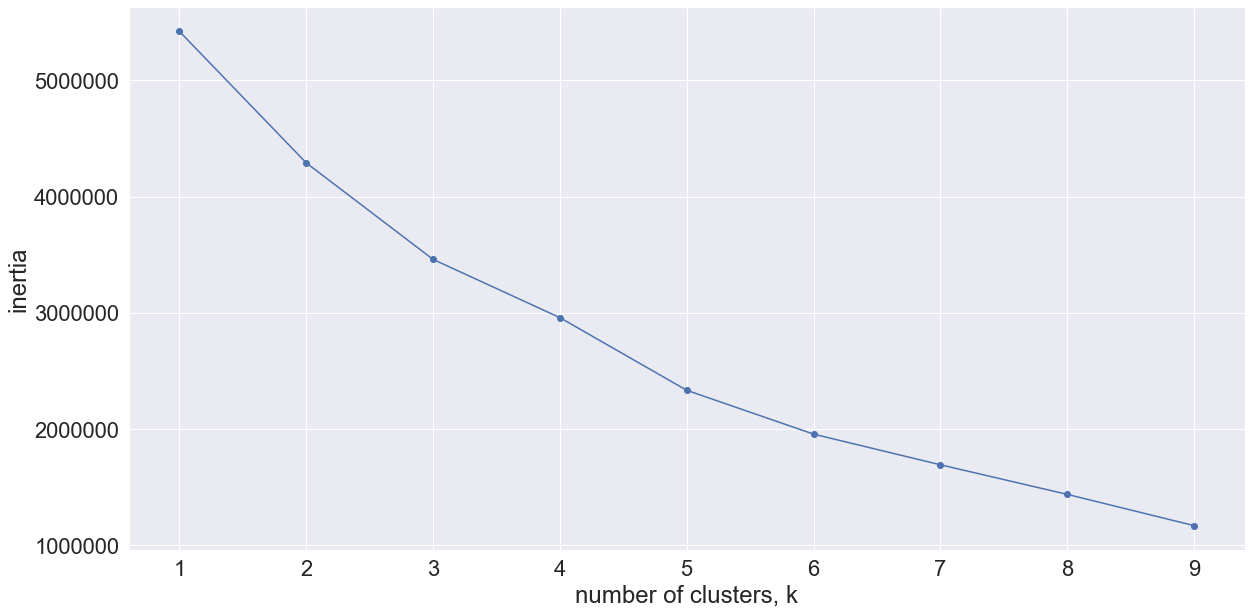

In [46]:
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks()
plt.show()

In [134]:
model = KMeans(n_clusters = 5)  #but 4 is better
labels = model.fit_predict(cluster_data_scaled)
print(labels)

[1 0 1 ... 3 3 3]


### merge 0 and 1 togther after group discussion

In [138]:
labels=np.where(labels==0,1,labels)

In [139]:
labels

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [151]:
X_temp=df_train.drop('log_revenue',axis=1)
y=df_train['log_revenue'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X=pd.DataFrame(X_values,columns=X_temp.columns)
X['visitorid']=visitor_df.values

In [152]:
X['labels']=labels

In [153]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

In [154]:
X_train_visitor_c=X_train[['labels','visitorid']]
X_test_visitor_c=X_test[['labels','visitorid']]
X_train.drop('visitorid',axis=1,inplace=True)
X_test.drop('visitorid',axis=1,inplace=True)

In [155]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

## models

### model 1

### model 1 by group

In [156]:
labels_unique=X['labels'].unique()
y_predict1_train=np.zeros_like(y_train)
y_predict1_test=np.zeros_like(y_test)
models1=[]
modelsname1=[]
for label in labels_unique:
    model1 = LinearRegression()
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model1.fit(df_x_train,y_2)
    models1.append(model1)
    modelsname1.append(label)
    y_predict1_train[index_train]=model1.predict(df_x_train)
    y_predict1_test[index_test]=model1.predict(df_x_test)

models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [157]:
mean_squared_error(y_train,y_predict1_train)**0.5

1.7796678717591379

In [158]:
mean_squared_error(y_test,y_predict1_test)**0.5

1.7806701511763252

In [159]:
X_train_visitor_c['y_true']=y_train.values
X_test_visitor_c['y_true']=y_test.values
X_train_visitor_c['y_predict_1']=y_predict1_train
X_test_visitor_c['y_predict_1']=y_predict1_test
X_train_visitor_c.loc[X_train_visitor_c['y_predict_1']<0,'y_predict_1']=0
X_test_visitor_c.loc[X_test_visitor_c['y_predict_1']<0,'y_predict_1']=0

### model 2

### model 2  by group

In [160]:
labels_unique=X['labels'].unique()
y_predict2_train=np.zeros_like(y_train)
y_predict2_test=np.zeros_like(y_test)
models2=[]
modelsname2=[]
for label in labels_unique:
    model2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model2.fit(df_x_train,y_2)
    models2.append(model2)
    modelsname2.append(label)
    y_predict2_train[index_train]=model2.predict(df_x_train)
    y_predict2_test[index_test]=model2.predict(df_x_test)

#models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [164]:
mean_squared_error(y_train,y_predict2_train)**0.5

1.4287879774837202

In [165]:
mean_squared_error(y_test,y_predict2_test)**0.5

1.6788513716825801

In [166]:
X_train_visitor_c['y_predict_2']=y_predict2_train
X_test_visitor_c['y_predict_2']=y_predict2_test
X_train_visitor_c.loc[X_train_visitor_c['y_predict_2']<0,'y_predict_2']=0
X_test_visitor_c.loc[X_test_visitor_c['y_predict_2']<0,'y_predict_2']=0

### model 3 by group

In [167]:
labels_unique=X['labels'].unique()
y_predict3_train=np.zeros_like(y_train)
y_predict3_test=np.zeros_like(y_test)
models3=[]
modelsname3=[]
for label in labels_unique:
    model3 =Ridge(alpha=0.16)
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model3.fit(df_x_train,y_2)
    models3.append(model3)
    modelsname3.append(label)
    y_predict3_train[index_train]=model3.predict(df_x_train)
    y_predict3_test[index_test]=model3.predict(df_x_test)

#models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [168]:
mean_squared_error(y_train,y_predict3_train)**0.5

1.7796804331624239

In [169]:
mean_squared_error(y_test,y_predict3_test)**0.5

1.7806391927984424

In [170]:
X_train_visitor_c['y_predict_3']=y_predict3_train
X_test_visitor_c['y_predict_3']=y_predict3_test
X_train_visitor_c.loc[X_train_visitor_c['y_predict_3']<0,'y_predict_3']=0
X_test_visitor_c.loc[X_test_visitor_c['y_predict_3']<0,'y_predict_3']=0

### model 5 by group

In [171]:
labels_unique=X['labels'].unique()
y_predict5_train=np.zeros_like(y_train)
y_predict5_test=np.zeros_like(y_test)
models5=[]
modelsname5=[]
for label in labels_unique:
    model5 = XGBRegressor(max_depth=20,eta=0.01,subsample=0.3,colsample_bytree=0.2)
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model5.fit(df_x_train,y_2)
    models5.append(model3)
    modelsname5.append(label)
    y_predict5_train[index_train]=model5.predict(df_x_train)
    y_predict5_test[index_test]=model5.predict(df_x_test)

#models_linear={mn:m for mn,m in zip(modelsname1,models1)}

[22:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:58:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [172]:
mean_squared_error(y_train,y_predict5_train)**0.5

1.500756928636488

In [173]:
mean_squared_error(y_test,y_predict5_test)**0.5

1.740027144505674

In [174]:
X_train_visitor_c['y_predict_5']=y_predict5_train
X_test_visitor_c['y_predict_5']=y_predict5_test
X_train_visitor_c.loc[X_train_visitor_c['y_predict_5']<0,'y_predict_5']=0
X_test_visitor_c.loc[X_test_visitor_c['y_predict_5']<0,'y_predict_5']=0

### model 6 by group

In [175]:
labels_unique=X['labels'].unique()
y_predict6_train=np.zeros_like(y_train)
y_predict6_test=np.zeros_like(y_test)
models6=[]
modelsname6=[]
for label in labels_unique:
    model6 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,min_samples_split = 500,
                                       max_depth=5, random_state=0, loss='ls',max_features = 'sqrt' )
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model6.fit(df_x_train,y_2)
    models6.append(model3)
    modelsname6.append(label)
    y_predict6_train[index_train]=model6.predict(df_x_train)
    y_predict6_test[index_test]=model6.predict(df_x_test)

#models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [176]:
mean_squared_error(y_train,y_predict6_train)**0.5

1.6147174261008046

In [177]:
mean_squared_error(y_test,y_predict6_test)**0.5

1.6743242250218056

In [178]:
X_train_visitor_c['y_predict_6']=y_predict6_train
X_test_visitor_c['y_predict_6']=y_predict6_test
X_train_visitor_c.loc[X_train_visitor_c['y_predict_6']<0,'y_predict_6']=0
X_test_visitor_c.loc[X_test_visitor_c['y_predict_6']<0,'y_predict_6']=0

### group to cluster level

In [179]:
X_test_visitor_c

labels            visitorid  y_true  y_predict_1  y_predict_2  \
385888       3  9385386957294731203     0.0     0.125314     0.062022   
757416       4  5996613242601142887     0.0     0.000000     0.000000   
204067       1  8316614961710691105     0.0     0.000000     0.000000   
681046       1  0602474884465517481     0.0     0.043971     0.000000   
818808       1    39115612586492241     0.0     0.009852     0.000000   
...        ...                  ...     ...          ...          ...   
396664       1  2910450732188252773     0.0     0.014285     0.000000   
760888       1  8762031288395176730     0.0     0.012510     0.000000   
391219       1  6224989781308788815     0.0     0.000000     0.000000   
396356       1  0218666689378557083     0.0     0.045863     0.000000   
179109       1  4796032471233549944     0.0     0.107630     0.000000   

        y_predict_3  y_predict_5  y_predict_6  
385888     0.126691     0.484157     0.000000  
757416     0.000000     0.000000     0.000000  
204067     0.000000     0.000000     0.000000  
681046     0.042482     0.000000     0.000000  
818808     0.007750     0.000000     0.000000  
...             ...          ...          ...  
396664     0.013956     0.000000     0.000000  
760888     0.012729     0.015751     0.000000  
391219     0.000000     0.000000     0.002925  
396356     0.045500     0.000000     0.001446  
179109     0.105773     0.000000     0.004198  

[271096 rows x 8 columns]

In [180]:
cluster_score1={}
cluster_score2={}
cluster_score3={}
cluster_score5={}
cluster_score6={}
for label in X_test_visitor_c.labels.unique():
    a=X_test_visitor_c[X_test_visitor_c.labels==label]
    cluster_score1[label]=mean_squared_error(a.y_true,a.y_predict_1)**0.5
    cluster_score2[label]=mean_squared_error(a.y_true,a.y_predict_2)**0.5
    cluster_score3[label]=mean_squared_error(a.y_true,a.y_predict_3)**0.5
    cluster_score5[label]=mean_squared_error(a.y_true,a.y_predict_5)**0.5
    cluster_score6[label]=mean_squared_error(a.y_true,a.y_predict_6)**0.5


In [181]:
cluster_score1

{3: 2.004124522407187,
 4: 3.4474583479235243,
 1: 0.9869659306183676,
 2: 2.0439214488287396}

In [182]:
cluster_score2

{3: 1.8963417307320485,
 4: 3.237548750447409,
 1: 0.9439075031742111,
 2: 1.8296190788021416}

In [183]:
cluster_score3

{3: 2.0041591845103257,
 4: 3.447572299733543,
 1: 0.9870506106630452,
 2: 2.0375844374868493}

In [184]:
cluster_score5

{3: 1.9739737752335773,
 4: 3.345972586603326,
 1: 0.9653190820404784,
 2: 2.0731757757070666}

In [185]:
cluster_score6

{3: 1.8987134632278924,
 4: 3.215467632627737,
 1: 0.9386309602941766,
 2: 1.9516589900556165}

In [186]:
X_test_visitor_x=X_test_visitor_c.groupby(['labels','visitorid']).sum().reset_index()
X_test_visitor_x

labels            visitorid     y_true  y_predict_1  y_predict_2  \
0            1  0000027376579751715   0.000000     0.181910     0.018562   
1            1  0000114156543135683   0.000000     0.000000     0.000000   
2            1  0000213131142648941  17.329739     1.568019     4.684821   
3            1  0000253133284033056   0.000000     0.000000     0.000000   
4            1   000033471059618621   0.000000     0.037443     0.000000   
...        ...                  ...        ...          ...          ...   
248903       4   999889763383834152   0.000000     0.869144     0.145717   
248904       4  9999136945887060446   0.000000     0.453325     0.152868   
248905       4  9999252426441855495   0.000000     0.234825     0.000000   
248906       4  9999470222842102470   0.000000     0.461384     0.000081   
248907       4  9999636803769846518   0.000000     0.000000     0.000000   

        y_predict_3  y_predict_5  y_predict_6  
0          0.184521     0.000000     0.000000  
1          0.000000     0.010102     0.003873  
2          1.548986     3.214627     5.731589  
3          0.000000     0.005356     0.000000  
4          0.035907     0.000000     0.000000  
...             ...          ...          ...  
248903     0.871400     0.342401     0.131792  
248904     0.461285     0.270868     0.000000  
248905     0.235532     0.098599     0.000000  
248906     0.461498     0.000000     0.000000  
248907     0.000000     0.056621     0.038019  

[248908 rows x 8 columns]

In [187]:
cluster_score1={}
cluster_score2={}
cluster_score3={}
cluster_score5={}
cluster_score6={}
for label in X_test_visitor_x.labels.unique():
    a=X_test_visitor_x[X_test_visitor_x.labels==label]
    cluster_score1[label]=mean_squared_error(a.y_true,a.y_predict_1)**0.5
    cluster_score2[label]=mean_squared_error(a.y_true,a.y_predict_2)**0.5
    cluster_score3[label]=mean_squared_error(a.y_true,a.y_predict_3)**0.5
    cluster_score5[label]=mean_squared_error(a.y_true,a.y_predict_5)**0.5
    cluster_score6[label]=mean_squared_error(a.y_true,a.y_predict_6)**0.5

In [188]:
cluster_score1

{1: 1.0354417608835158,
 2: 13.468779821096575,
 3: 2.1732702994060733,
 4: 3.9445473288855597}

In [189]:
cluster_score2

{1: 0.9907945482769694,
 2: 8.968768384270689,
 3: 2.001115173790809,
 4: 3.6802100549265466}

In [191]:
cluster_score3

{1: 1.0355330181483993,
 2: 13.355923608873198,
 3: 2.1733437036090058,
 4: 3.94483910965457}

In [192]:
cluster_score5

{1: 1.0107494809851816,
 2: 13.633525137437164,
 3: 2.1168768451153617,
 4: 3.8119176409889097}

In [193]:
cluster_score6

{1: 0.9844736087025016,
 2: 10.950508501229246,
 3: 2.0114885680801478,
 4: 3.657344800369584}

In [194]:
df=pd.DataFrame({'Linear Regressor':cluster_score1,'Random Forest Regressor': cluster_score2,'Ridege Regressor':cluster_score3,
             'XGBRegressor':cluster_score5,'GradientBoostingRegressor':cluster_score6})
df

Linear Regressor  Random Forest Regressor  Ridege Regressor  XGBRegressor  \
1          1.035442                 0.990795          1.035533      1.010749   
2         13.468780                 8.968768         13.355924     13.633525   
3          2.173270                 2.001115          2.173344      2.116877   
4          3.944547                 3.680210          3.944839      3.811918   

   GradientBoostingRegressor  
1                   0.984474  
2                  10.950509  
3                   2.011489  
4                   3.657345

In [199]:
df.index=[2,4,1,3]
df.sort_index()

Linear Regressor  Random Forest Regressor  Ridege Regressor  XGBRegressor  \
1          2.173270                 2.001115          2.173344      2.116877   
2          1.035442                 0.990795          1.035533      1.010749   
3          3.944547                 3.680210          3.944839      3.811918   
4         13.468780                 8.968768         13.355924     13.633525   

   GradientBoostingRegressor  
1                   2.011489  
2                   0.984474  
3                   3.657345  
4                  10.950509

In [97]:
mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_1)**0.5

1.9656168500183906

In [417]:
# (((X_test_visitor_c.y_true-X_test_visitor_c.y_predict_1)**2).sum()/len(X_test_visitor_c))**0.5

1.8160134667802321

In [98]:
mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_2)**0.5

1.8258746521164788

In [99]:
mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_3)**0.5

1.9657311694192579

In [100]:
mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_5)**0.5

1.901644317304418

In [101]:
mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_6)**0.5

1.8275118163994344

In [111]:
df=pd.DataFrame({'Linear Regressor':mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_1)**0.5,
'Random Forest Regressor':mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_2)**0.5,
'Ridge Regressor':mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_3)**0.5,
'XGBRegressor':mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_5)**0.5,
'GradientBoostingRegressor':mean_squared_error(X_test_visitor_x.y_true,X_test_visitor_x.y_predict_6)**0.5
}.items())
df

0         1
0           Linear Regressor  1.965617
1    Random Forest Regressor  1.825875
2            Ridge Regressor  1.965731
3               XGBRegressor  1.901644
4  GradientBoostingRegressor  1.827512

In [121]:
prediction_result2=pd.read_csv('prediction_results 2.csv', engine='python',index_col=0)

In [122]:
prediction_result2

Linear Regressor  Random Forest Regressor  Ridge Regressor  \
Models                                                                       
customer_level          1.965617                 1.825875         1.965731   

                XGBRegressor  GradientBoostingRegressor  
Models                                                   
customer_level      1.901644                   1.827512

### model 1 overall sessions level

In [256]:
X_temp=df_train.drop('log_revenue',axis=1)
y=df_train['log_revenue'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X=pd.DataFrame(X_values,columns=X_temp.columns)
X['visitorid']=visitor_df.values

In [296]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42)

In [297]:
X_train_visitor=X_train[['visitorid']]
X_test_visitor=X_test[['visitorid']]
X_train.drop('visitorid',axis=1,inplace=True)
X_test.drop('visitorid',axis=1,inplace=True)

In [259]:
model1 = LinearRegression()
model1.fit(X_train,y_train)
ypredict1_train=model1.predict(X_train)
ypredict1_test=model1.predict(X_test)

In [298]:
X_train_visitor['y_true']=y_train.values
X_test_visitor['y_true']=y_test.values
X_train_visitor['y_predict_1']=ypredict1_train
X_test_visitor['y_predict_1']=ypredict1_test

In [299]:
X_train_visitor.loc[X_train_visitor['y_predict_1']<0,'y_predict_1']=0
X_test_visitor.loc[X_test_visitor['y_predict_1']<0,'y_predict_1']=0

### session level

In [181]:
mean_squared_error(y_train,ypredict1_train)**0.5

1.8205671039937235

In [182]:
mean_squared_error(y_test,ypredict1_test)**0.5

1.820127365387047

### model 2 overall sessions levels

In [262]:
model2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)
model2.fit(X_train,y_train)
ypredict2_train=model2.predict(X_train)
ypredict2_test=model2.predict(X_test)

In [300]:
X_train_visitor['y_predict_2']=ypredict2_train
X_test_visitor['y_predict_2']=ypredict2_test

In [301]:
X_train_visitor.loc[X_train_visitor['y_predict_2']<0,'y_predict_2']=0
X_test_visitor.loc[X_test_visitor['y_predict_2']<0,'y_predict_2']=0

### session level

In [184]:
mean_squared_error(y_train,ypredict2_train)**0.5

1.228480769868022

In [185]:
mean_squared_error(y_test,ypredict2_test)**0.5

1.6854921796930857

### feature importance

In [323]:
importances_rf=pd.Series(model2.feature_importances_,
                         index=X_train.columns).sort_values(ascending=False)

In [187]:
importances_rf[0:30]

totals.pageviews                    0.453077
date                                0.136435
visithour                           0.100764
weekdays                            0.060032
months                              0.056783
visitNumber                         0.053863
geoNetwork.continent_Americas       0.022720
channelGrouping_Referral            0.017310
device.operatingSystem_Macintosh    0.013103
totals.newVisits                    0.011711
totals.bounces                      0.011164
trafficSource.isTrueDirect_False    0.009404
device.operatingSystem_Windows      0.008919
device.isMobile                     0.008713
channelGrouping_Organic Search      0.006799
geoNetwork.continent_Asia           0.005204
geoNetwork.continent_Europe         0.005043
source_other                        0.004835
channelGrouping_Direct              0.003634
channelGrouping_Paid Search         0.002751
device.browser_Firefox              0.002569
channelGrouping_Social              0.001873
channelGro

### model 3 overall session level

In [265]:
model3 = Ridge(alpha=0.16)
model3.fit(X_train,y_train)
ypredict3_train=model3.predict(X_train)
ypredict3_test=model3.predict(X_test)

In [302]:
X_train_visitor['y_predict_3']=ypredict3_train
X_test_visitor['y_predict_3']=ypredict3_test

In [303]:
X_train_visitor.loc[X_train_visitor['y_predict_3']<0,'y_predict_3']=0
X_test_visitor.loc[X_test_visitor['y_predict_3']<0,'y_predict_3']=0

In [266]:
mean_squared_error(y_train,ypredict3_train)**0.5

1.8205673895307406

In [190]:
mean_squared_error(y_test,ypredict3_test)**0.5

1.8201432750096311

In [191]:
model4 =Lasso(alpha=0.15)
model4.fit(X_train,y_train)
ypredict4_train=model4.predict(X_train)
ypredict4_test=model4.predict(X_test)

In [192]:
mean_squared_error(y_train,ypredict4_train)**0.5

2.0018815293954564

In [193]:
mean_squared_error(y_test,ypredict4_test)**0.5

2.0079678139855135

### model 5 overall session level

In [275]:
model5=XGBRegressor(max_depth=20,eta=0.01,subsample=0.3,colsample_bytree=0.2)
model5.fit(X_train,y_train)
ypredict5_train=model5.predict(X_train)
ypredict5_test=model5.predict(X_test)

[12:12:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [304]:
X_train_visitor['y_predict_5']=ypredict5_train
X_test_visitor['y_predict_5']=ypredict5_test

In [305]:
X_train_visitor.loc[X_train_visitor['y_predict_5']<0,'y_predict_5']=0
X_test_visitor.loc[X_test_visitor['y_predict_5']<0,'y_predict_5']=0

In [195]:
mean_squared_error(y_train,ypredict5_train)**0.5

1.641615144380486

In [196]:
mean_squared_error(y_test,ypredict5_test)**0.5

1.7470613711838463

### model 6 overall session level

In [292]:
model6=GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,min_samples_split = 500,
                                       max_depth=5, random_state=0, loss='ls',max_features = 'sqrt' )
model6.fit(X_train,y_train)
ypredict6_train=model6.predict(X_train)
ypredict6_test=model6.predict(X_test)

In [306]:
X_train_visitor['y_predict_6']=ypredict6_train
X_test_visitor['y_predict_6']=ypredict6_test

In [307]:
X_train_visitor.loc[X_train_visitor['y_predict_6']<0,'y_predict_6']=0
X_test_visitor.loc[X_test_visitor['y_predict_6']<0,'y_predict_6']=0

In [293]:
mean_squared_error(y_train,ypredict6_train)**0.5

1.6472929491156678

In [294]:
mean_squared_error(y_test,ypredict6_test)**0.5

1.6719631828919577

In [ ]:
X_train_visitor['y_predict_6']=ypredict6_train
X_test_visitor['y_predict_6']=ypredict6_test

### feature importance

In [322]:
importances_GB=pd.Series(model6.feature_importances_,
                         index=X_train.columns).sort_values(ascending=False)

In [325]:
importances_GB[0:10]

totals.pageviews                    0.710261
geoNetwork.continent_Americas       0.062590
channelGrouping_Referral            0.034597
visitNumber                         0.028597
date                                0.021541
device.operatingSystem_Macintosh    0.019925
totals.newVisits                    0.019367
totals.bounces                      0.018929
device.isMobile                     0.013465
geoNetwork.continent_Asia           0.012720
dtype: float64

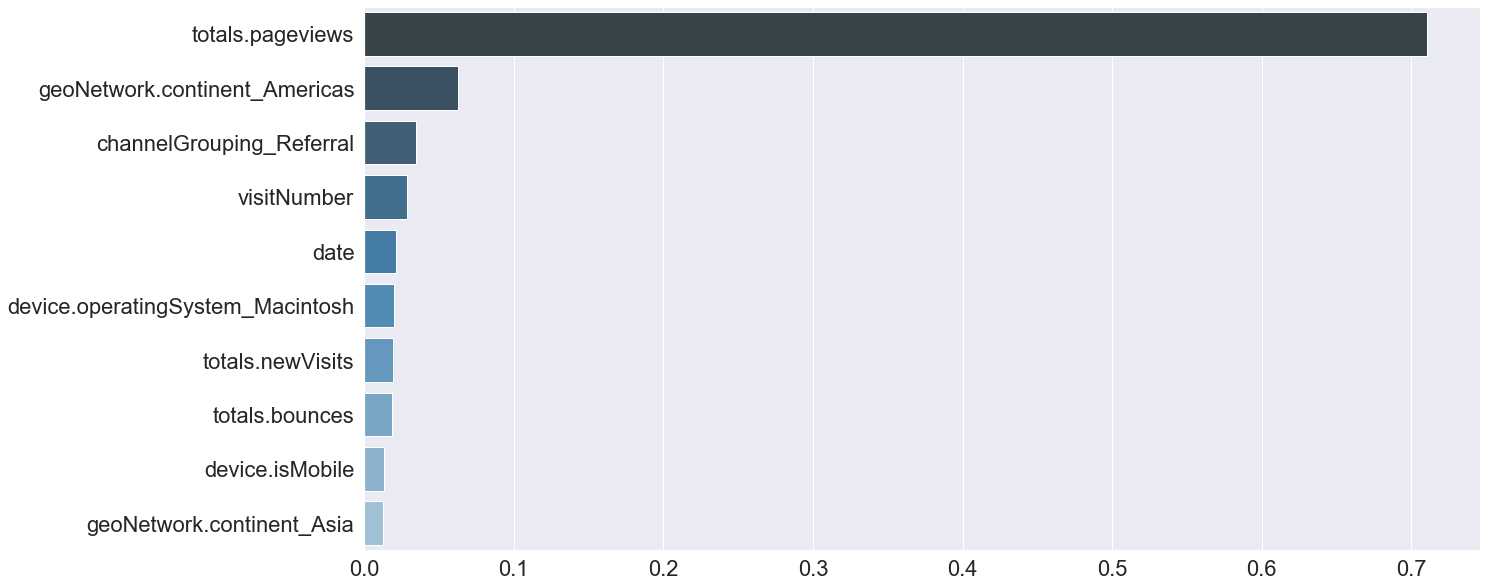

In [329]:
sns.barplot(y=importances_GB[0:10].index,x=importances_GB[0:10],palette="Blues_d")

### group by to user level

In [308]:
# to the last
X_train_visitor=X_train_visitor.groupby('visitorid').sum().reset_index()
X_train_visitor

visitorid  y_true  y_predict_1  y_predict_2  y_predict_3  \
0       0000010278554503158     0.0     0.381602     0.000000     0.381412   
1       0000020424342248747     0.0     1.040089     0.261664     1.039158   
2       0000040862739425590     0.0     0.239386     0.059196     0.240242   
3        000005103959234087     0.0     0.358876     0.088243     0.358750   
4       0000062267706107999     0.0     0.000000     0.000000     0.000000   
...                     ...     ...          ...          ...          ...   
521759  9999906724458612544     0.0     0.141899     0.000000     0.142114   
521760  9999963186378918199     0.0     0.000000     0.000000     0.000000   
521761   999997225970956660     0.0     0.000000     0.000000     0.000000   
521762   999997550040396460     0.0     0.124702     0.008094     0.125576   
521763  9999978264901065827     0.0     0.000000     0.000000     0.000000   

        y_predict_5  y_predict_6  
0          0.000000     0.000000  
1          0.146306     0.241326  
2          0.314759     0.000000  
3          0.166081     0.000000  
4          0.000000     0.000000  
...             ...          ...  
521759     0.000000     0.000000  
521760     0.000000     0.000000  
521761     0.013730     0.000000  
521762     0.090319     0.106611  
521763     0.018681     0.000000  

[521764 rows x 7 columns]

In [309]:
mean_squared_error(X_train_visitor.y_true,X_train_visitor.y_predict_1)**0.5

2.243176493473283

In [312]:
mean_squared_error(X_train_visitor.y_true,X_train_visitor.y_predict_2)**0.5

1.4303417507171396

In [311]:
mean_squared_error(X_train_visitor.y_true,X_train_visitor.y_predict_3)**0.5

2.2432481493270258

In [313]:
mean_squared_error(X_train_visitor.y_true,X_train_visitor.y_predict_5)**0.5

1.9536921191805978

In [314]:
mean_squared_error(X_train_visitor.y_true,X_train_visitor.y_predict_6)**0.5

1.964067035996672

In [315]:
X_test_visitor=X_test_visitor.groupby('visitorid').sum().reset_index()
X_test_visitor

visitorid  y_true  y_predict_1  y_predict_2  y_predict_3  \
0       0000027376579751715     0.0     0.187390     0.003211     0.187775   
1       0000039460501403861     0.0     0.000000     0.000000     0.000000   
2       0000068403966359845     0.0     0.000000     0.001237     0.000000   
3       0000114156543135683     0.0     0.000000     0.000000     0.000000   
4       0000152474579038632     0.0     0.000000     0.000000     0.000000   
...                     ...     ...          ...          ...          ...   
242570  9999773079368714197     0.0     0.000000     0.000035     0.000000   
242571  9999799804624735268     0.0     0.216822     0.010066     0.216955   
242572  9999944980984230465     0.0     0.000000     0.000000     0.000000   
242573  9999955365228667450     0.0     0.000000     0.002790     0.000000   
242574  9999986437109498564     0.0     0.000000     0.000000     0.000000   

        y_predict_5  y_predict_6  
0          0.000000     0.000000  
1          0.068903     0.000000  
2          0.056150     0.000000  
3          0.000000     0.010370  
4          0.024320     0.028034  
...             ...          ...  
242570     0.080589     0.017061  
242571     0.116032     0.018440  
242572     0.000000     0.004212  
242573     0.000000     0.000000  
242574     0.000000     0.000000  

[242575 rows x 7 columns]

In [319]:
mean_squared_error(X_test_visitor.y_true,X_test_visitor.y_predict_1)**0.5

2.014555453034187

In [316]:
mean_squared_error(X_test_visitor.y_true,X_test_visitor.y_predict_2)**0.5

1.8296166262849367

In [320]:
mean_squared_error(X_test_visitor.y_true,X_test_visitor.y_predict_3)**0.5

2.014605675596761

In [317]:
mean_squared_error(X_test_visitor.y_true,X_test_visitor.y_predict_5)**0.5

1.9245207933857447

In [318]:
mean_squared_error(X_test_visitor.y_true,X_test_visitor.y_predict_6)**0.5

1.8281004624670156

In [334]:
prediction_result=pd.read_csv('prediction_results.csv', engine='python',index_col=0)

In [335]:
prediction_result

Linear Regressor  Random Forest Regressor  Ridge Regressor  \
Models                                                                       
customer_level          2.014555                 1.829617         2.014606   

                XGBRegressor  GradientBoostingRegressor  
Models                                                   
customer_level      1.924521                     1.8281

### option 2 under sampling to balance datasets

In [201]:
revenue_df=copy.deepcopy(df_train)

revenue_df['has_revenue']=0
revenue_df.loc[revenue_df['log_revenue']>0,'has_revenue']=1

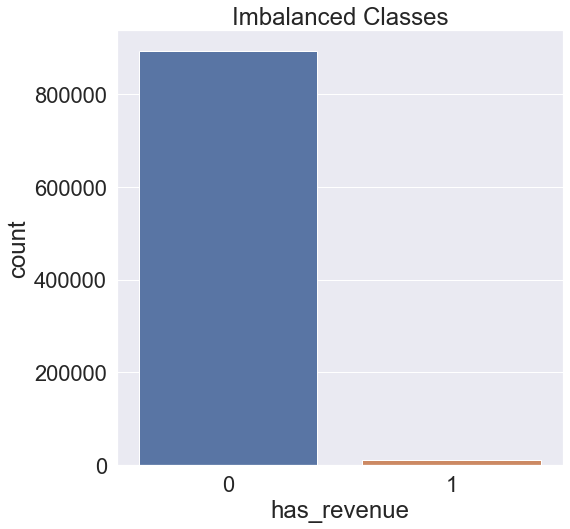

In [203]:
plt.figure(figsize=(8, 8))
sns.countplot('has_revenue', data=revenue_df)
plt.title('Imbalanced Classes')
plt.show()

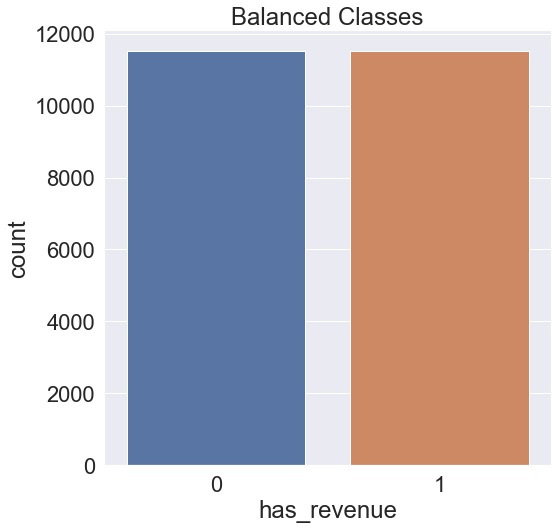

In [101]:
# Shuffle the Dataset.
shuffled_df = df_train.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.
revenue_df = shuffled_df.loc[shuffled_df['log_revenue']>0]

#Randomly select 492 observations from the non-fraud (majority class)
non_revenue_df = shuffled_df.loc[shuffled_df['log_revenue'] == 0].sample(n=len_revenue,random_state=42)

# Concatenate both dataframes again
balanced_df = pd.concat([revenue_df, non_revenue_df])
balanced_df['has_revenue']=0
balanced_df.loc[balanced_df['log_revenue']>0,'has_revenue']=1

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('has_revenue', data=balanced_df)
plt.title('Balanced Classes')
plt.show()

In [ ]:
balanced_df.drop('has_revenue',axis=1,inplace=True)

In [109]:
X_temp=balanced_df.drop('log_revenue',axis=1)
y=balanced_df['log_revenue'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X=pd.DataFrame(X_values,columns=X_temp.columns)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=3)

In [116]:
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

### balanced dataset by group

In [117]:
labels_unique=X['labels'].unique()
y_predict1_train=np.zeros_like(y_train)
y_predict1_test=np.zeros_like(y_test)
models1=[]
modelsname1=[]
for label in labels_unique:
    model1 = LinearRegression()
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model1.fit(df_x_train,y_2)
    models1.append(model1)
    modelsname1.append(label)
    y_predict1_train[index_train]=model1.predict(df_x_train)
    y_predict1_test[index_test]=model1.predict(df_x_test)

models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [118]:
mean_squared_error(y_train,y_predict1_train)**0.5

3.701686725769976

In [119]:
mean_squared_error(y_test,y_predict1_test)**0.5

5345251129.413643

### model 2 by group

In [145]:
labels_unique=X['labels'].unique()
y_predict2_train=np.zeros_like(y_train)
y_predict2_test=np.zeros_like(y_test)
models2=[]
modelsname2=[]
for label in labels_unique:
    model2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=3, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)
    index_train=X_train[X_train.labels==label].index
    index_test=X_test[X_test.labels==label].index
    df_x_train=X_train[X_train.index.isin(index_train)].drop('labels',axis=1)
    y_2=y_train[y_train.index.isin(index_train)]
    df_x_test=X_test[X_test.index.isin(index_test)].drop('labels',axis=1)
    model2.fit(df_x_train,y_2)
    models2.append(model2)
    modelsname2.append(label)
    y_predict2_train[index_train]=model2.predict(df_x_train)
    y_predict2_test[index_test]=model2.predict(df_x_test)

#models_linear={mn:m for mn,m in zip(modelsname1,models1)}

In [146]:
mean_squared_error(y_train,y_predict2_train)**0.5

1.4508568446831458

In [147]:
mean_squared_error(y_test,y_predict2_test)**0.5

1.6597923892879107

## hurdle regression

In [140]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

class HurdleLinearRegression():
    """Implements linear regression with a hurdle at 0.
    """

    def __init__(self):
        self.logistic = LogisticRegression()
        self.linear = LinearRegression()

    def fit(self, X, y):
        self.logistic.fit(X, y>0)
        self.linear.fit(X[y>0], y[y>0])
        return self

    def predict(self, X):
        p = self.logistic.predict_proba(X)[:,1]
        y_hat = self.linear.predict(X)
        return p * y_hat

In [141]:
model6=HurdleLinearRegression()
model6.fit(X_train,y_train)
ypredict6_train=model6.predict(X_train)
ypredict6_test=model6.predict(X_test)

In [142]:
mean_squared_error(y_train,ypredict6_train)**0.5

1.8041499897799824

In [143]:
mean_squared_error(y_train,ypredict6_train)**0.5

1.8041499897799824

### regression for with revenue

In [130]:
revenue_df=df_train[df_train['log_revenue']>0]#.drop('labels',axis=1)

In [131]:
revenue_df.iloc[:,11:]

channelGrouping_Direct  channelGrouping_Display  \
752                          1                        0   
753                          0                        0   
799                          0                        0   
802                          0                        0   
859                          0                        0   
...                        ...                      ...   
903302                       0                        0   
903305                       0                        0   
903314                       0                        0   
903315                       1                        0   
903317                       1                        0   

        channelGrouping_Organic Search  channelGrouping_Paid Search  \
752                                  0                            0   
753                                  1                            0   
799                                  0                            0   
802                                  0                            0   
859                                  0                            0   
...                                ...                          ...   
903302                               0                            0   
903305                               0                            0   
903314                               0                            0   
903315                               0                            0   
903317                               0                            0   

        channelGrouping_Referral  channelGrouping_Social  \
752                            0                       0   
753                            0                       0   
799                            1                       0   
802                            1                       0   
859                            1                       0   
...                          ...                     ...   
903302                         1                       0   
903305                         1                       0   
903314                         1                       0   
903315                         0                       0   
903317                         0                       0   

        device.browser_Firefox  device.operatingSystem_Macintosh  \
752                          0                                 0   
753                          0                                 1   
799                          0                                 0   
802                          0                                 0   
859                          0                                 1   
...                        ...                               ...   
903302                       0                                 1   
903305                       0                                 1   
903314                       0                                 1   
903315                       1                                 1   
903317                       0                                 0   

        device.operatingSystem_Windows  device.deviceCategory_mobile  \
752                                  0                             0   
753                                  0                             0   
799                                  0                             0   
802                                  1                             0   
859                                  0                             0   
...                                ...                           ...   
903302                               0                             0   
903305                               0                             0   
903314                               0                             0   
903315                               0                             0   
903317                               0                             1   

        device.deviceCategory_tablet  geoNe

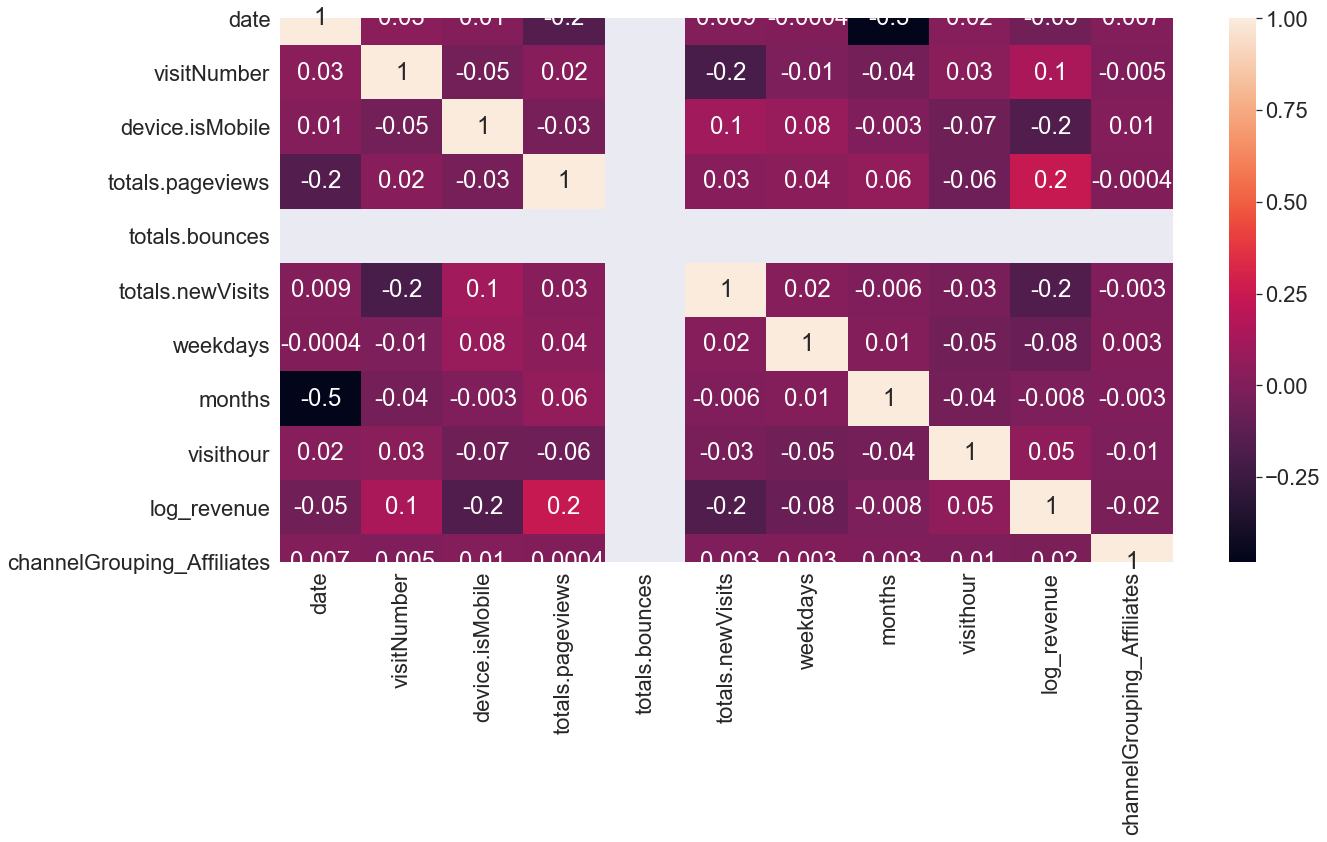

In [132]:
corr=revenue_df.iloc[:,:11].corr()
sns.heatmap(corr,annot=True,fmt='.1g')

In [133]:
X_temp=revenue_df.drop('log_revenue',axis=1)
y_revenue=revenue_df['log_revenue'].reset_index(drop=True)
scaler=MinMaxScaler()
X_values=scaler.fit_transform(X_temp)
X_revenue=pd.DataFrame(X_values,columns=X_temp.columns)

In [134]:
model1 = LinearRegression()
model1.fit(X_revenue,y_revenue)
ypredict1_train=model1.predict(X_revenue)

In [135]:
mean_squared_error(y_revenue,ypredict1_train)**0.5

1.1058896543090802

In [136]:
coeff_df = pd.DataFrame(model1.coef_, X_revenue.columns, columns=['Coefficient'])  
coeff_df.round(2).sort_values(by='Coefficient',ascending=False)

Coefficient
totals.pageviews                         6.45
visitNumber                              3.04
device.isMobile                          1.67
geoNetwork.continent_Africa              1.39
channelGrouping_Direct                   1.15
channelGrouping_Display                  1.08
channelGrouping_Referral                 0.87
channelGrouping_Paid Search              0.83
channelGrouping_Organic Search           0.74
channelGrouping_Social                   0.42
channelGrouping_Affiliates               0.32
visithour                                0.16
device.operatingSystem_Macintosh         0.09
trafficSource.isTrueDirect_False         0.03
source_other                             0.02
totals.bounces                          -0.00
device.operatingSystem_Windows          -0.12
date                                    -0.12
months                                  -0.12
device.browser_Firefox                  -0.19
weekdays                                -0.25
totals.newVisits                        -0.36
geoNetwork.continent_Oceania            -0.40
geoNetwork.continent_Asia               -0.44
source_youtube                          -0.52
geoNetwork.continent_Americas           -0.63
geoNetwork.continent_Europe             -0.76
device.deviceCategory_tablet            -2.01
device.deviceCategory_mobile            -2.22

## data exploration

### target variable

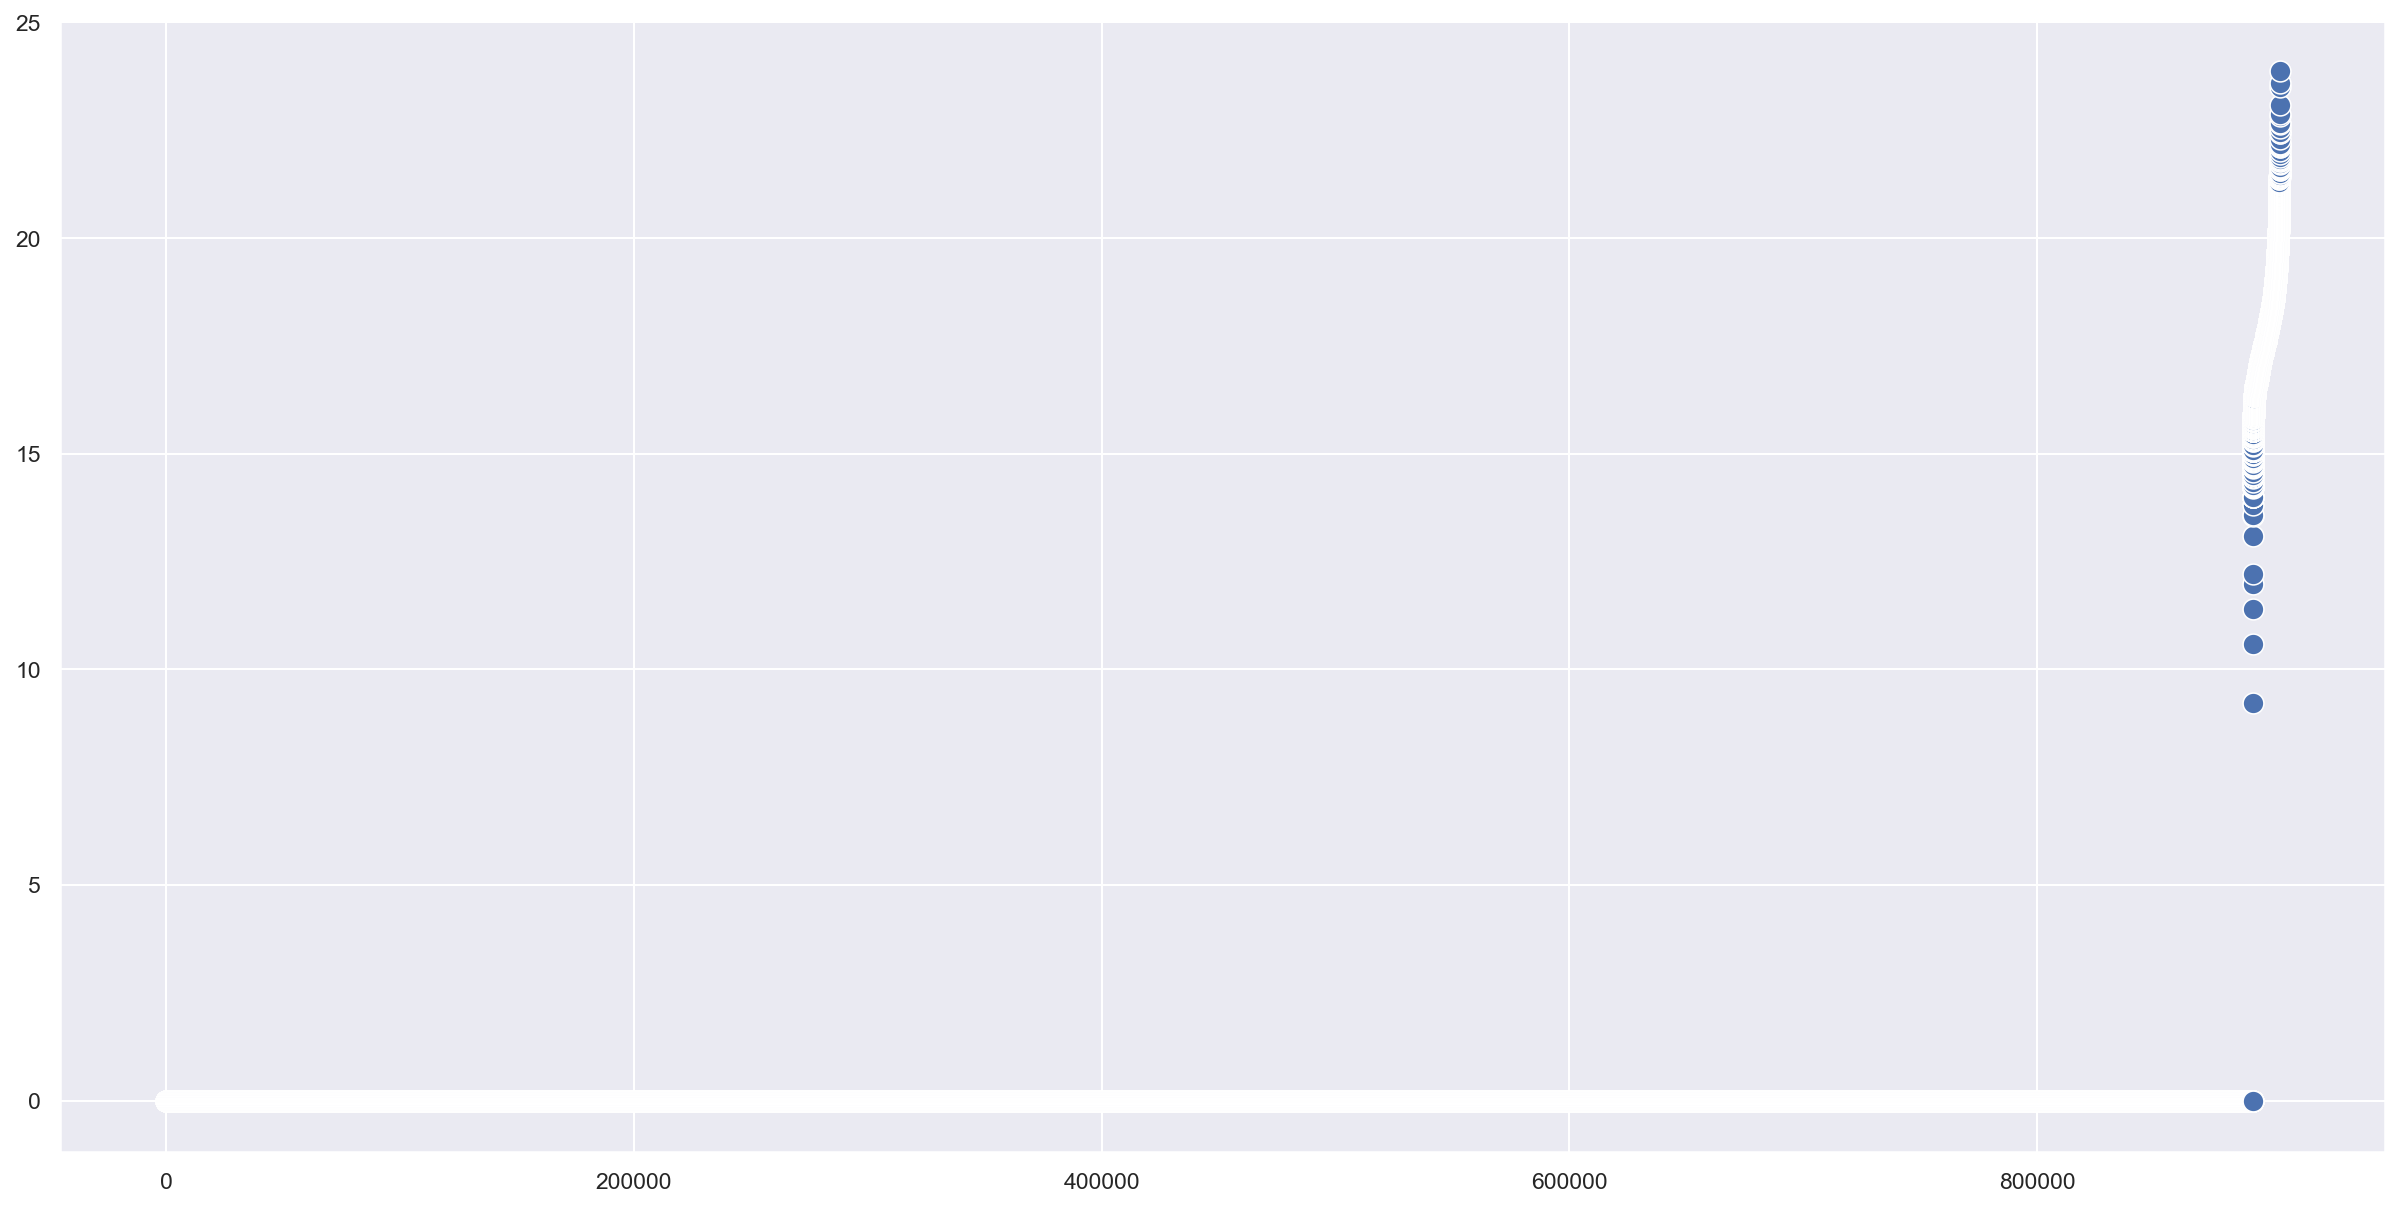

In [60]:
sns.scatterplot(range(train_df.shape[0]),np.sort(np.log1p(train_df['totals.transactionRevenue'].fillna(0))),s=100,edgecolors='none')

In [77]:
user=train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
len(user[user['totals.transactionRevenue']>0])/len(user['totals.transactionRevenue'])

0.013996726255903731

only 1.3% of the people generate revenue.

In [65]:
train_df['log_revenue']=np.log1p(train_df['totals.transactionRevenue'].fillna(0))

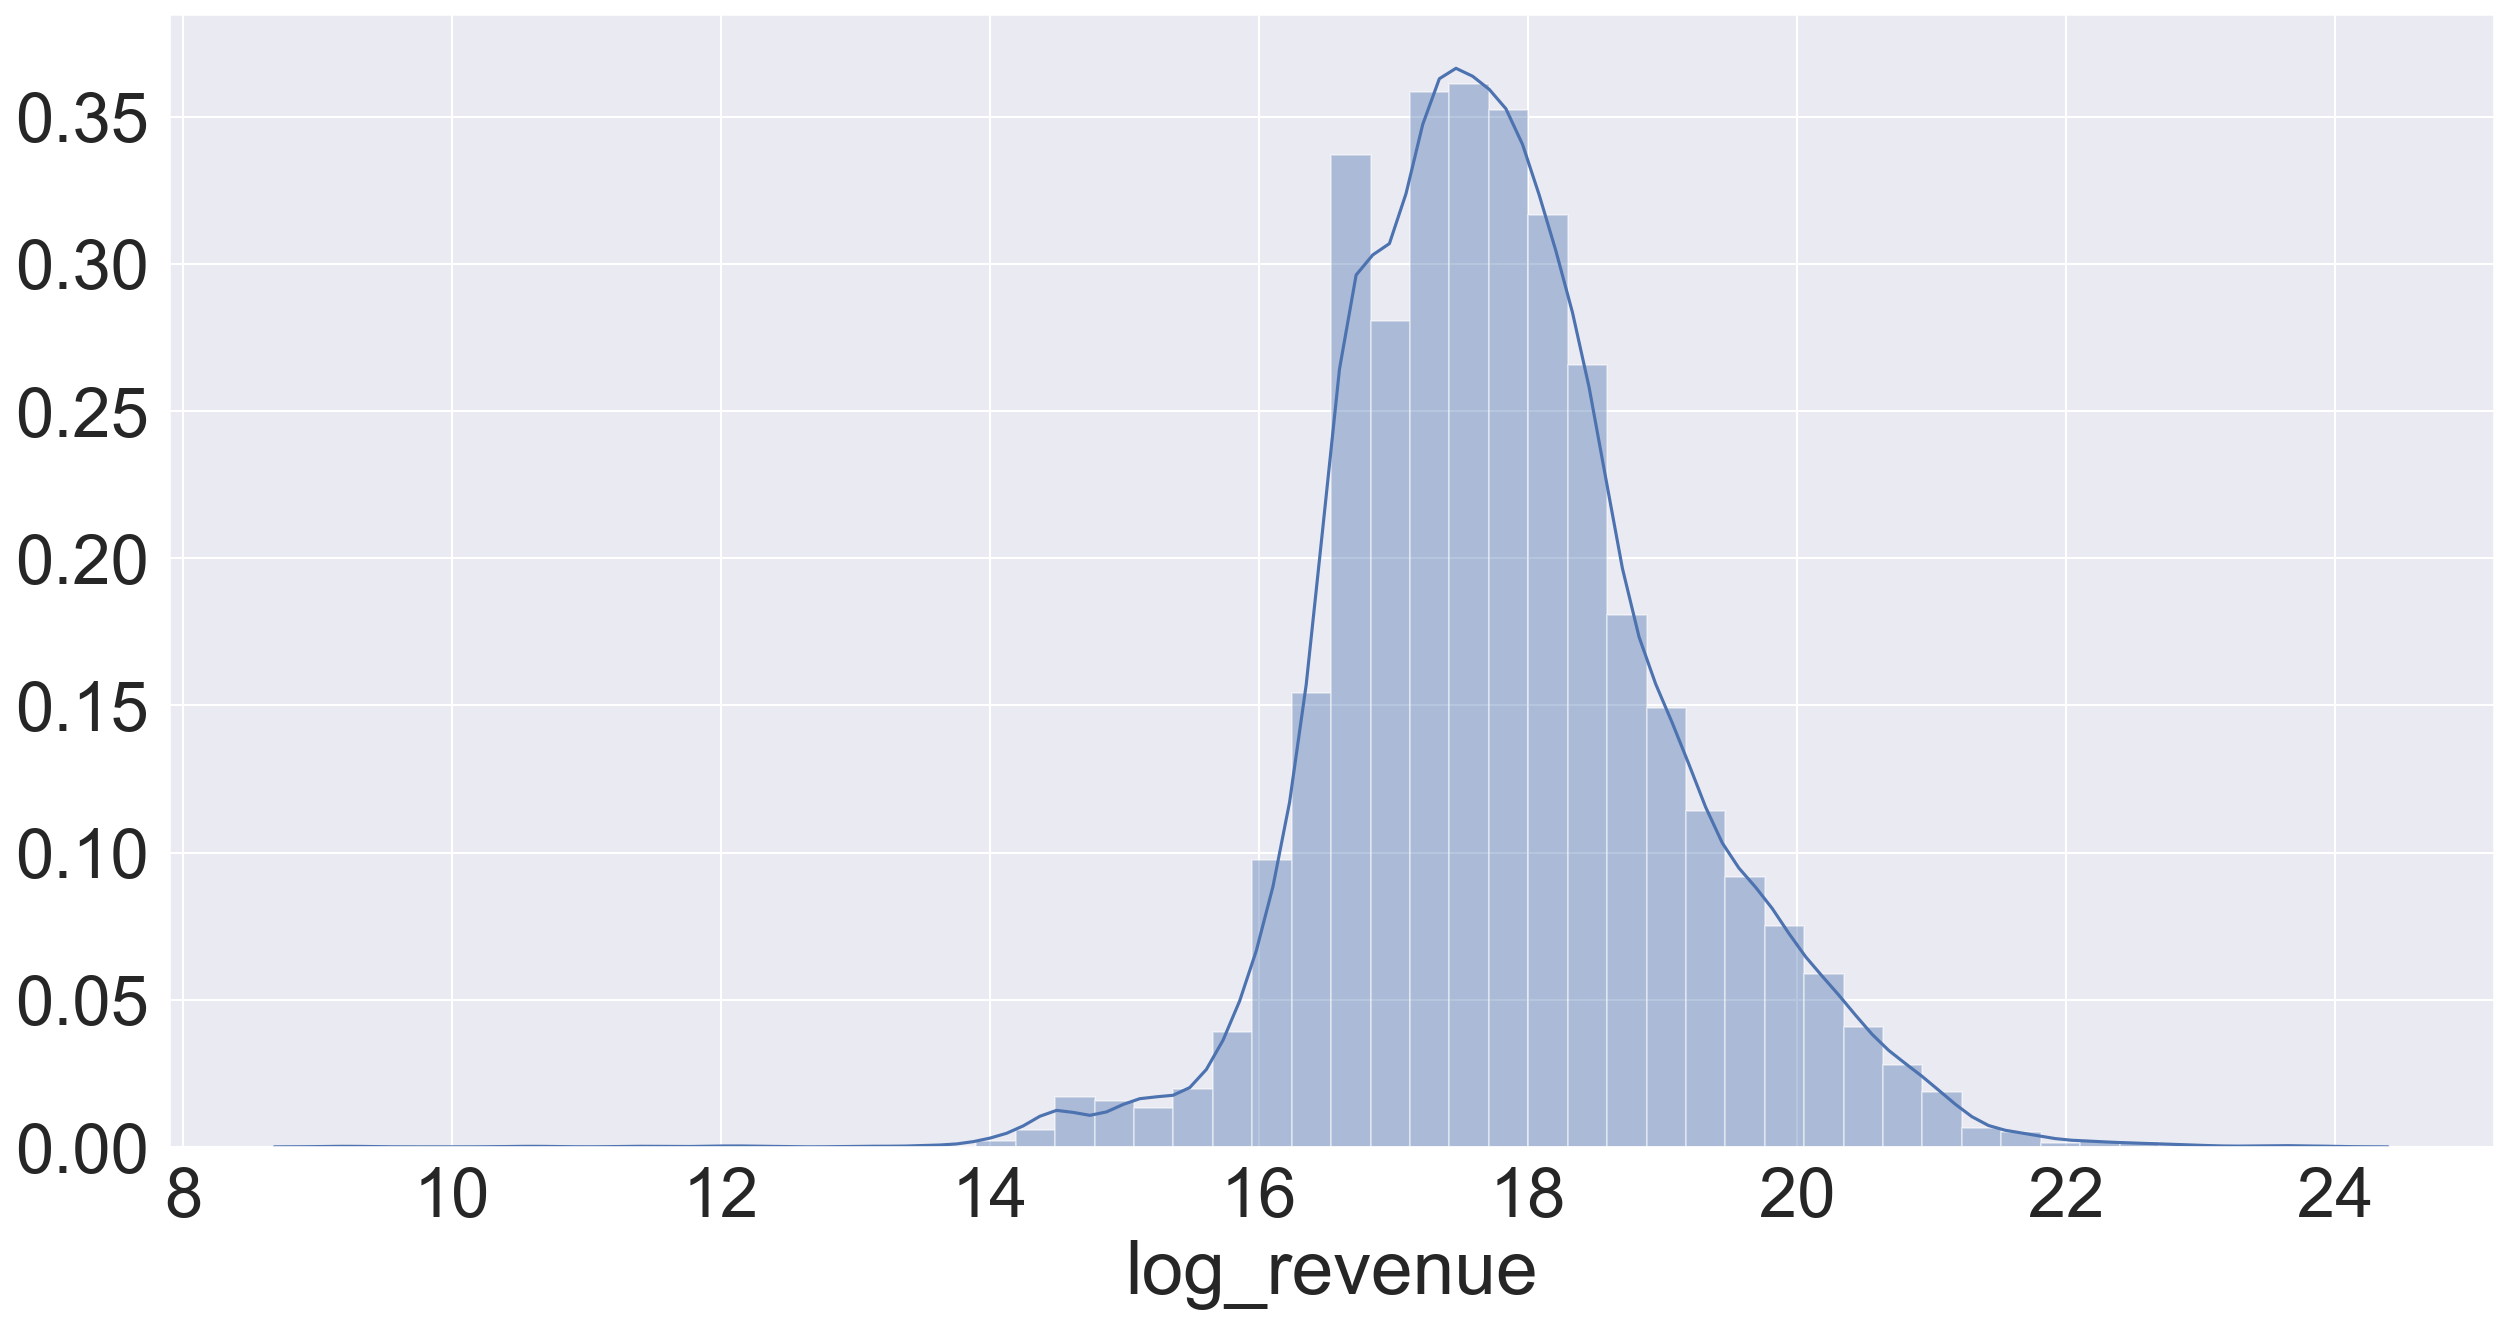

In [88]:
sns.distplot(train_df['log_revenue'][train_df['log_revenue']>0])

In [91]:
skew(train_df['log_revenue'][train_df['log_revenue']>0])

0.33752306602147514

In [90]:
kurtosis(train_df['log_revenue'][train_df['log_revenue']>0])

1.1610188903215466

skew is not 0 but 0.3 and kurtosis is >1 imply that not perfectly normal distributed. may need transformation.

## Explore

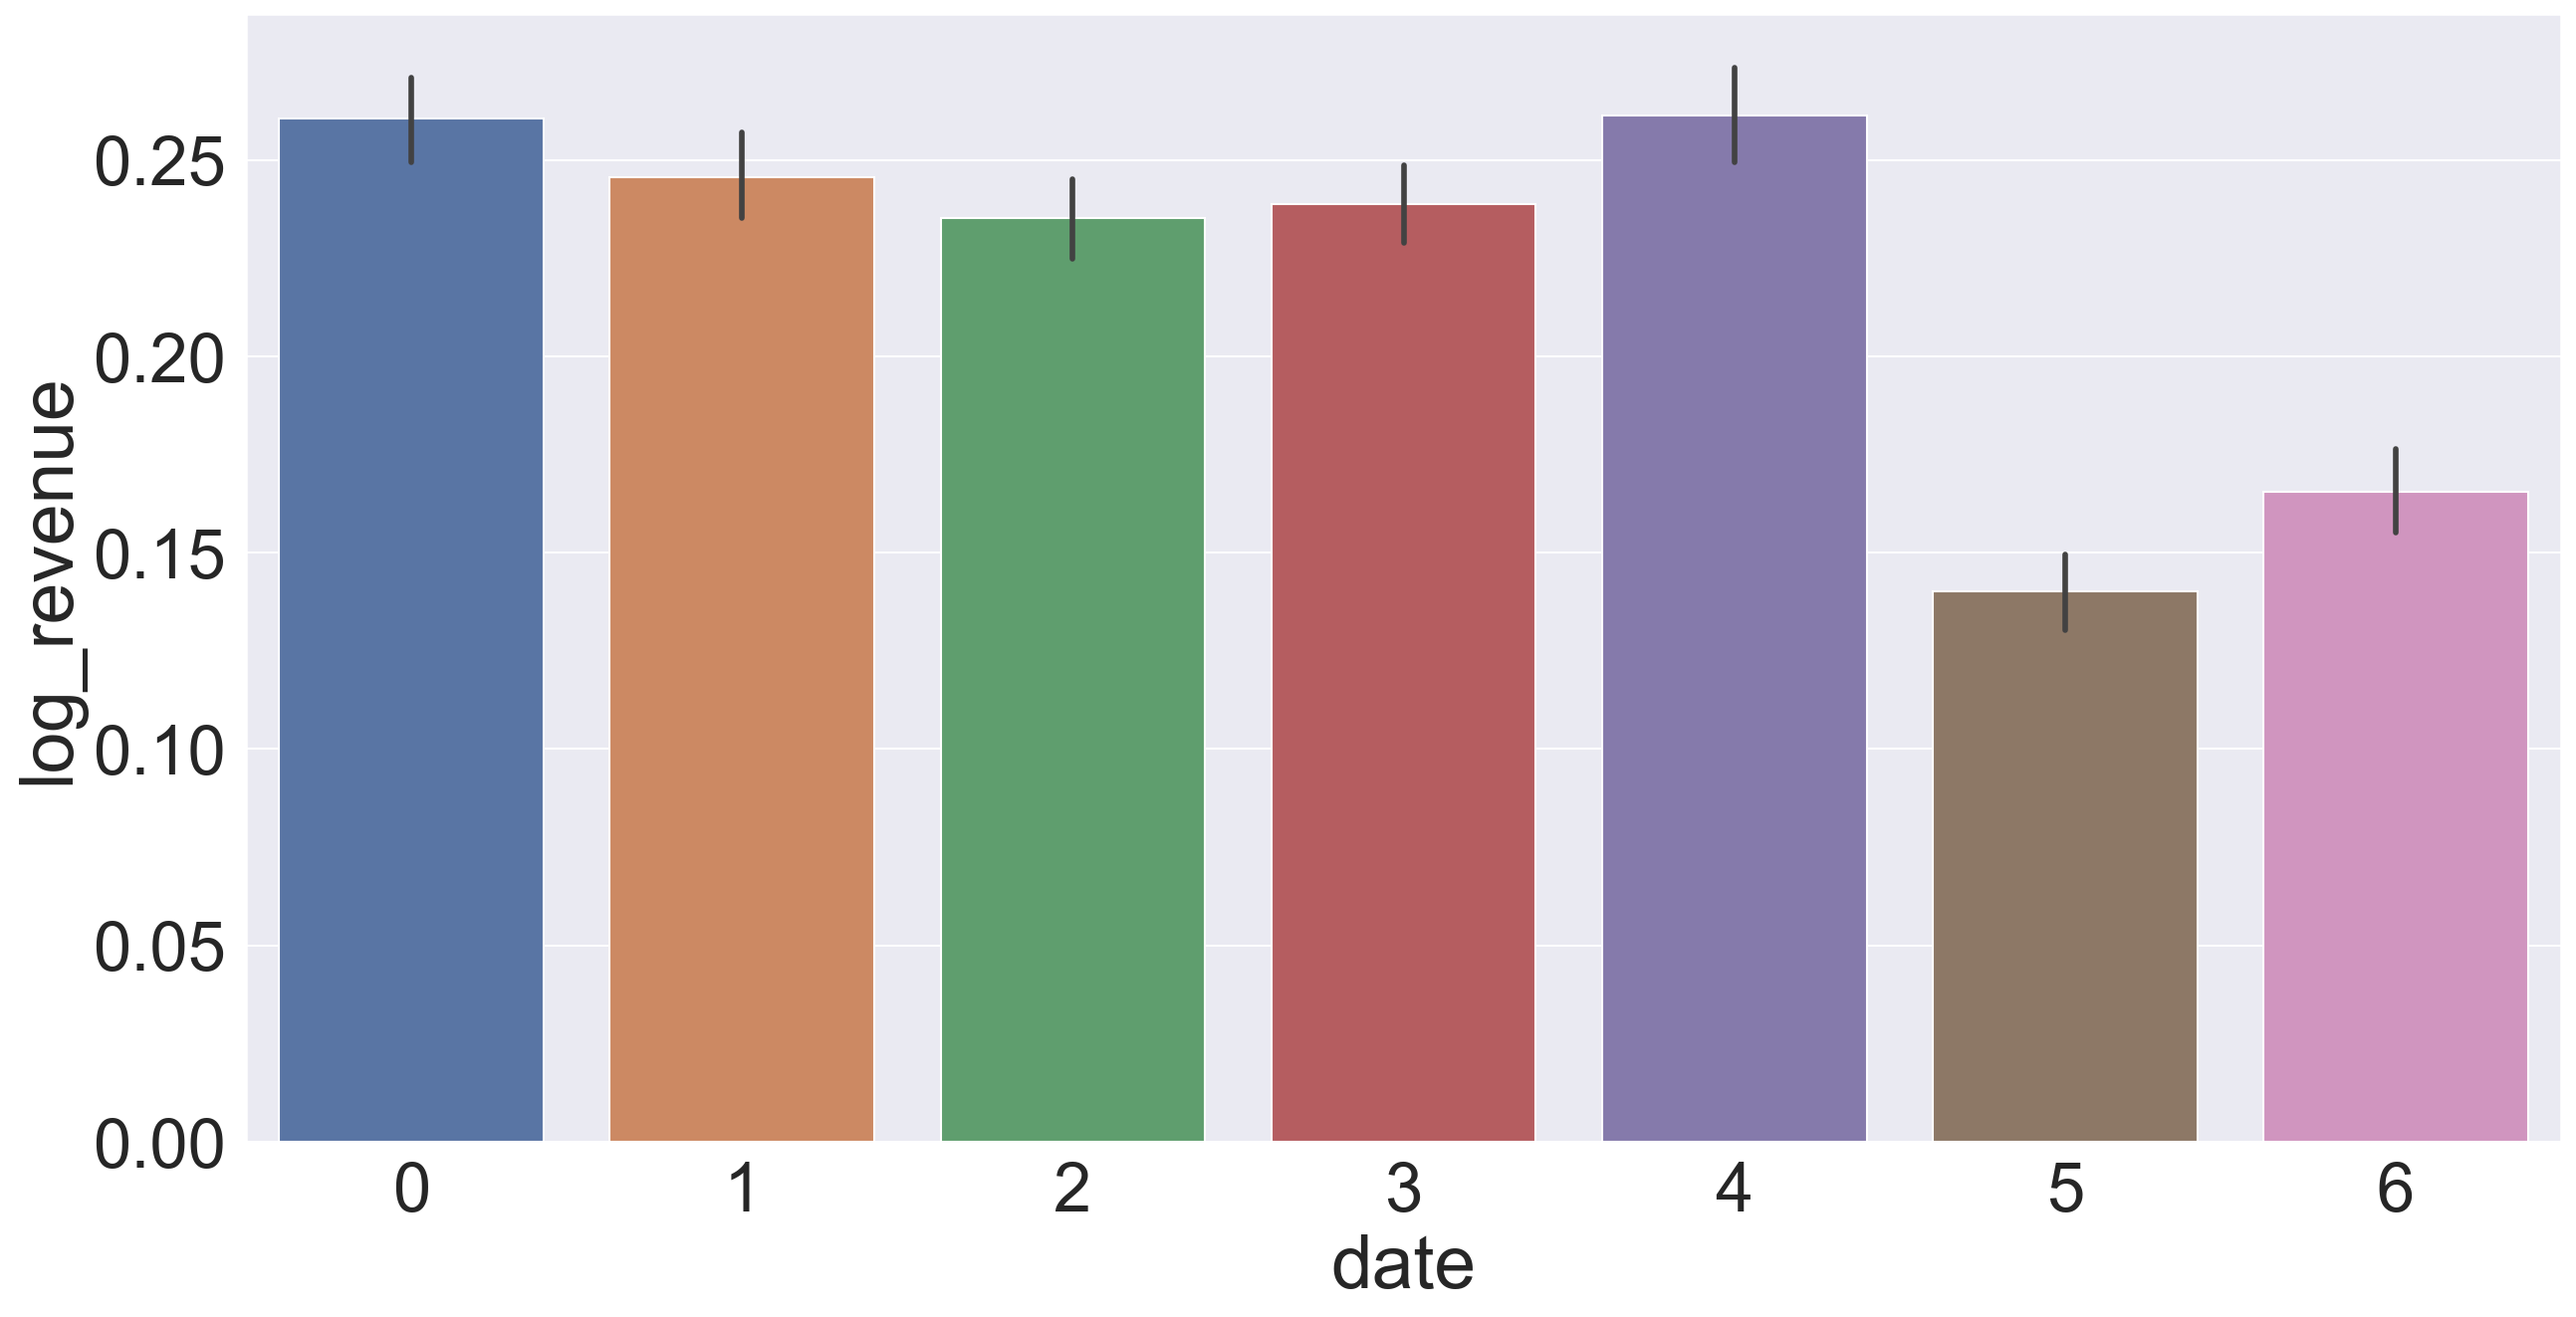

In [98]:
sns.barplot(train_df['date'].dt.weekday,train_df['log_revenue'])

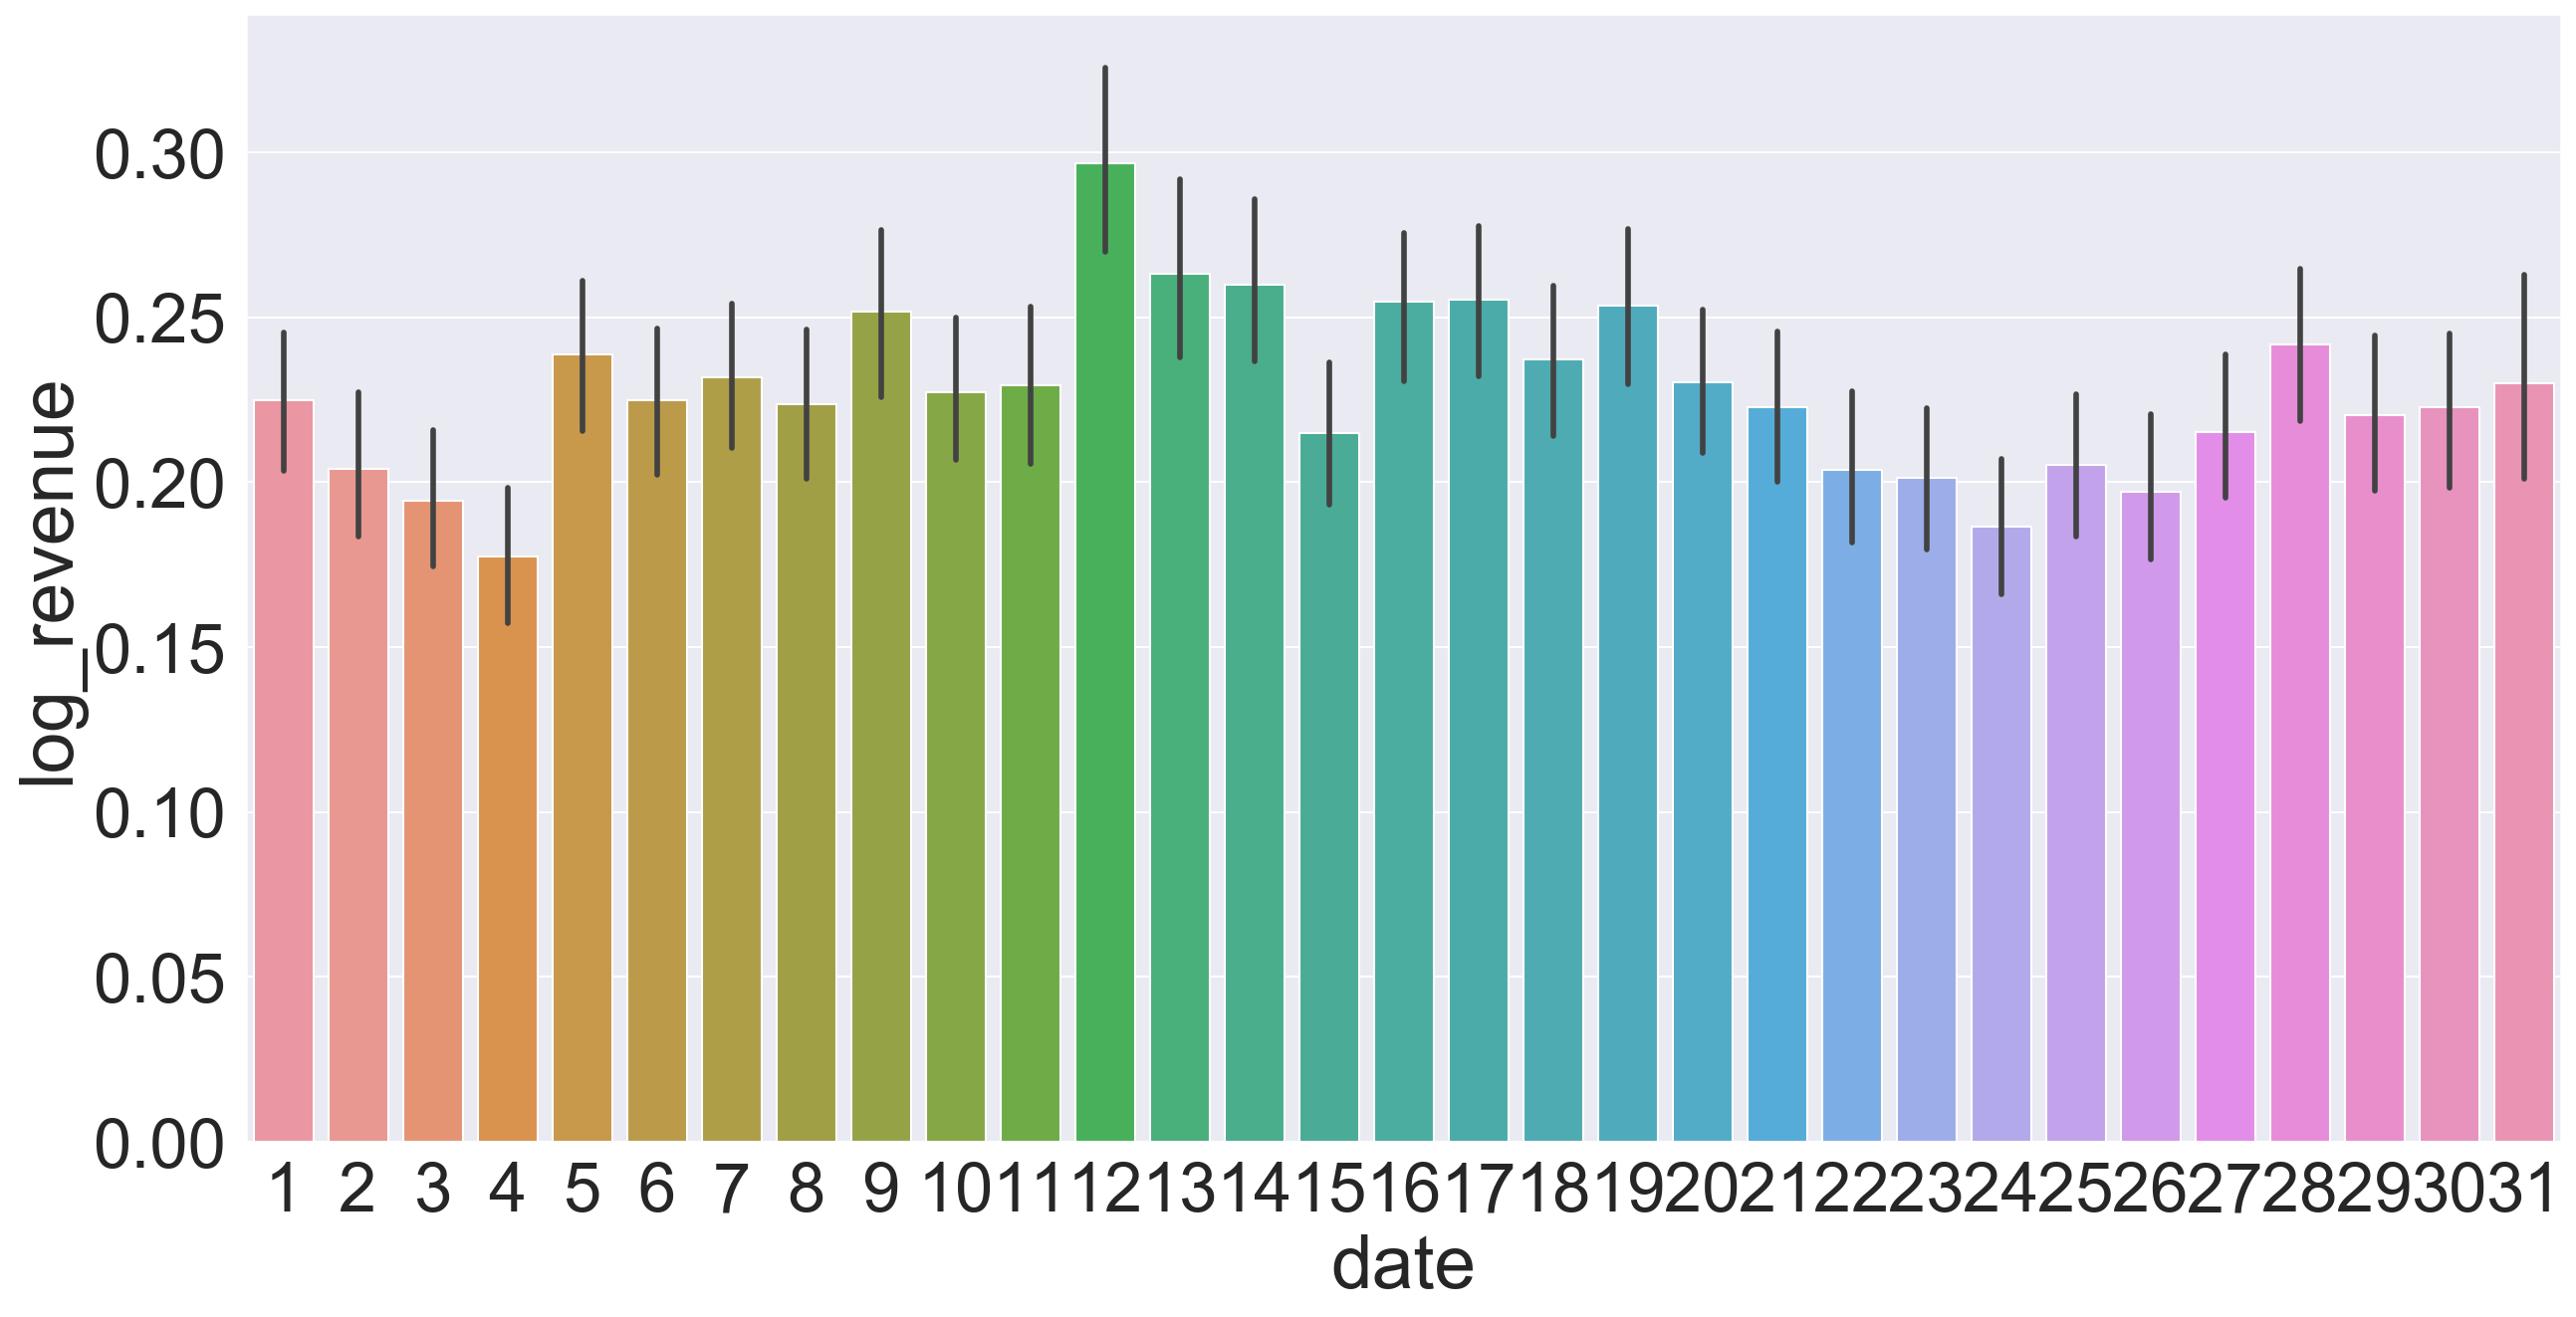

In [99]:
sns.barplot(train_df['date'].dt.day,train_df['log_revenue'])

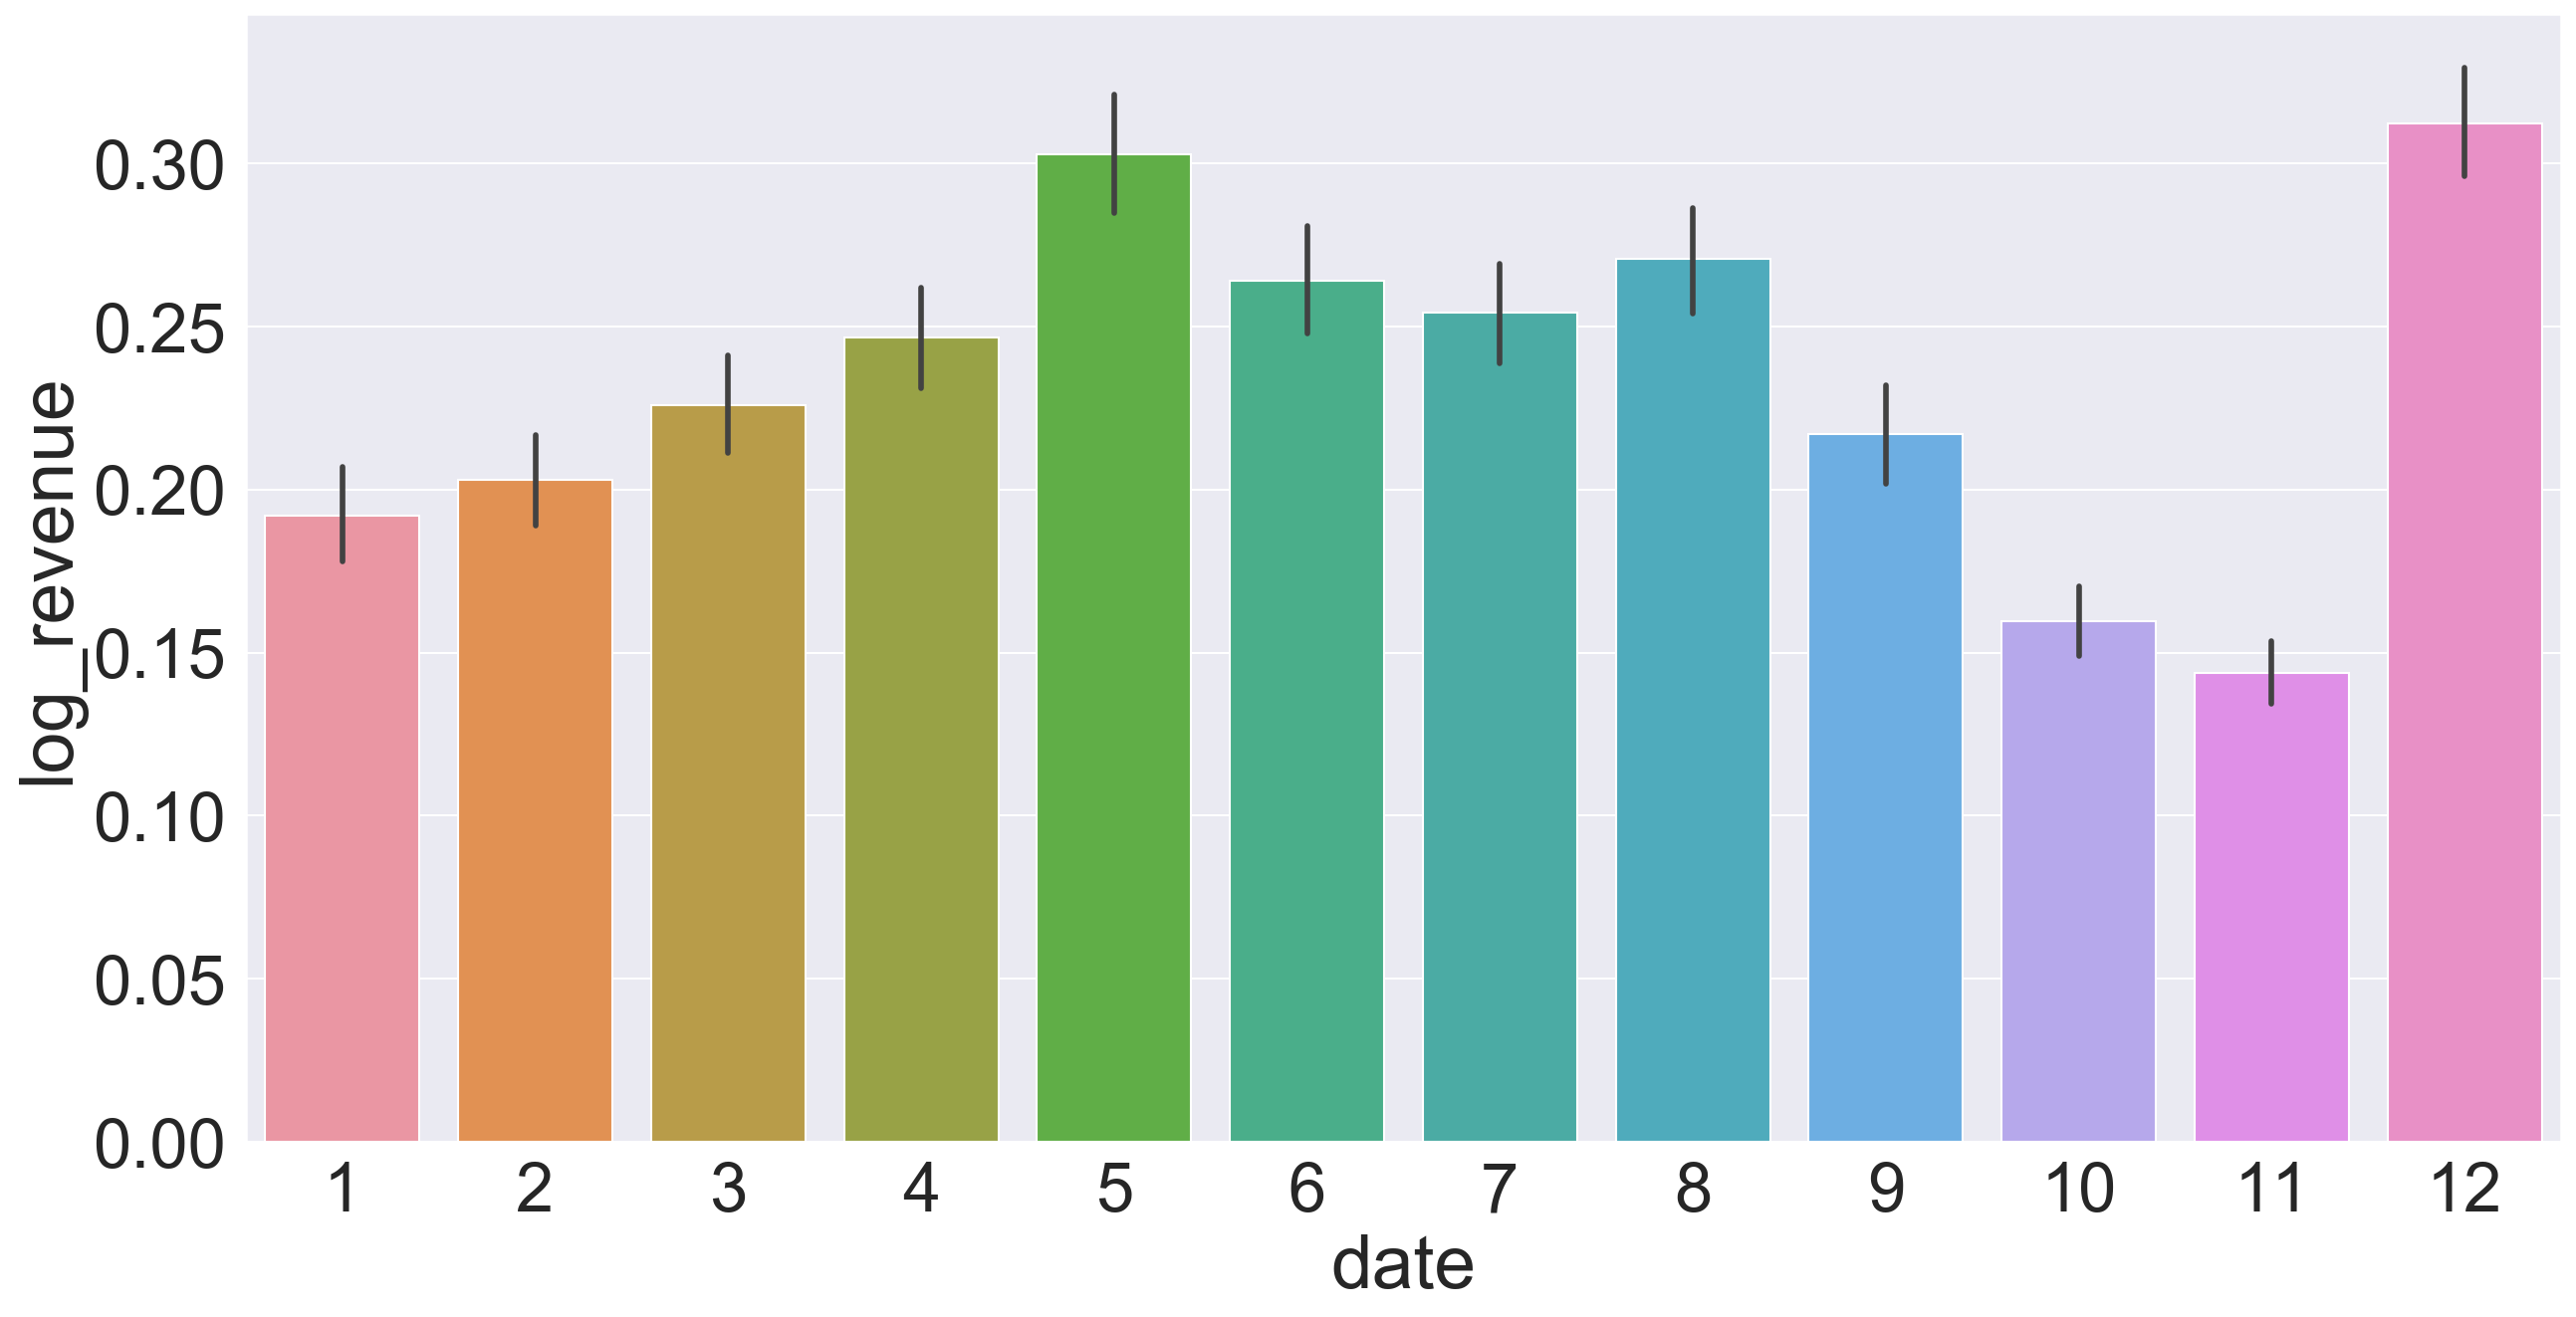

In [100]:
sns.barplot(train_df['date'].dt.month,train_df['log_revenue'])

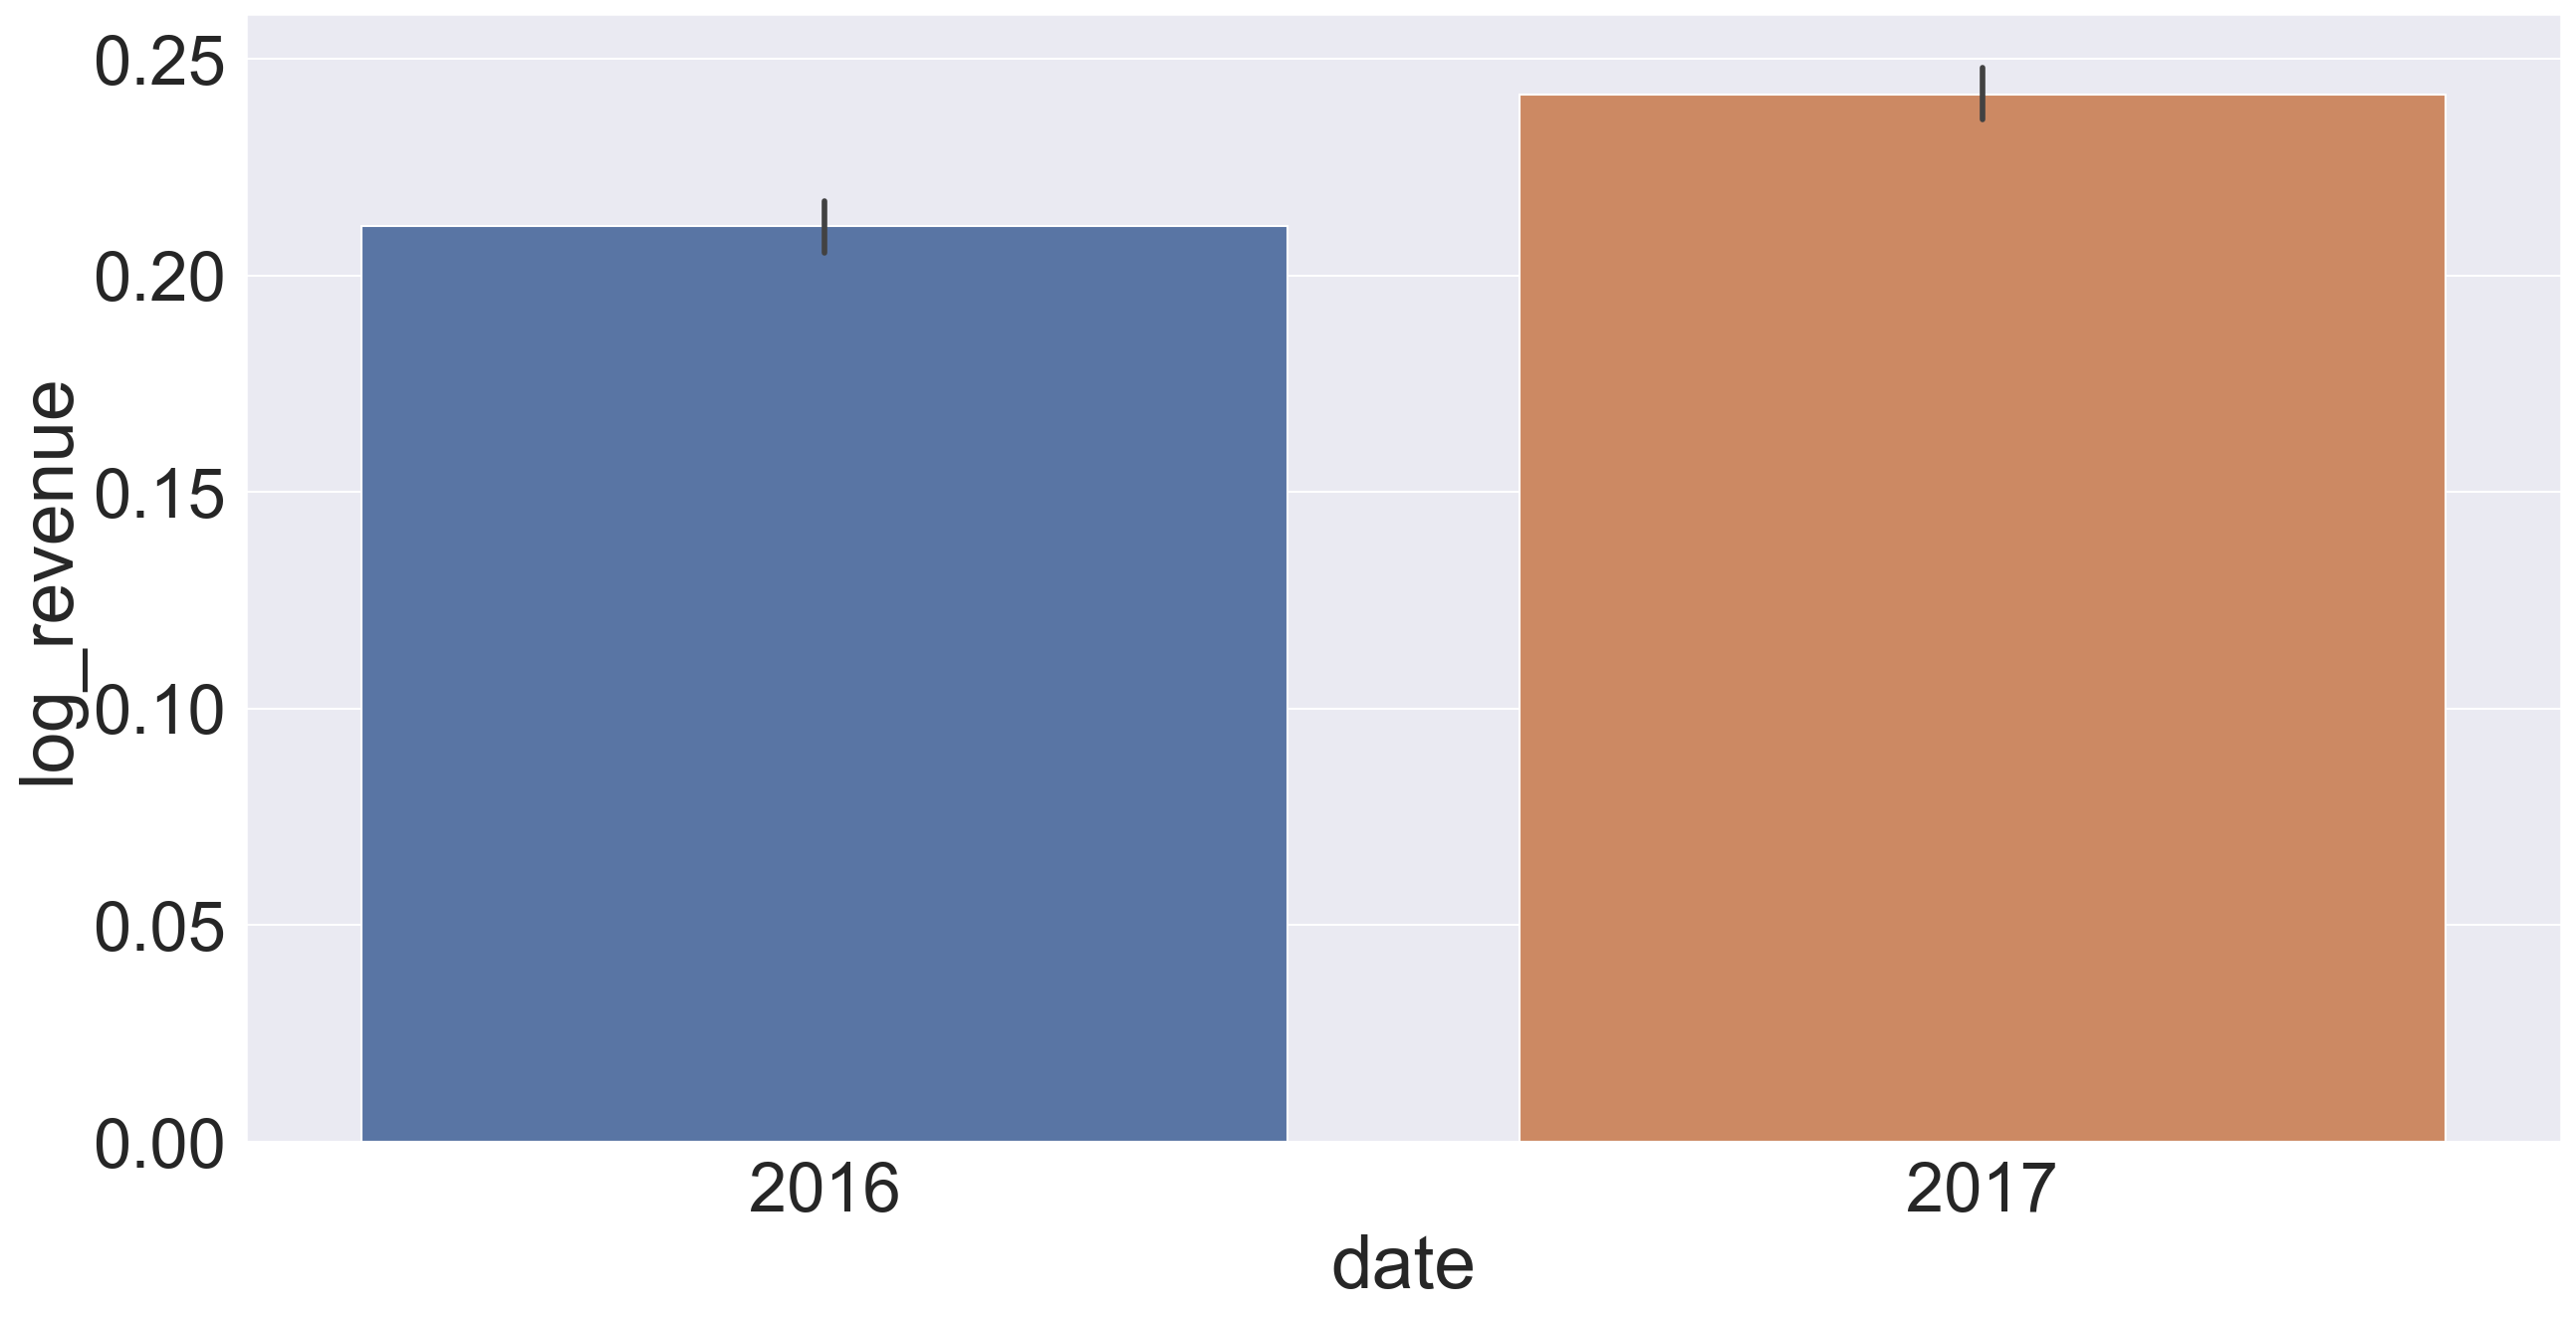

In [101]:
sns.barplot(train_df['date'].dt.year,train_df['log_revenue'])

In [103]:
train_df['date'].describe()

count                  903653
unique                    366
top       2016-11-28 00:00:00
freq                     4807
first     2016-08-01 00:00:00
last      2017-08-01 00:00:00
Name: date, dtype: object

2 years data

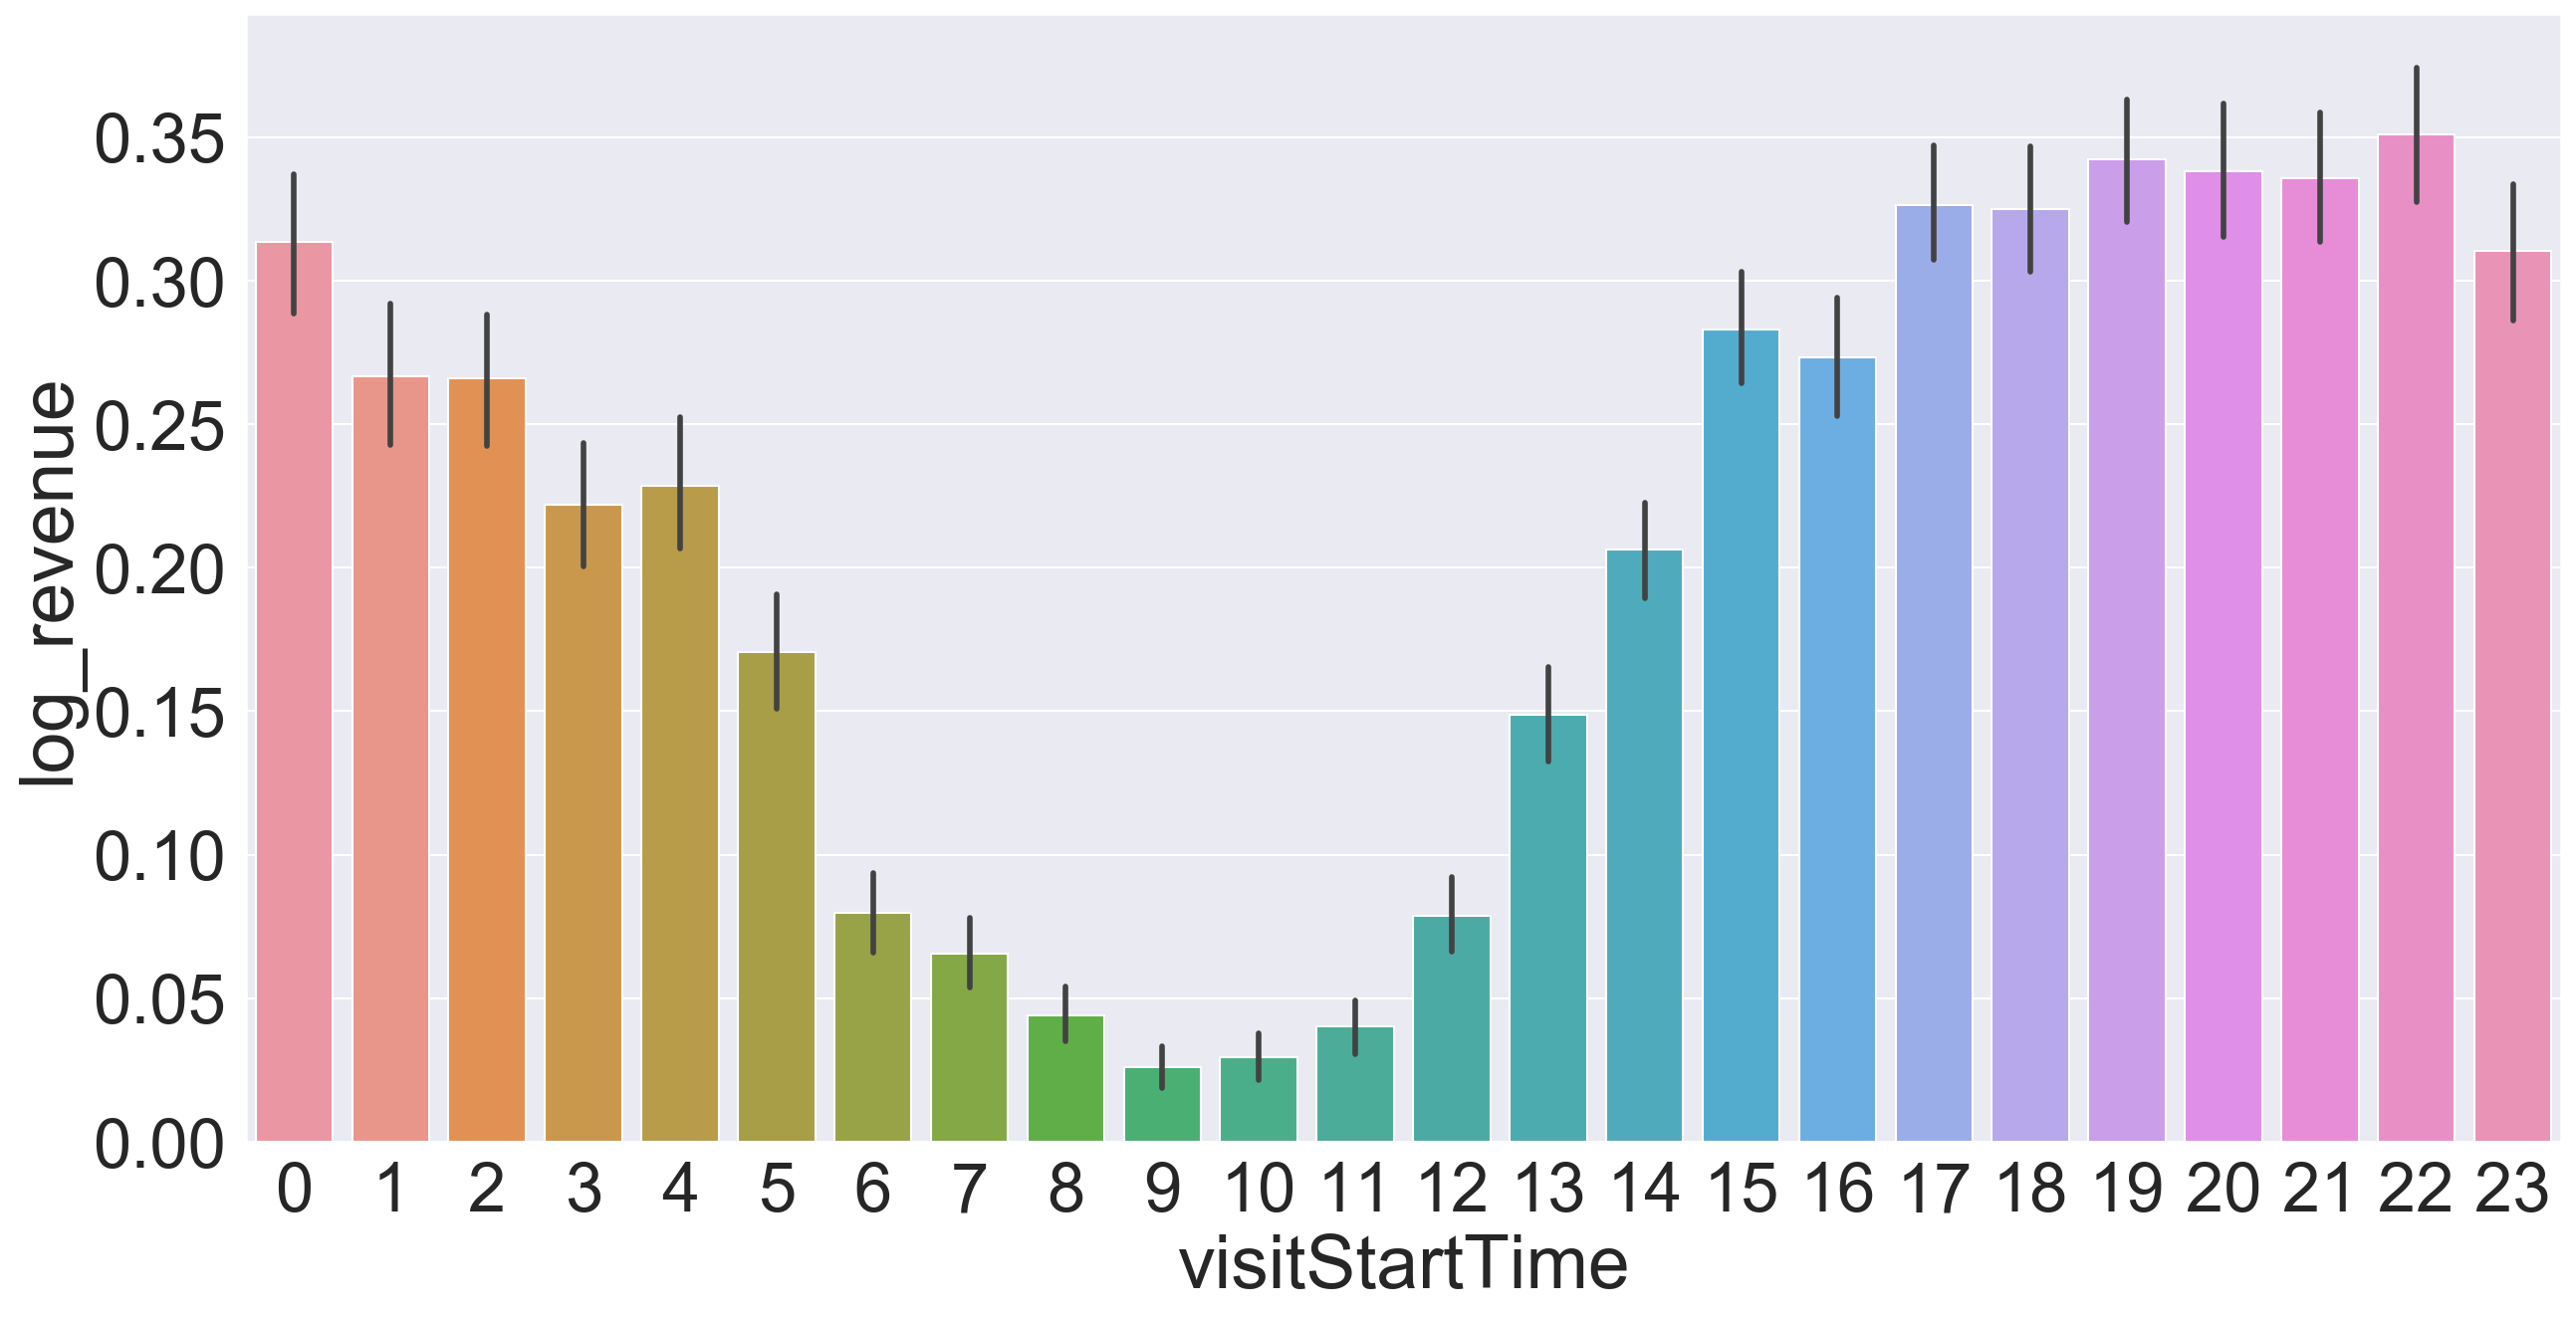

In [110]:
sns.barplot(train_df['visitStartTime'].dt.hour,train_df['log_revenue'])

time is obvious a important factor to revenue generation. 

In [151]:
user_visit=train_df.groupby('visitNumber')['log_revenue'].sum().sort_values(ascending=False)

In [154]:
user_visit[user_visit!=0].head(5)

visitNumber
1    78409.125380
2    44597.528491
3    25627.984480
4    15794.452918
5    10045.605279
Name: log_revenue, dtype: float64

In [235]:
def plot_by(col):
    a=train_df.loc[:,[col,'log_revenue']]
    a['log_revenue']=a['log_revenue'].replace(0,np.nan)
    b=a.groupby(col)['log_revenue'].agg(['size','count','sum','mean']).sort_values(by='sum',ascending=False) 
    b.columns=['sessions','sessions_revenue','log_revenue','mean_log_revenue/user']
    
    fig,axes=plt.subplots(4, figsize=(12,20))
    sns.barplot(x=b['sessions'].head(10),y=b.index[:10],ax=axes[0])
    sns.barplot(x=(b['sessions']/b['sessions_revenue']).head(10),y=b.index[:10],ax=axes[1])
    axes[1].title.set_text('sessions generated revenue')
    sns.barplot(x=b['log_revenue'].head(10),y=b.index[:10],ax=axes[2])
    sns.barplot(x=b['mean_log_revenue/user'].head(10),y=b.index[:10],ax=axes[3])
    fig.tight_layout()
    return b

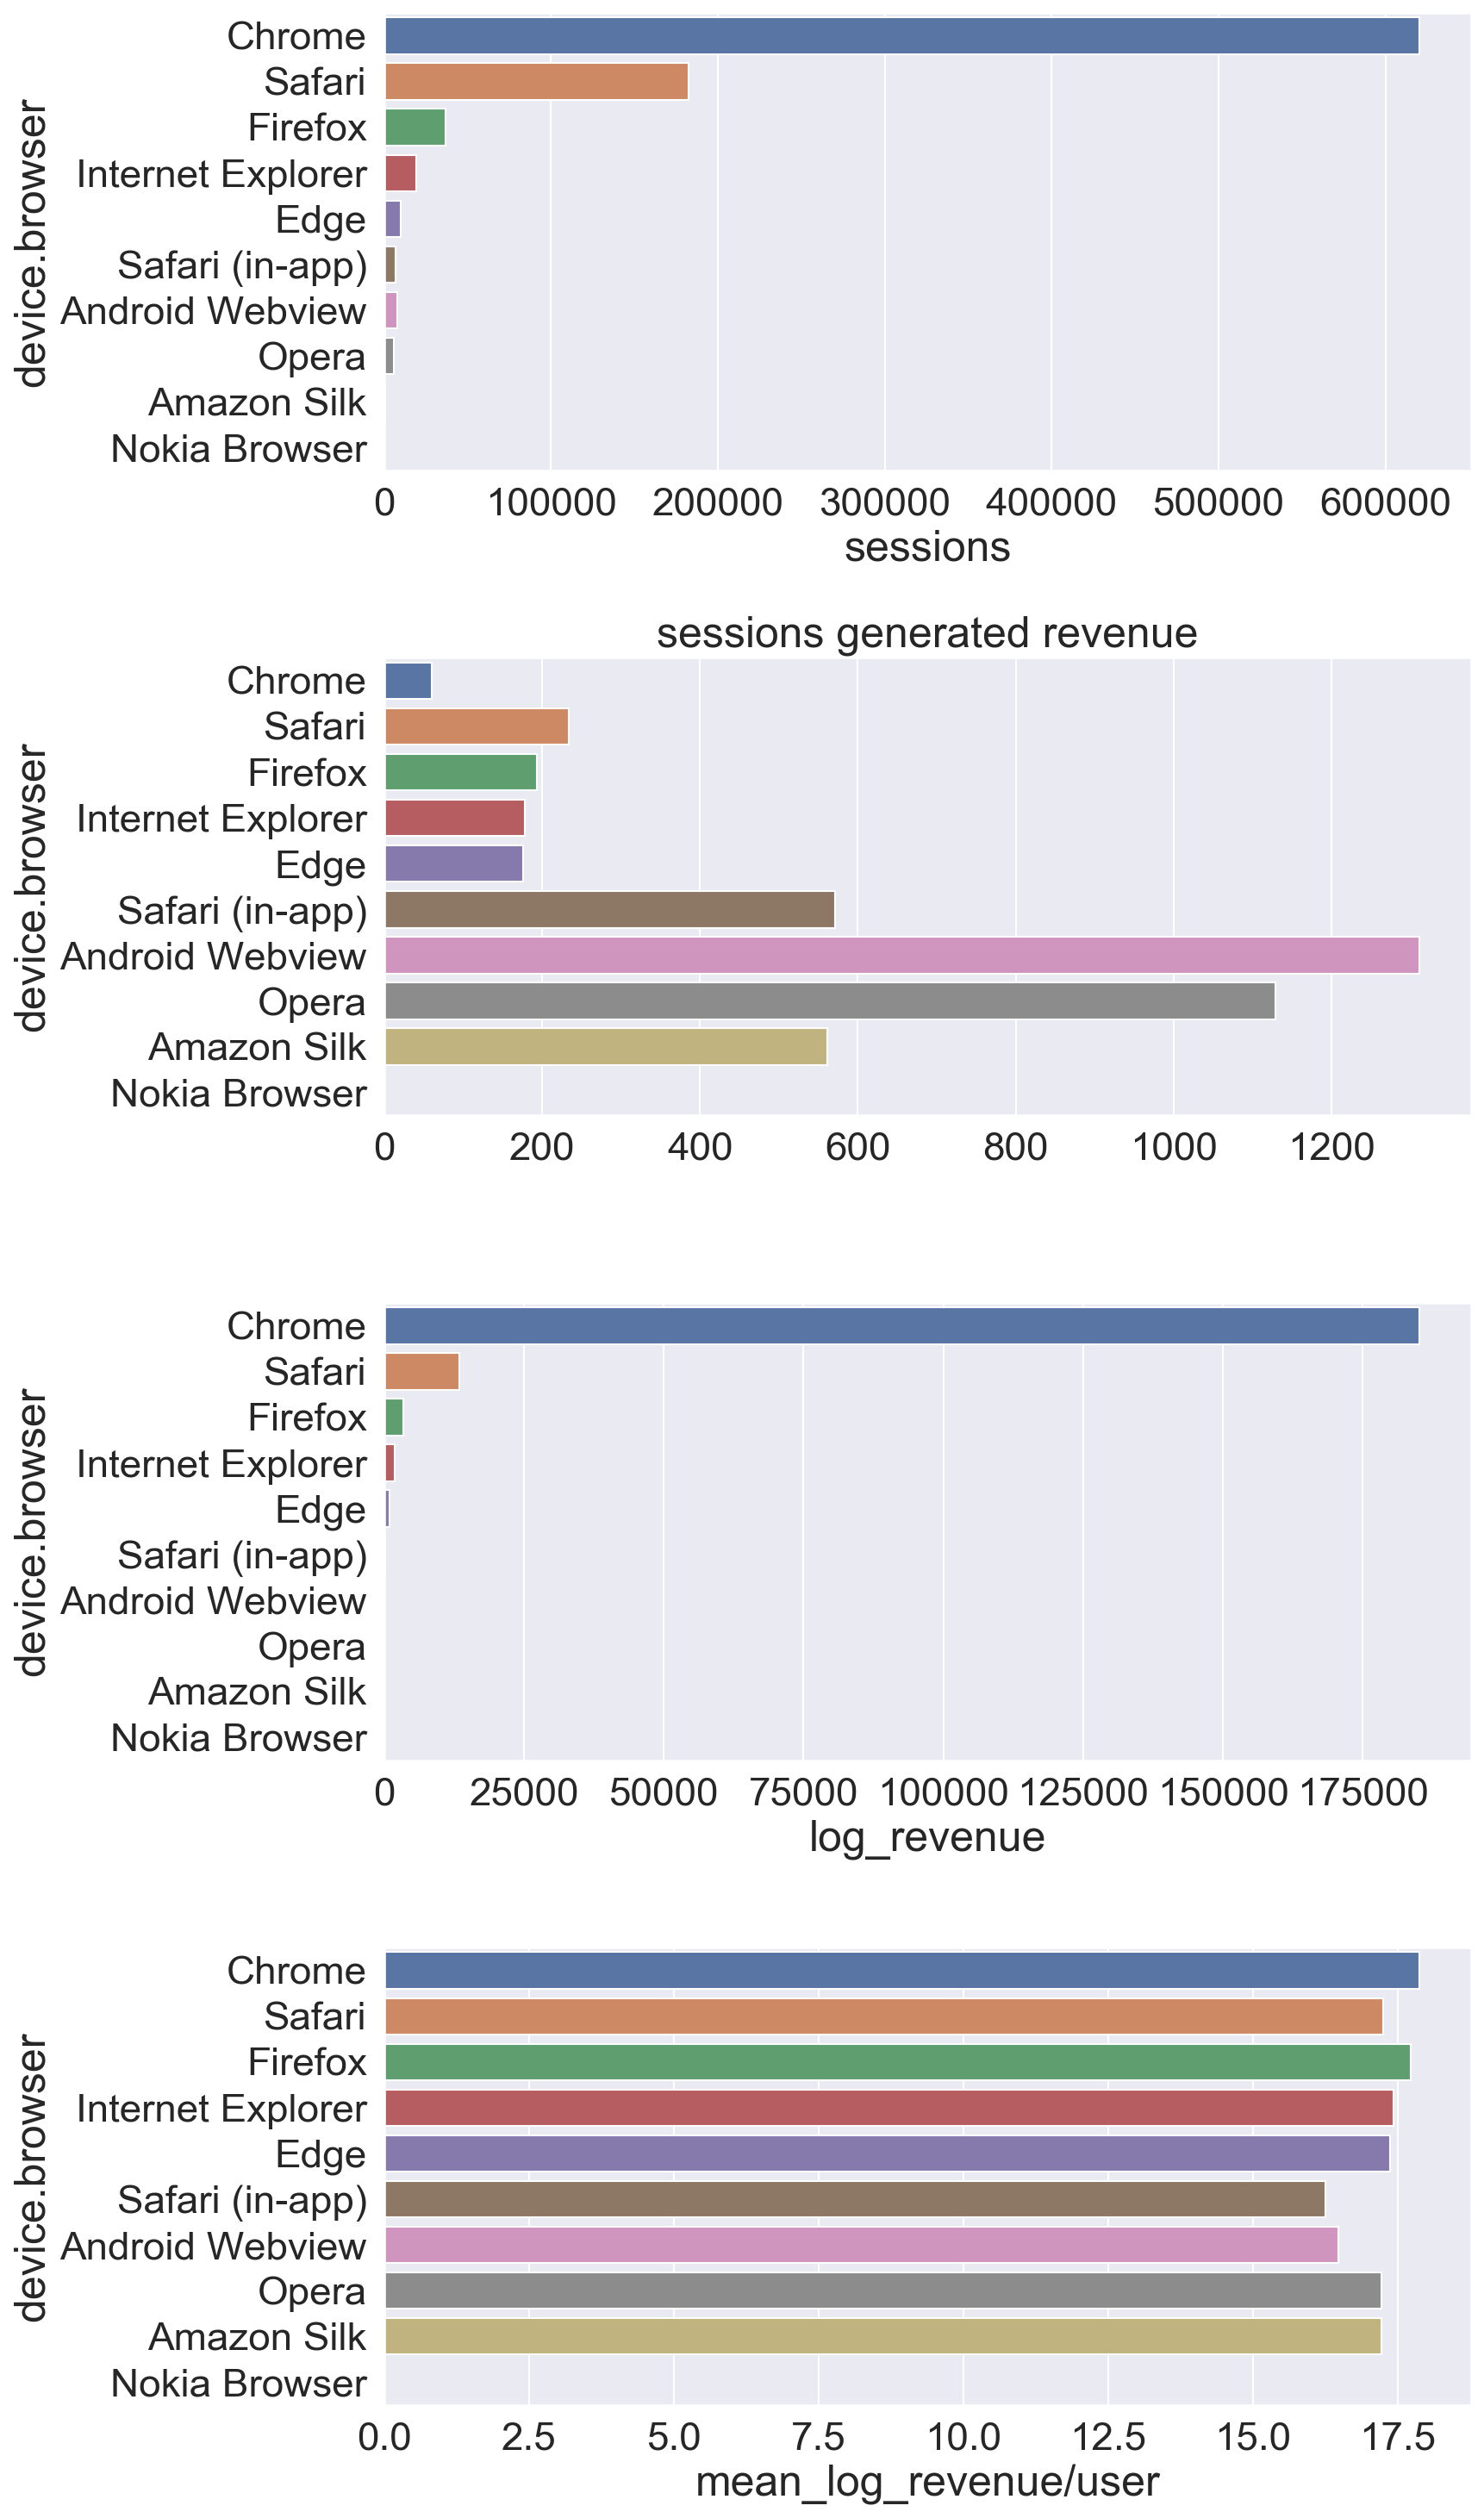

In [236]:
plot_by('device.browser')  #small variables

sessions  sessions_revenue    log_revenue  \
device.operatingSystem                                              
Macintosh                 253938              6426  115248.854295   
Windows                   350072              2309   40986.012093   
Chrome OS                  26337               994   18104.075116   
Linux                      35034               782   13665.501392   
iOS                       107665               536    9149.268965   
Android                   123892               467    8065.216182   
Windows Phone               1216                 1      17.088875   
Nokia                          2                 0       0.000000   
Xbox                          66                 0       0.000000   
SunOS                          1                 0       0.000000   
Samsung                      280                 0       0.000000   
OpenBSD                        2                 0       0.000000   
(not set)                   4695                 0       0.000000   
Nintendo WiiU                 35                 0       0.000000   
Nintendo 3DS                   1                 0       0.000000   
NTT DoCoMo                     1                 0       0.000000   
FreeBSD                        9                 0       0.000000   
Firefox OS                    89                 0       0.000000   
BlackBerry                   218                 0       0.000000   
Nintendo Wii                 100                 0       0.000000   

                        mean_log_revenue/user  
device.operatingSystem                         
Macintosh                           17.934773  
Windows                             17.750547  
Chrome OS                           18.213355  
Linux                               17.475066  
iOS                                 17.069532  
Android                             17.270270  
Windows Phone                       17.088875  
Nokia                                     NaN  
Xbox                                      NaN  
SunOS                                     NaN  
Samsung                                   NaN  
OpenBSD                                   NaN  
(not set)                                 NaN  
Nintendo WiiU                             NaN  
Nintendo 3DS                              NaN  
NTT DoCoMo                                NaN  
FreeBSD                                   NaN  
Firefox OS                                NaN  
BlackBerry                                NaN  
Nintendo Wii                              NaN

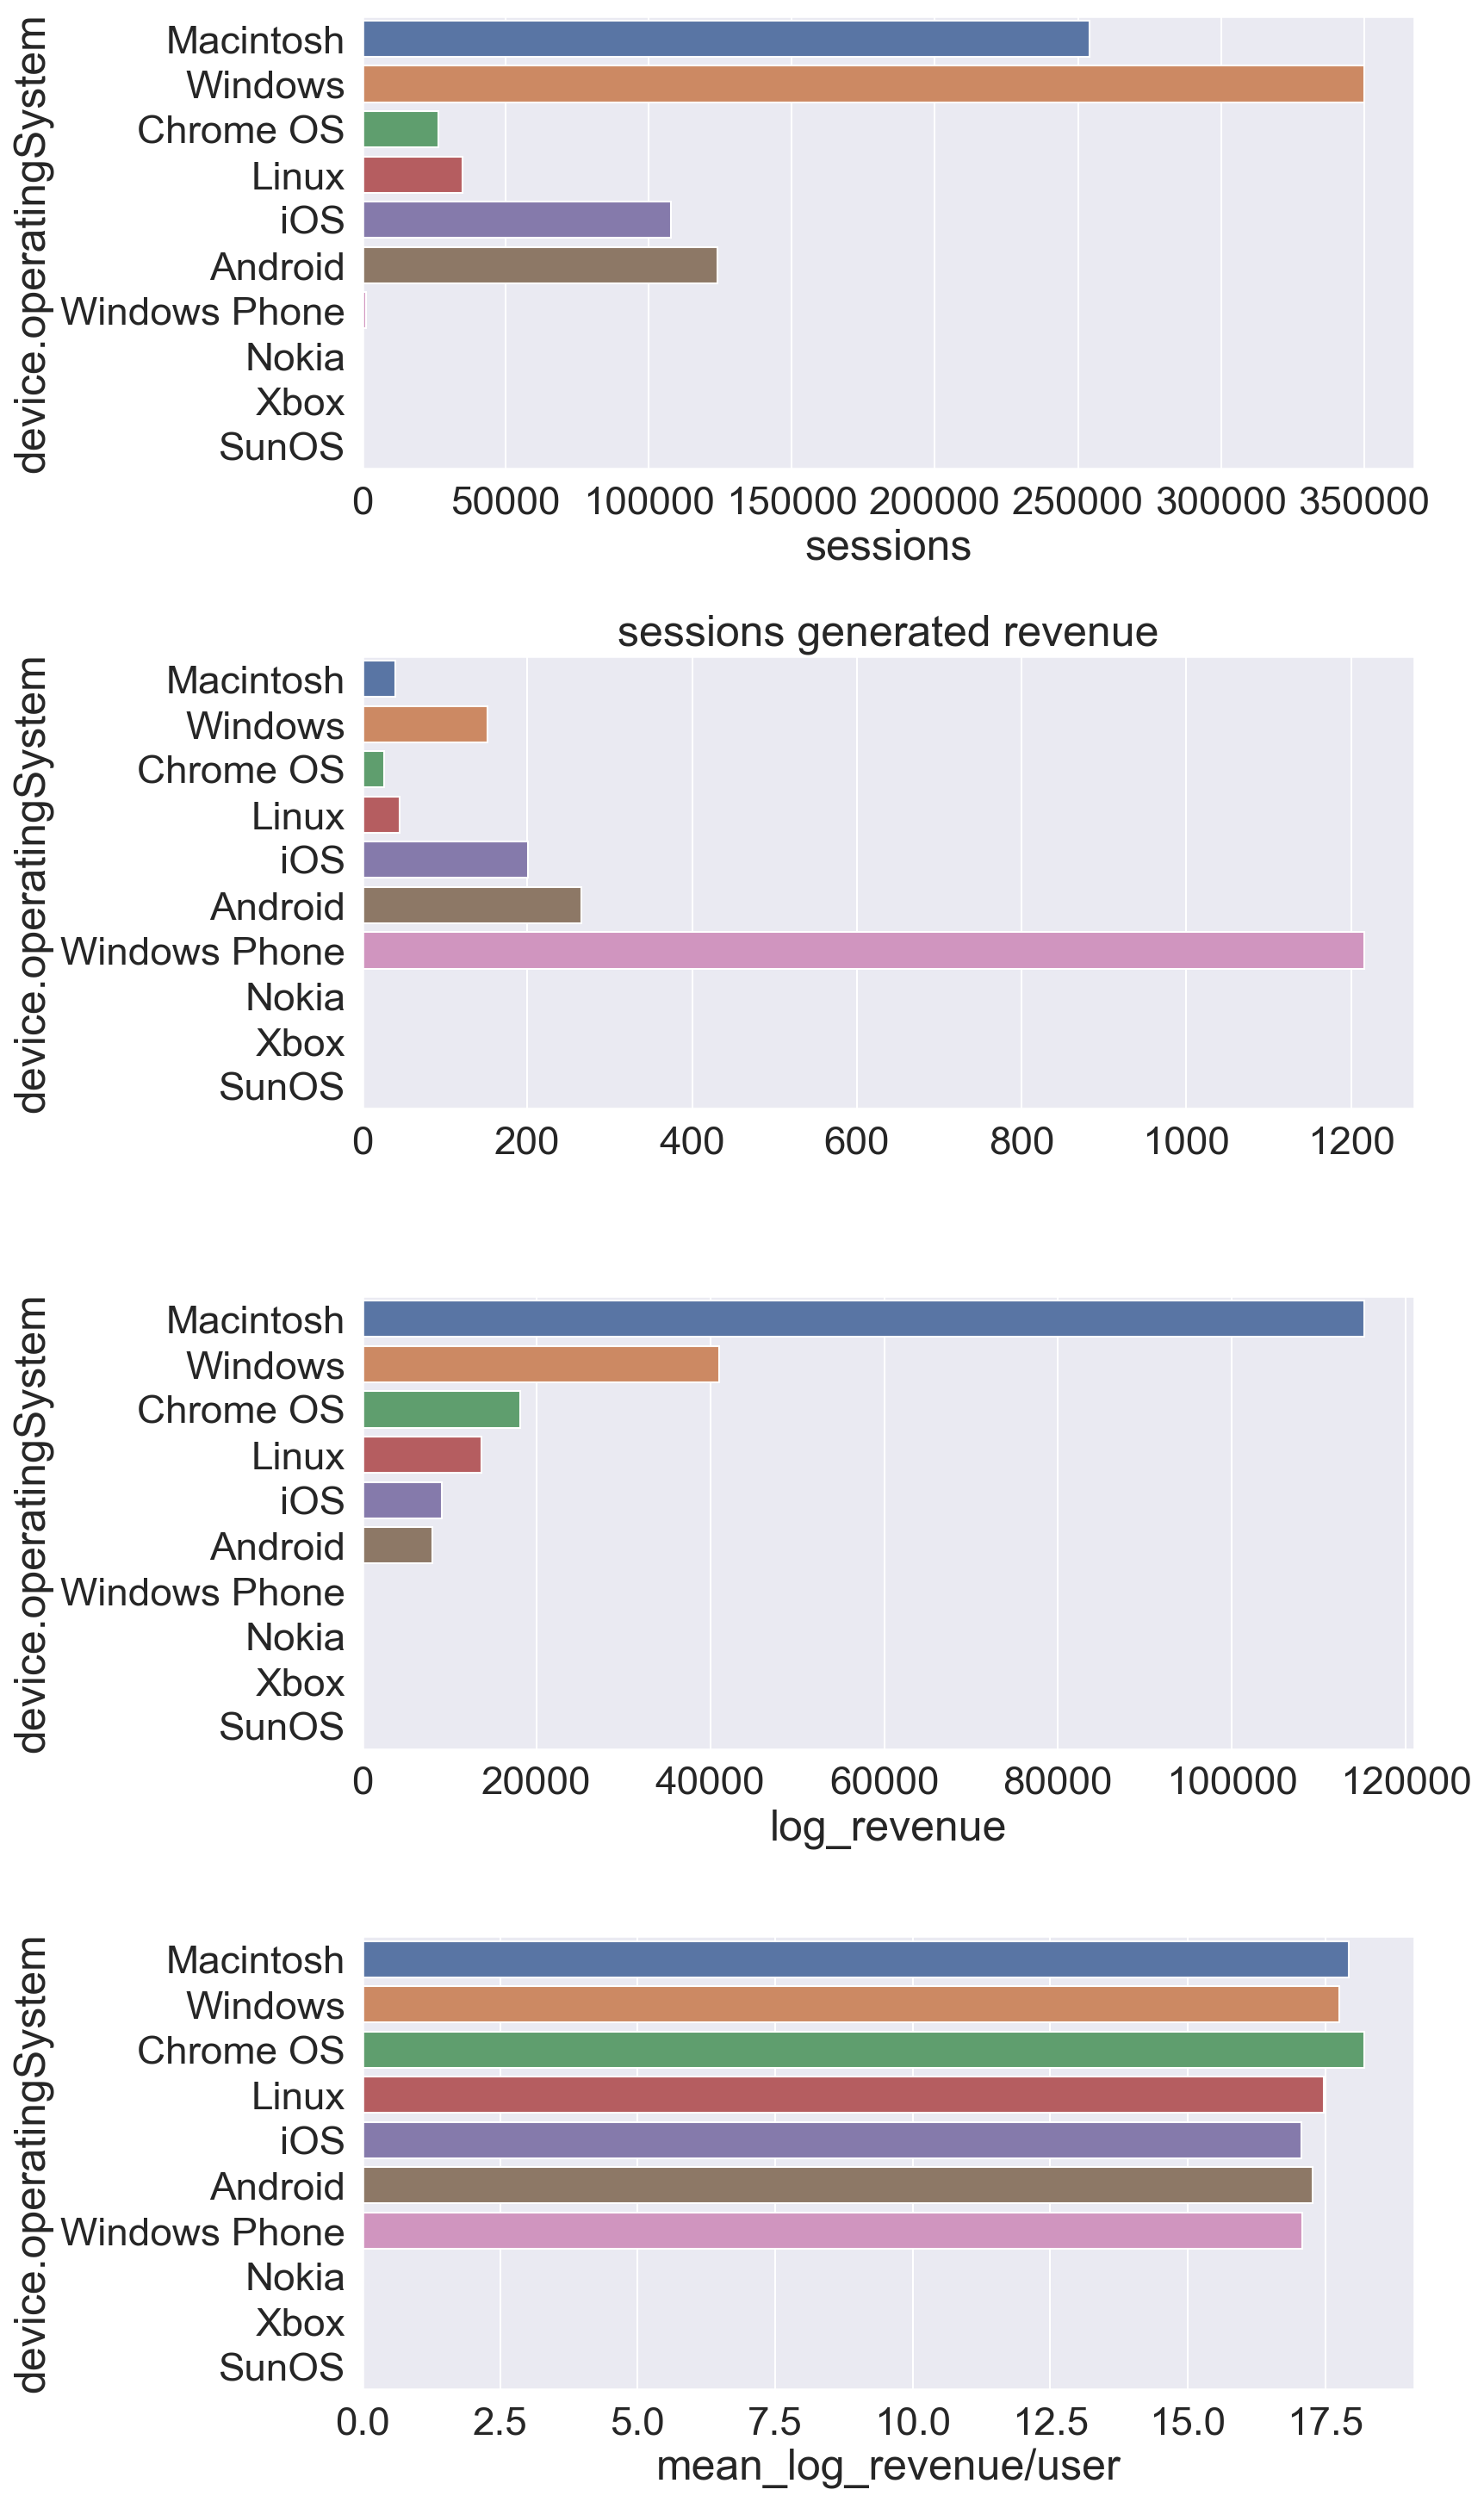

In [238]:
plot_by('device.operatingSystem')

sessions  sessions_revenue    log_revenue  \
device.deviceCategory                                              
desktop                  664479             10495  187728.141318   
mobile                   208725               852   14587.387564   
tablet                    30449               168    2920.488037   

                       mean_log_revenue/user  
device.deviceCategory                         
desktop                            17.887388  
mobile                             17.121347  
tablet                             17.383857

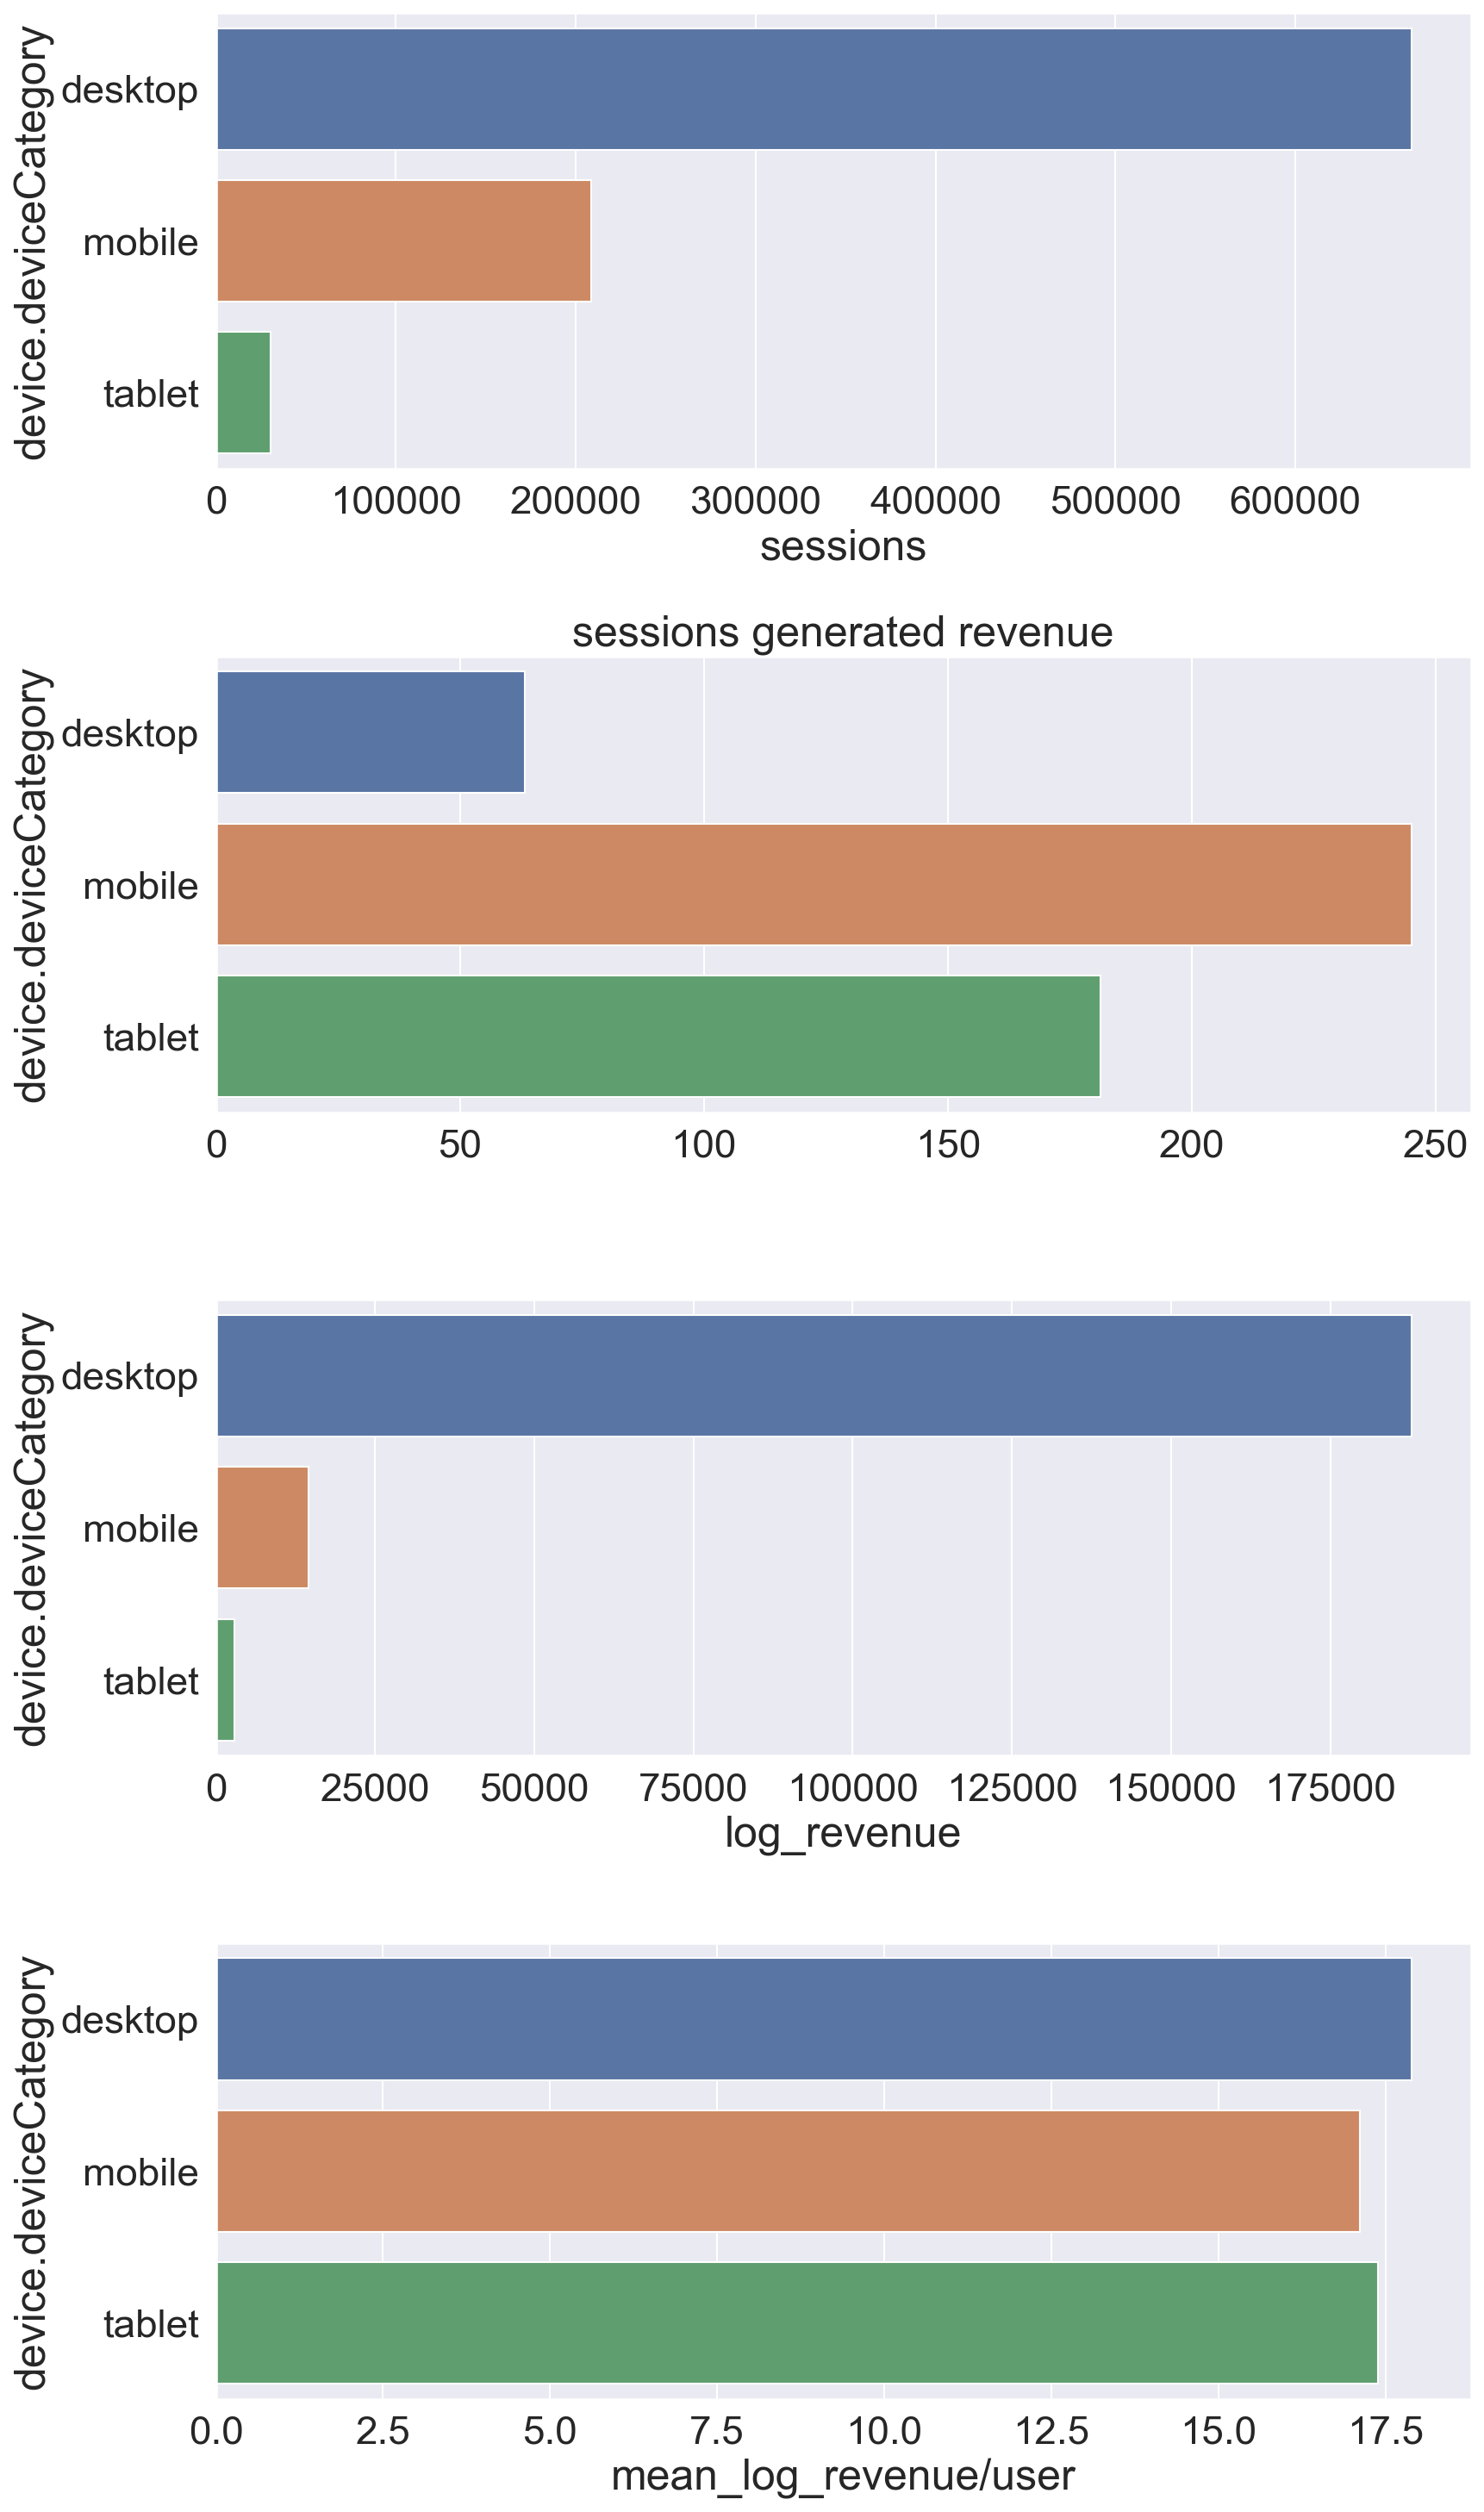

In [239]:
plot_by('device.deviceCategory')

## Exploring Geonetwork category

sessions  sessions_revenue    log_revenue  \
geoNetwork.continent                                              
Americas                450377             11283  201071.500184   
Asia                    223698               125    2248.871962   
Europe                  198311                79    1394.696638   
Oceania                  15054                14     253.468863   
Africa                   14745                 8     158.226967   
(not set)                 1468                 6     109.252305   

                      mean_log_revenue/user  
geoNetwork.continent                         
Americas                          17.820748  
Asia                              17.990976  
Europe                            17.654388  
Oceania                           18.104919  
Africa                            19.778371  
(not set)                         18.208718

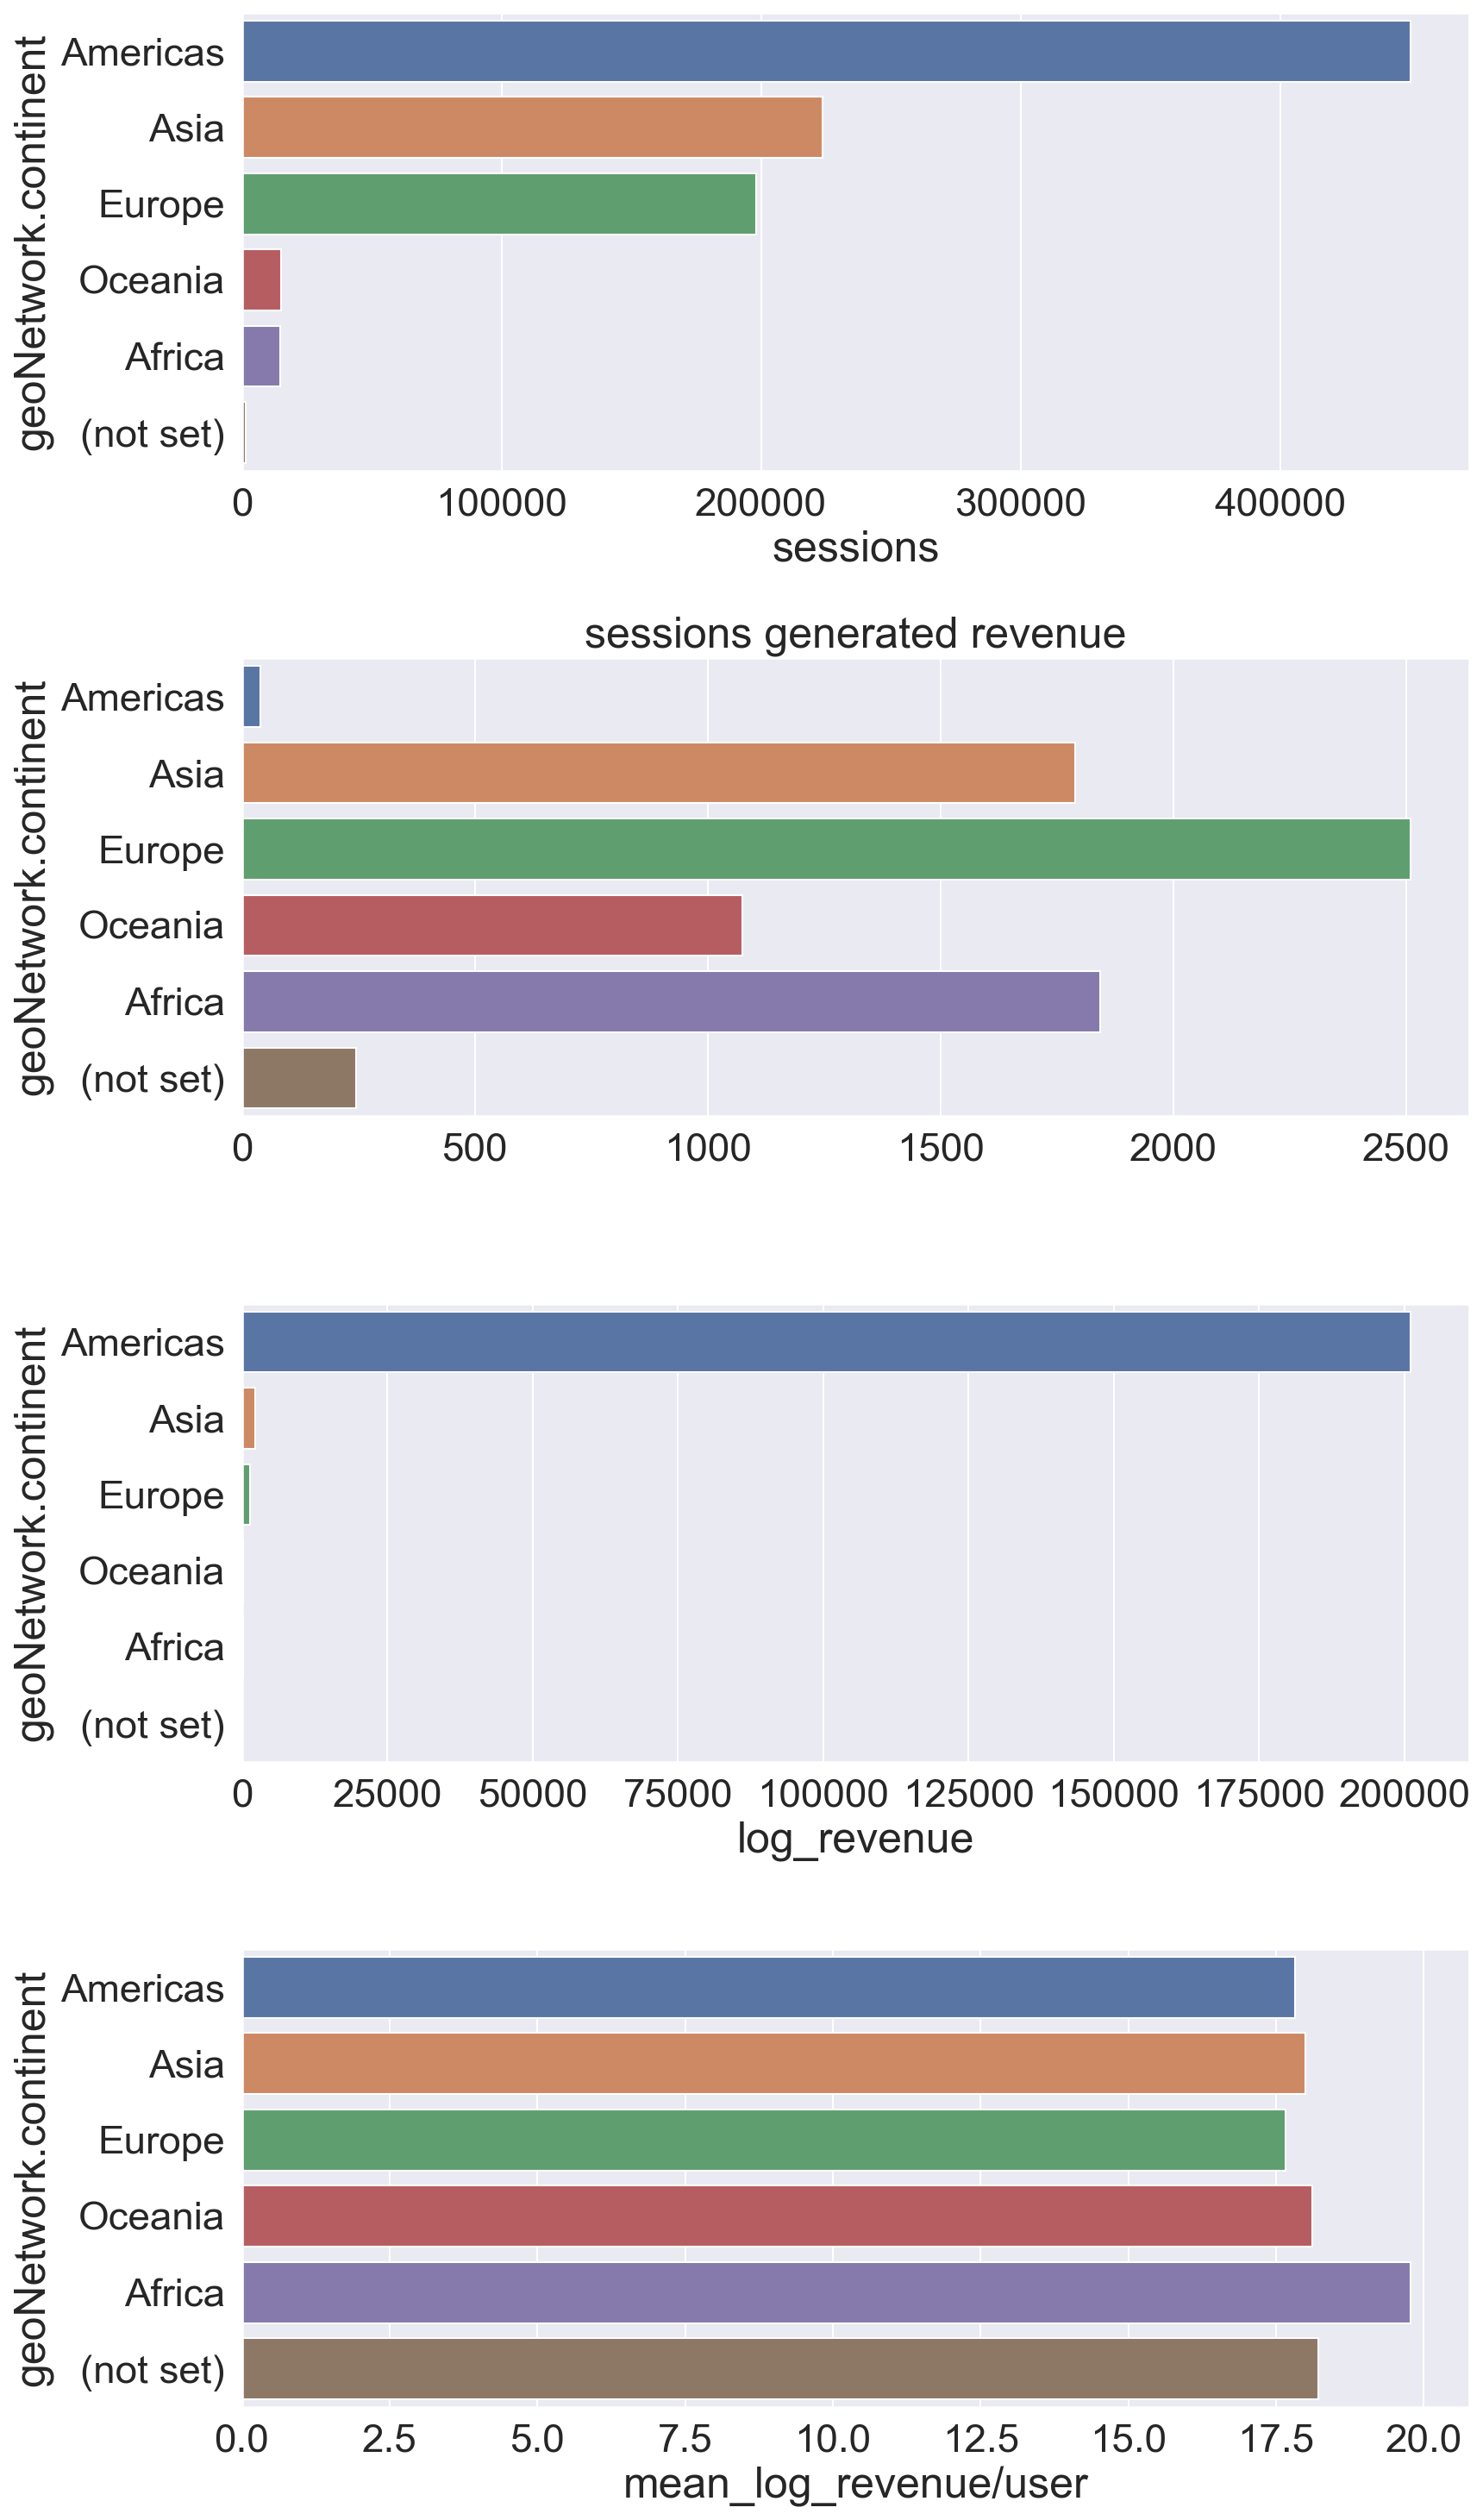

In [318]:
plot_by('geoNetwork.continent')

sessions  sessions_revenue    log_revenue  \
geoNetwork.country                                              
United States         364744             10953  195140.705657   
Canada                 25869               190    3390.063539   
Venezuela               2132                63    1180.855709   
Mexico                 13225                20     355.864799   
Taiwan                 12996                19     341.449981   
...                      ...               ...            ...   
Haiti                     37                 0       0.000000   
Honduras                 188                 0       0.000000   
Iceland                  142                 0       0.000000   
Iran                      41                 0       0.000000   
Åland Islands              1                 0       0.000000   

                    mean_log_revenue/user  
geoNetwork.country                         
United States                   17.816188  
Canada                          17.842440  
Venezuela                       18.743741  
Mexico                          17.793240  
Taiwan                          17.971052  
...                                   ...  
Haiti                                 NaN  
Honduras                              NaN  
Iceland                               NaN  
Iran                                  NaN  
Åland Islands                         NaN  

[222 rows x 4 columns]

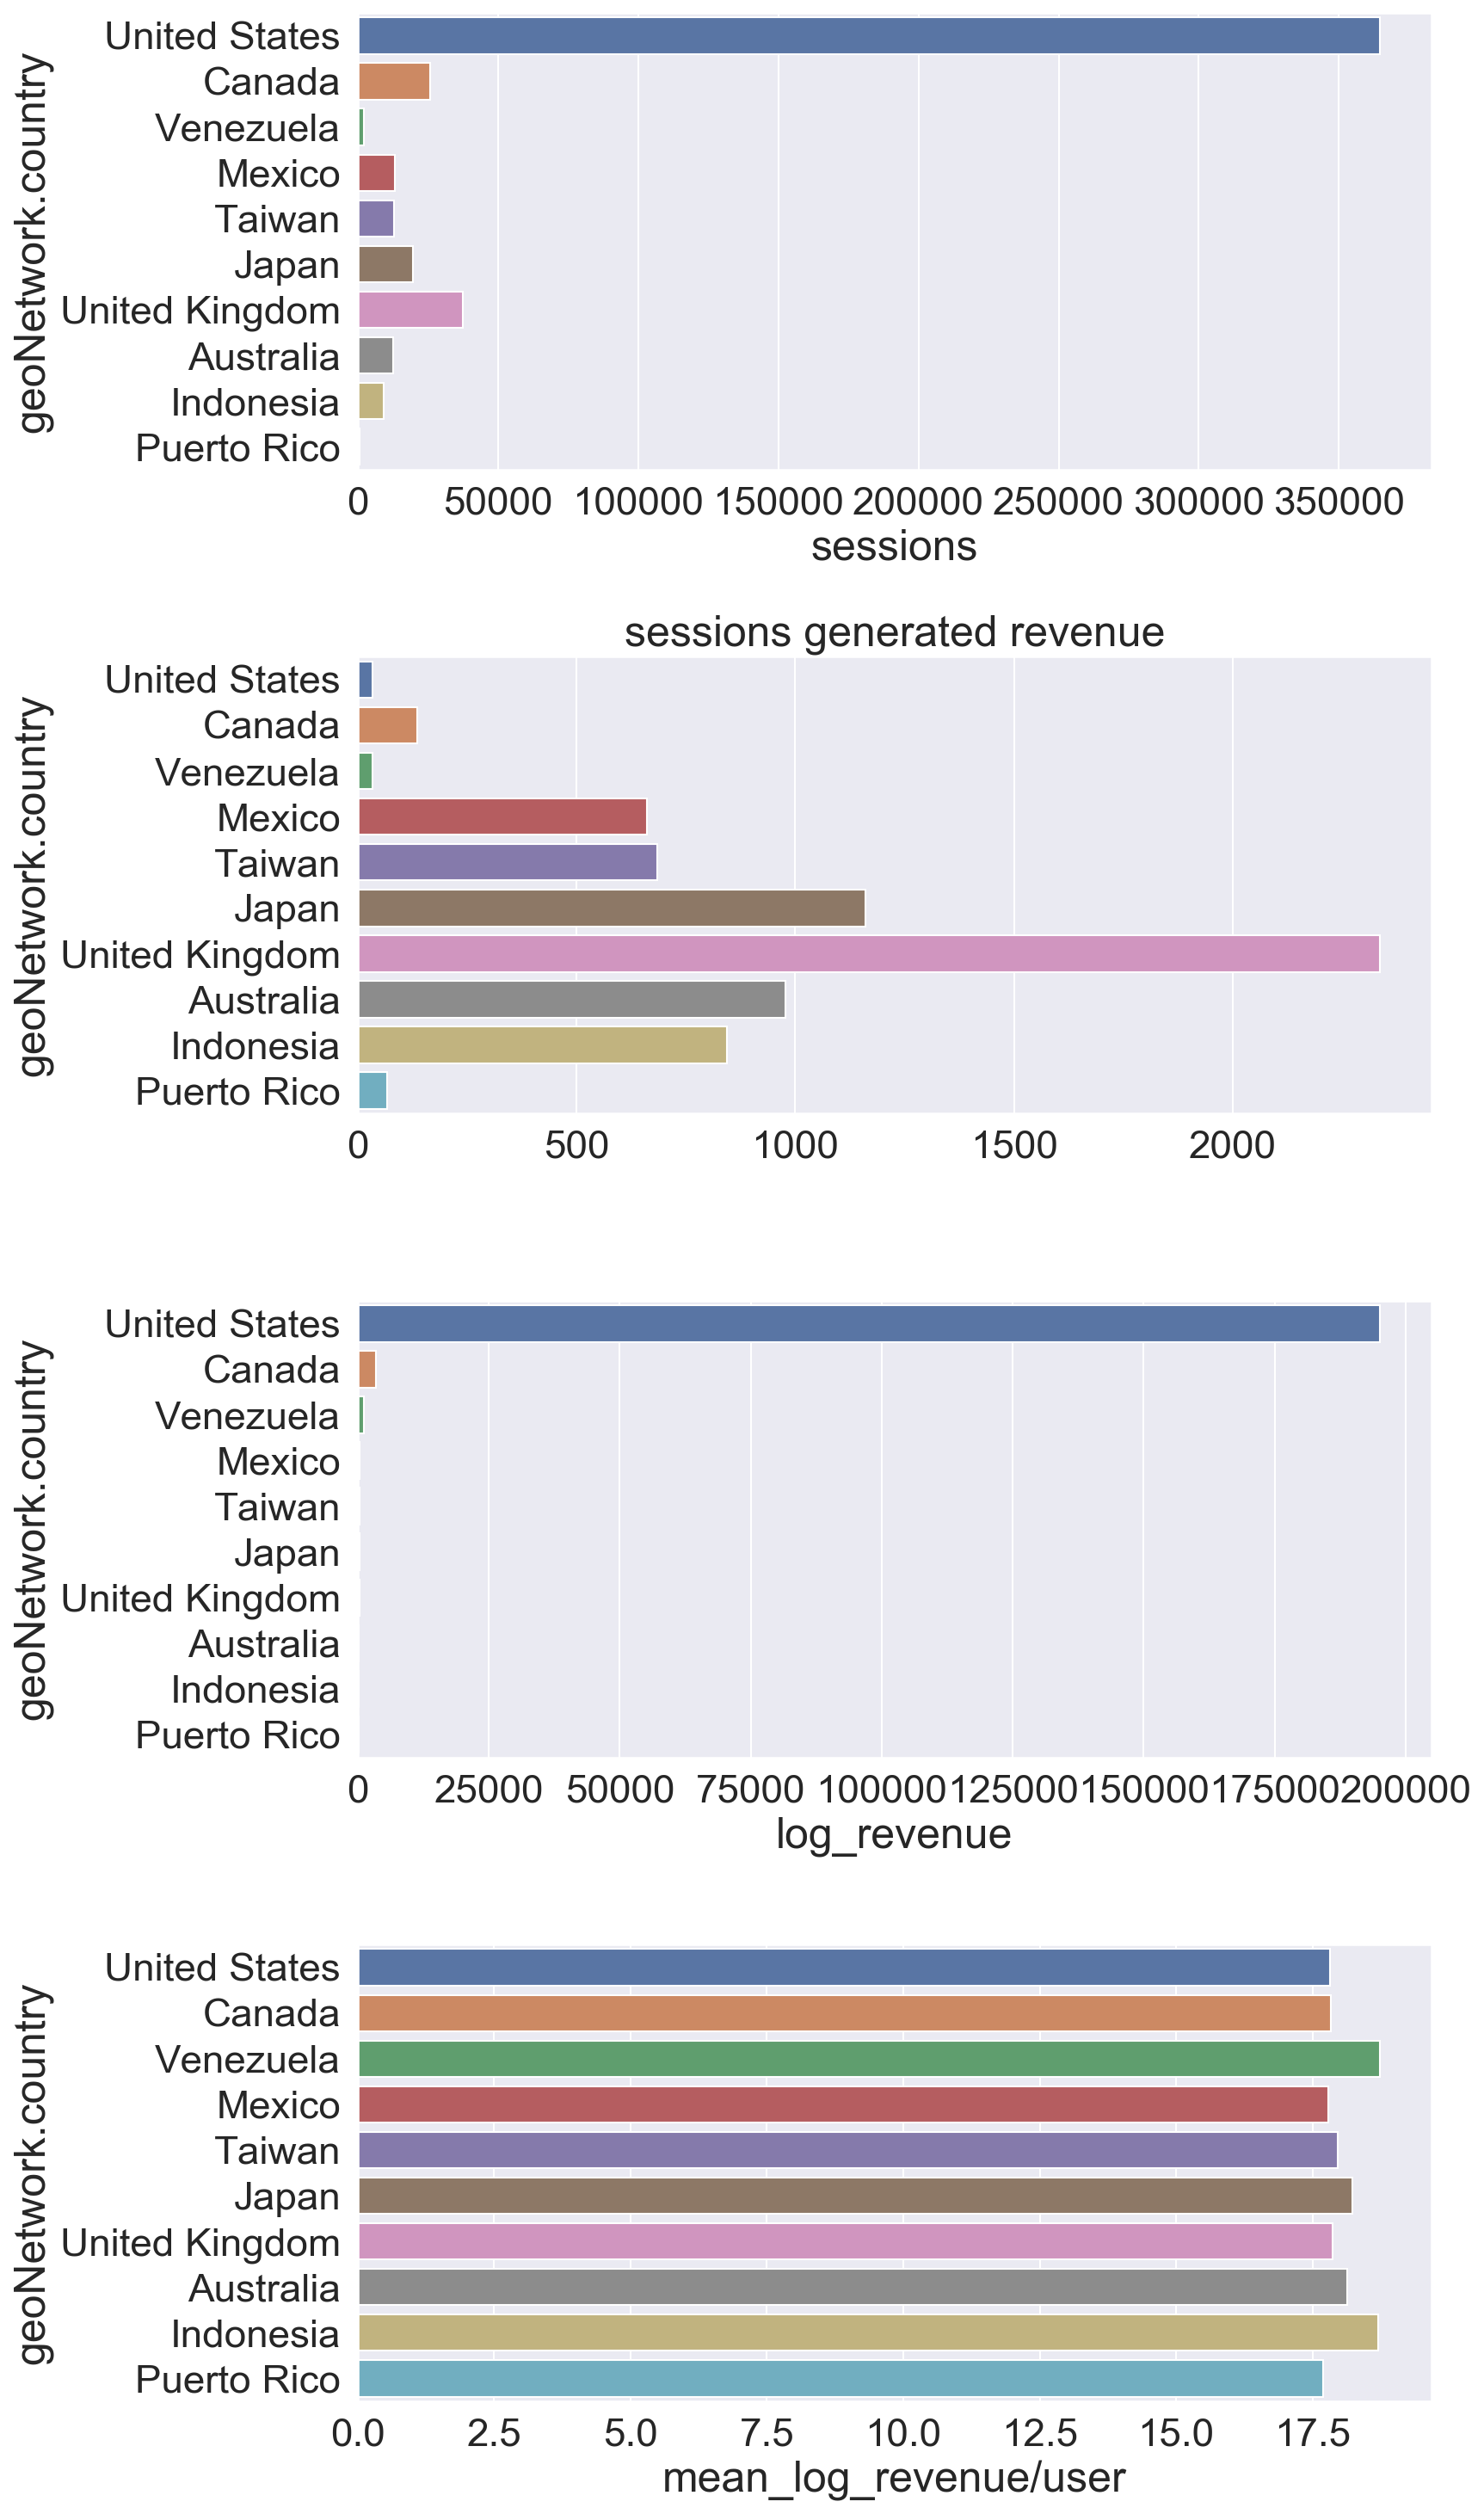

In [319]:
plot_by('geoNetwork.country')

## Explore traffic source category

sessions  sessions_revenue   log_revenue  \
trafficSource.source                                                   
mall.googleplex.com            66416              5103  91377.662471   
google                        400788              3879  68211.553972   
(direct)                      143028              2042  36825.206185   
dfa                             5686               123   2274.194422   
mail.google.com                 1457                62   1170.106145   
...                              ...               ...           ...   
evernote.com                       3                 0      0.000000   
espanol.search.yahoo.com           1                 0      0.000000   
es.search.yahoo.com                4                 0      0.000000   
en.wikipedia.org                   6                 0      0.000000   
yt-go-12345.googleplex.com         1                 0      0.000000   

                            mean_log_revenue/user  
trafficSource.source                               
mall.googleplex.com                     17.906655  
google                                  17.584830  
(direct)                                18.033891  
dfa                                     18.489386  
mail.google.com                         18.872680  
...                                           ...  
evernote.com                                  NaN  
espanol.search.yahoo.com                      NaN  
es.search.yahoo.com                           NaN  
en.wikipedia.org                              NaN  
yt-go-12345.googleplex.com                    NaN  

[380 rows x 4 columns]

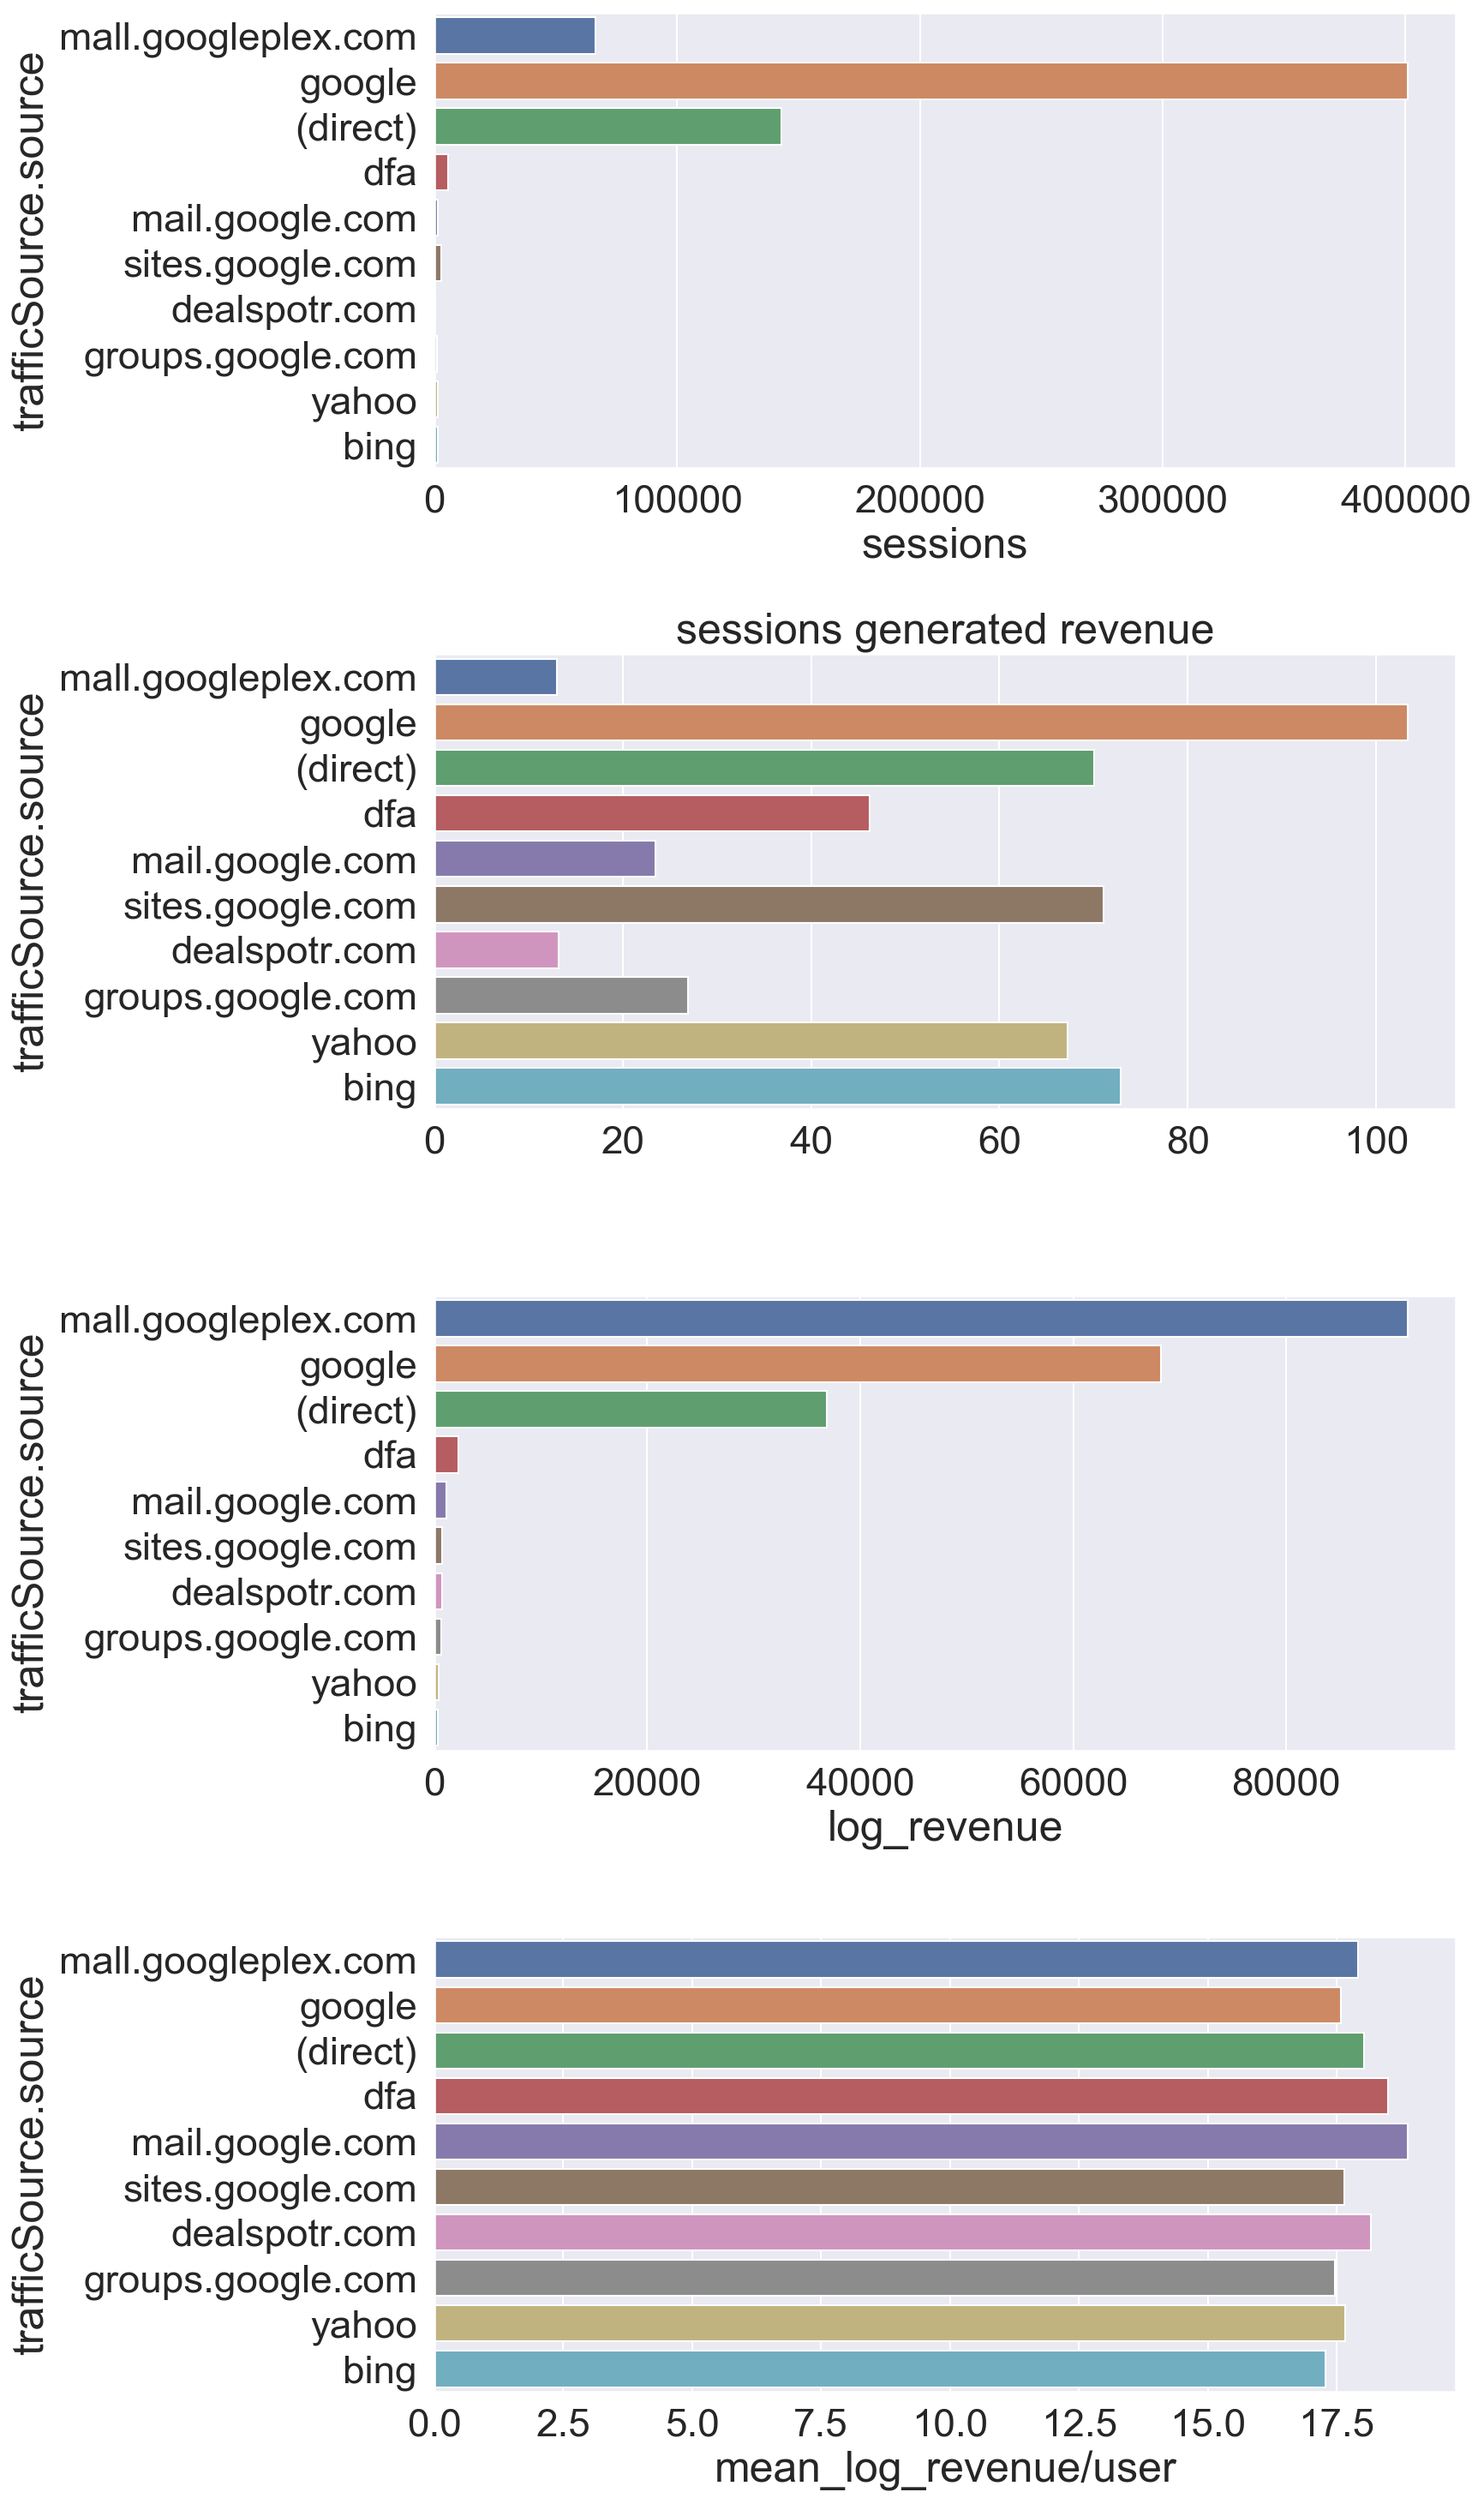

In [320]:
plot_by('trafficSource.source')  # drop fake source 

need to create new feature

sessions  sessions_revenue   log_revenue  \
trafficSource.medium                                             
referral                330955              5415  96956.291289   
organic                 381561              3438  60427.851990   
(none)                  143026              2042  36825.206185   
cpc                      25326               468   8244.459915   
cpm                       6262               142   2611.813074   
affiliate                16403                 9    154.277371   
(not set)                  120                 1     16.117095   

                      mean_log_revenue/user  
trafficSource.medium                         
referral                          17.905132  
organic                           17.576455  
(none)                            18.033891  
cpc                               17.616367  
cpm                               18.393050  
affiliate                         17.141930  
(not set)                         16.117095

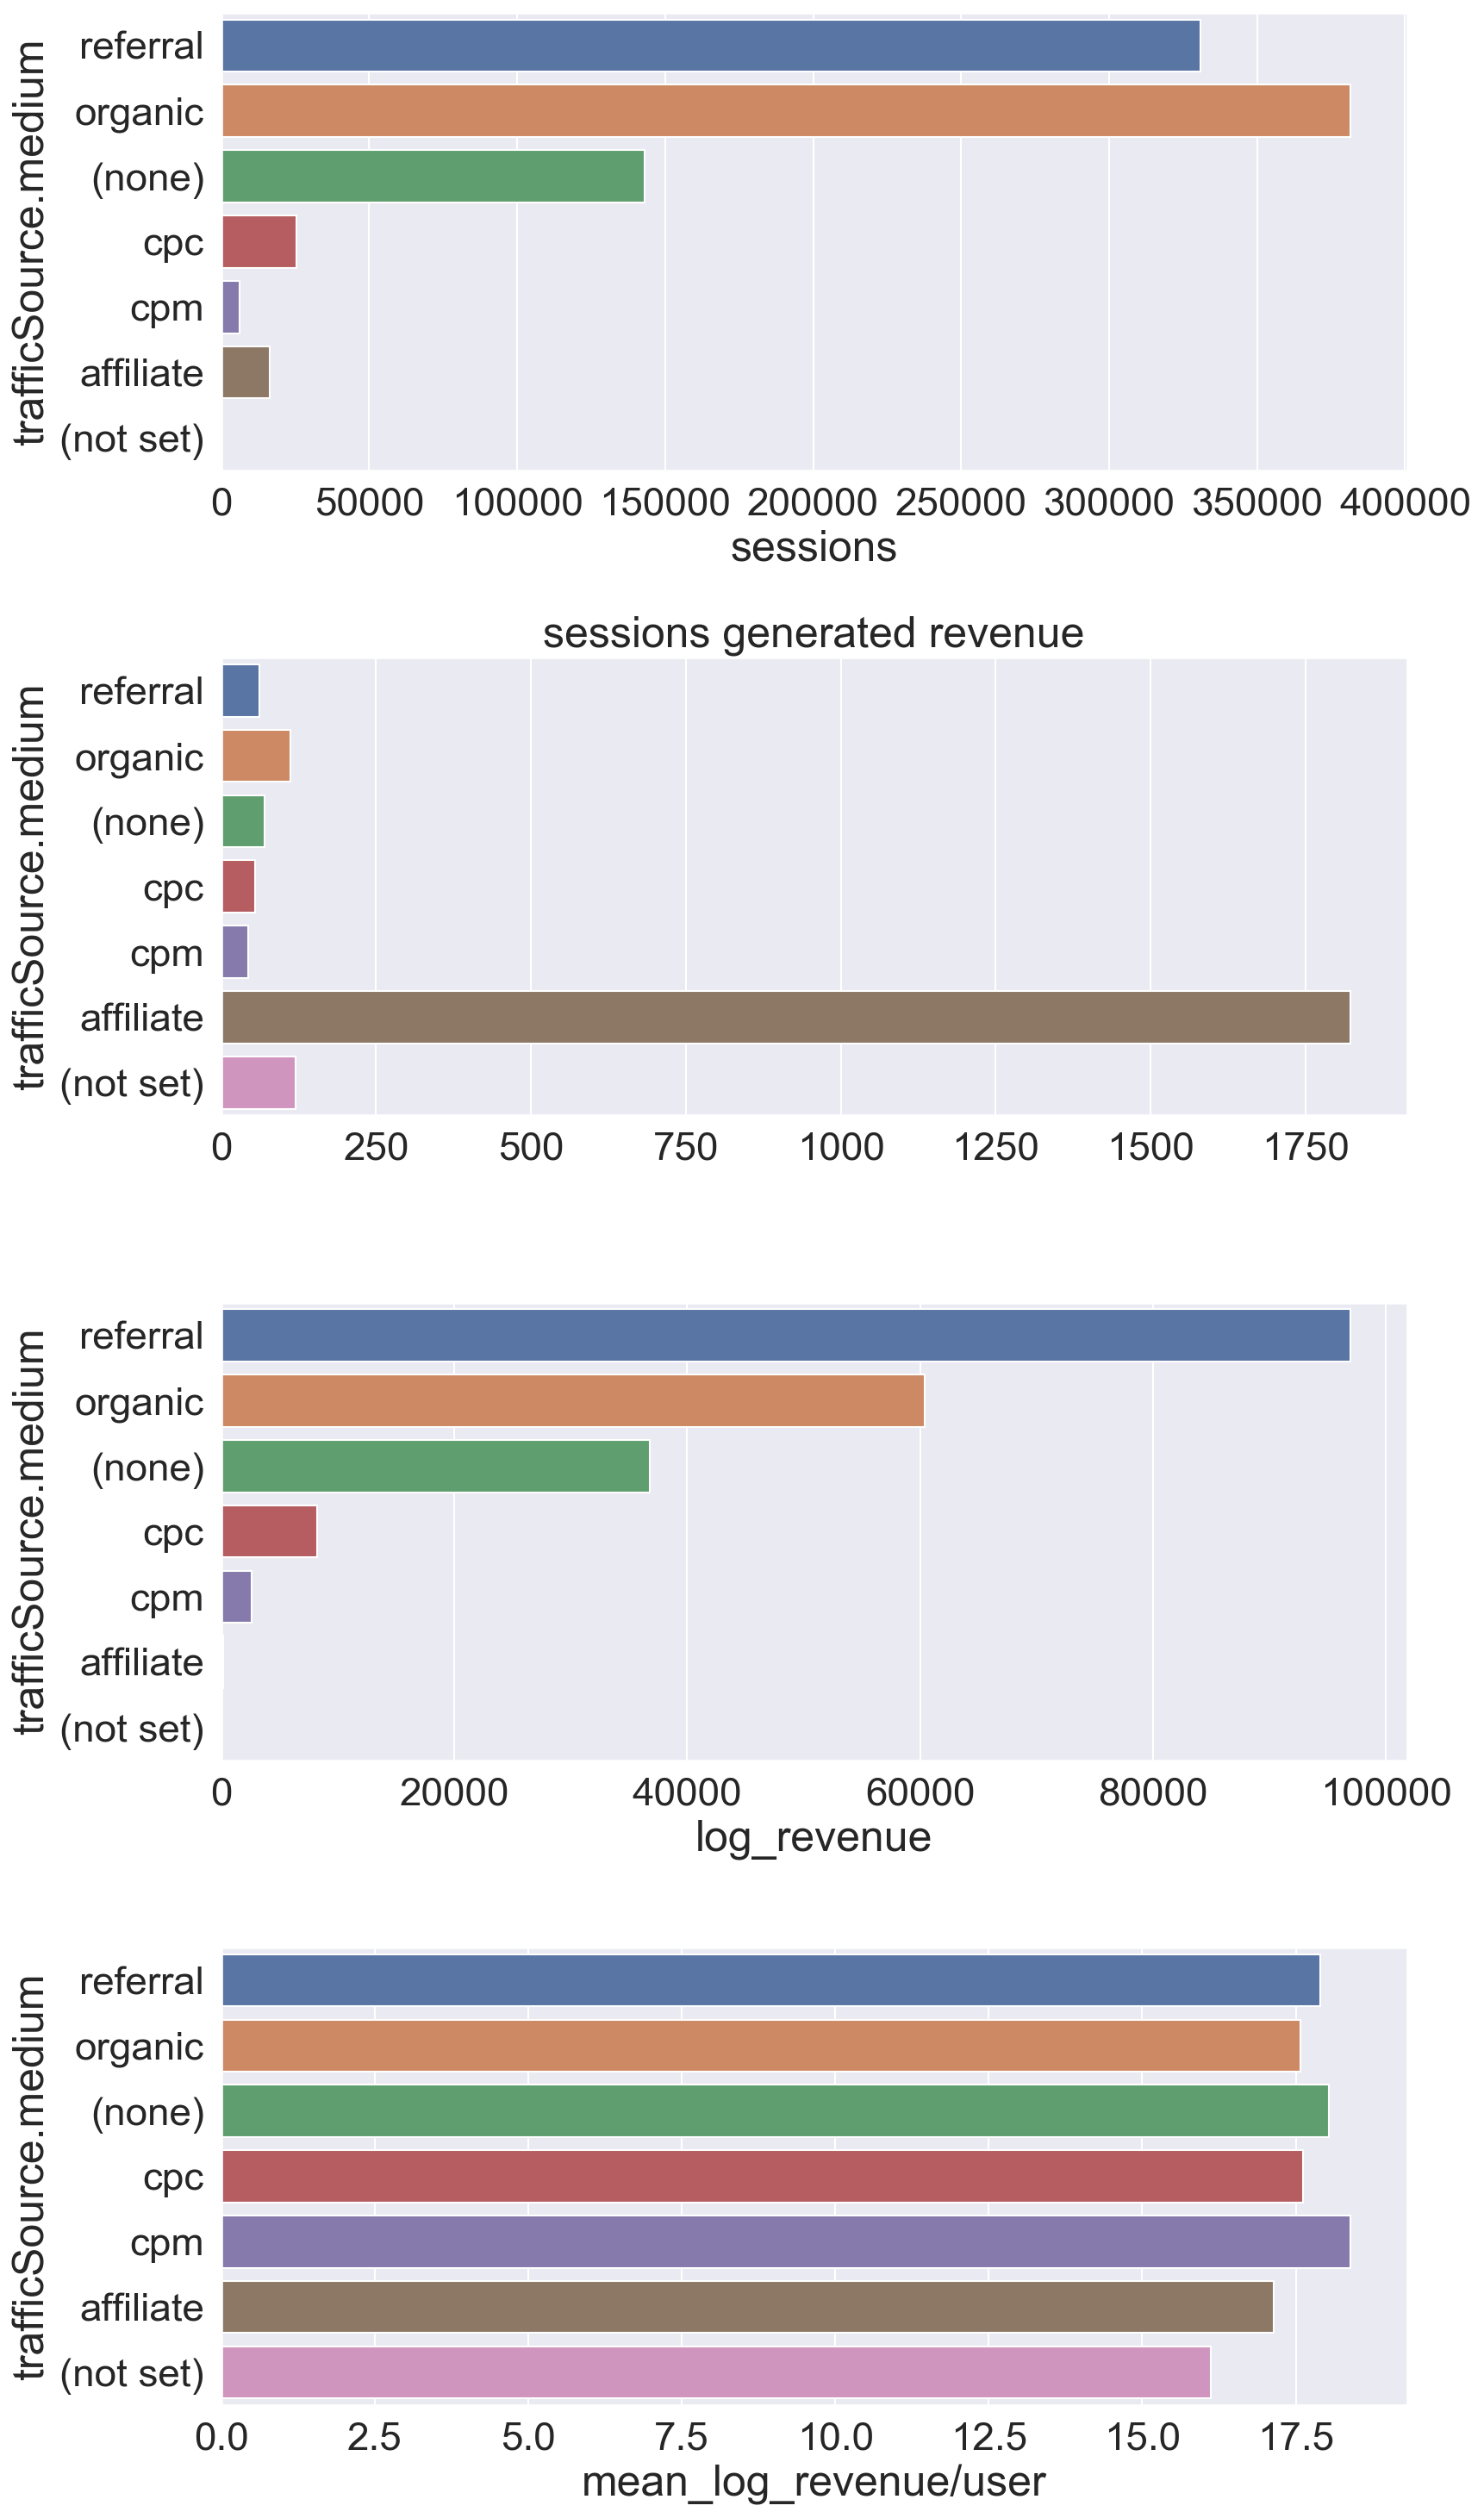

In [321]:
plot_by('trafficSource.medium')

sessions  sessions_revenue  \
trafficSource.campaign                                                        
(not set)                                          865347             11050   
AW - Dynamic Search Ads Whole Site                  14244               323   
AW - Accessories                                     7070               130   
Data Share Promo                                    16403                 9   
AW - Apparel                                           46                 1   
test-liyuhz                                           392                 1   
Retail (DO NOT EDIT owners nophakun and tianyu)        50                 1   
AW - Electronics                                       96                 0   
All Products                                            4                 0   
Data Share                                              1                 0   

                                                   log_revenue  \
trafficSource.campaign                                           
(not set)                                        197050.028236   
AW - Dynamic Search Ads Whole Site                 5683.890280   
AW - Accessories                                   2295.149115   
Data Share Promo                                    154.277371   
AW - Apparel                                         18.169909   
test-liyuhz                                          17.553180   
Retail (DO NOT EDIT owners nophakun and tianyu)      16.948829   
AW - Electronics                                      0.000000   
All Products                                          0.000000   
Data Share                                            0.000000   

                                                 mean_log_revenue/user  
trafficSource.campaign                                                  
(not set)                                                    17.832582  
AW - Dynamic Search Ads Whole Site                           17.597184  
AW - Accessories                                             17.654993  
Data Share Promo                                             17.141930  
AW - Apparel                                                 18.169909  
test-liyuhz                                                  17.553180  
Retail (DO NOT EDIT owners nophakun and tianyu)              16.948829  
AW - Electronics                                                   NaN  
All Products                                                       NaN  
Data Share                                                         NaN

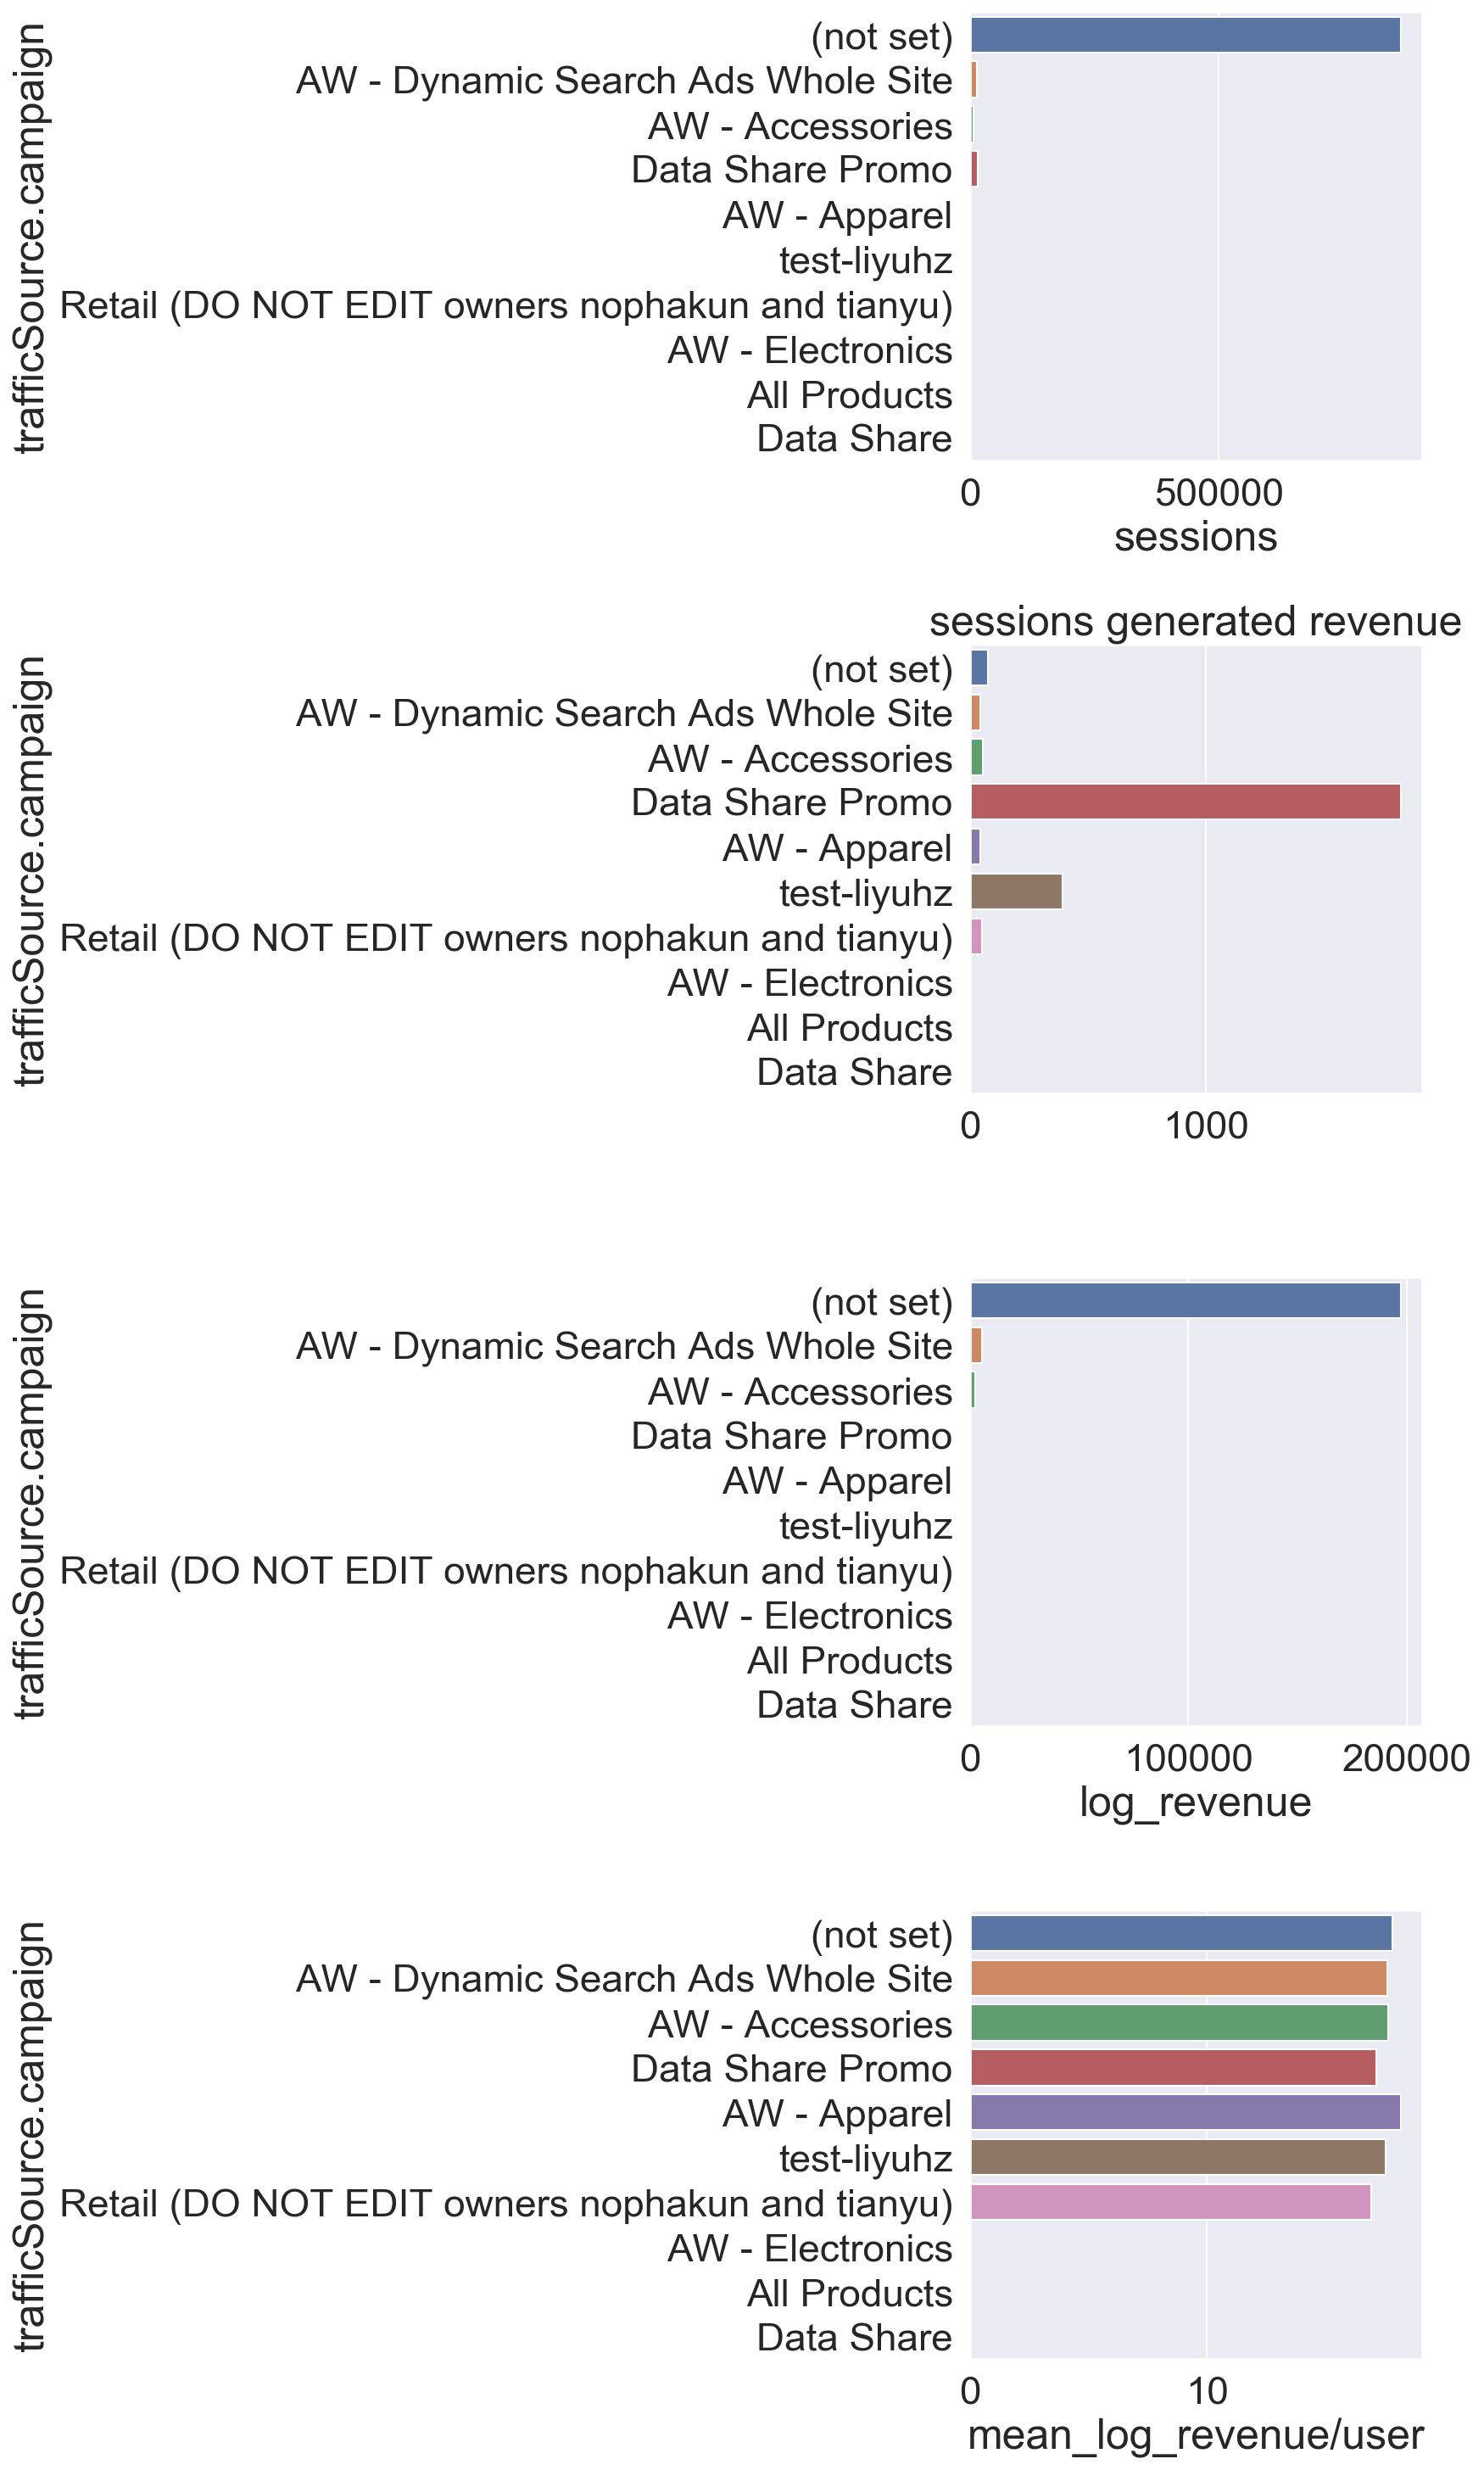

In [322]:
plot_by('trafficSource.campaign')

sessions  sessions_revenue  log_revenue  \
totals.pageviews                                            
16.0                  4010               478  8366.312832   
15.0                  4720               471  8254.872675   
14.0                  5291               467  8200.304226   
13.0                  6197               453  7911.733244   
18.0                  3150               451  7889.772271   
...                    ...               ...          ...   
140.0                    1                 0     0.000000   
219.0                    1                 0     0.000000   
220.0                    1                 0     0.000000   
223.0                    1                 0     0.000000   
1.0                 452522                 0     0.000000   

                  mean_log_revenue/user  
totals.pageviews                         
16.0                          17.502747  
15.0                          17.526269  
14.0                          17.559538  
13.0                          17.465195  
18.0                          17.493952  
...                                 ...  
140.0                               NaN  
219.0                               NaN  
220.0                               NaN  
223.0                               NaN  
1.0                                 NaN  

[213 rows x 4 columns]

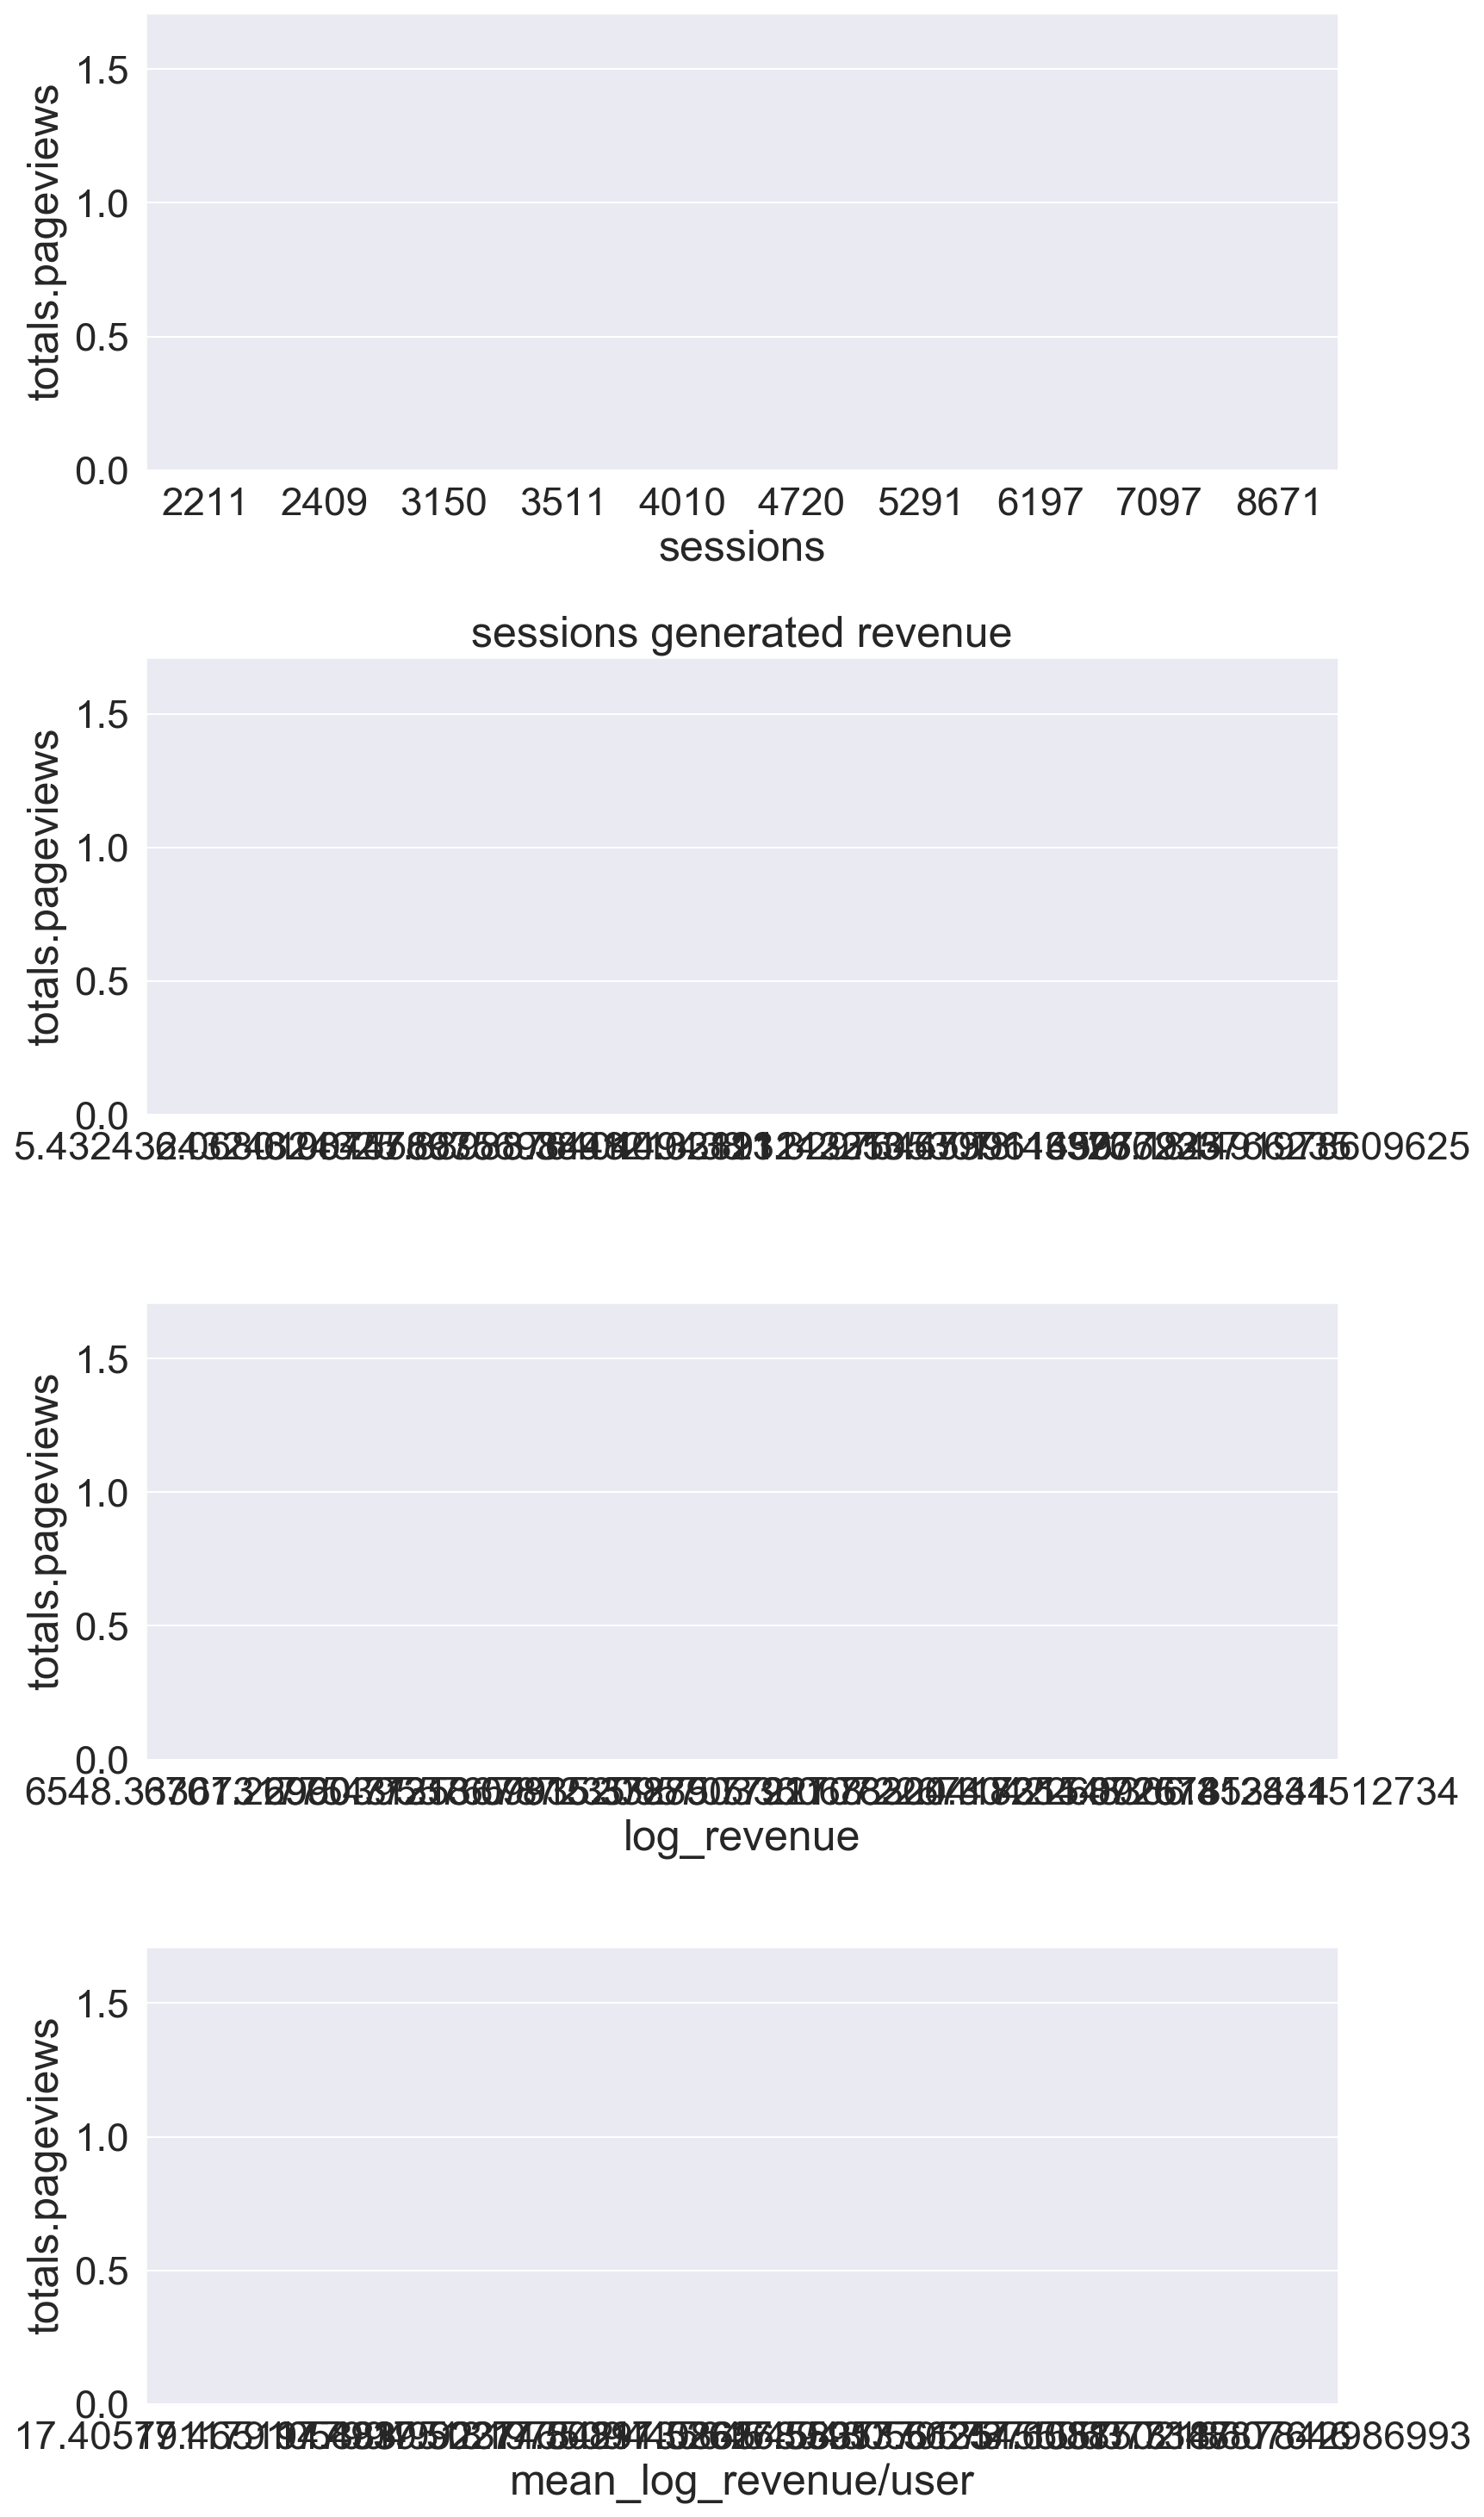

In [324]:
plot_by('totals.pageviews')